# ASA HF Checkpoint + Taxonomy

CPU-only Colab notebook: load the HF checkpoint, and explore the taxonomy and behavior of the model.

**Expected runtime:** a few minutes on CPU for data collection and plot generation.

**Notes:**
- Saves JSON artifacts in `artifacts/` for quick inspection.

In [103]:

#@title Prepare ASA Imports and Dirs

import os, sys, subprocess, platform, json, time, random
from pathlib import Path

repo_dir = 'ASA'

# Clone the repository if it doesn't exist
if not Path(repo_dir).exists():
    subprocess.run(['git','clone','https://github.com/digitaldaimyo/ASA.git'], check=True)

# Get the absolute path of the repository
repo_path_abs = Path(os.getcwd()) / repo_dir

# Add the repository root to sys.path if not already present
# This helps discover top-level modules or packages directly under the repo root.
if str(repo_path_abs) not in sys.path:
    sys.path.insert(0, str(repo_path_abs))

# Check for a common 'src' subdirectory and add it to sys.path if it exists.
# This handles projects where the actual Python package is nested under 'src/'.
src_path_abs = repo_path_abs / 'src'
if src_path_abs.is_dir() and str(src_path_abs) not in sys.path:
    sys.path.insert(0, str(src_path_abs))

# Change the current working directory into the repository
os.chdir(repo_dir)

# Install the package in editable mode and other dependencies
subprocess.run([sys.executable,'-m','pip','install','-e','.'], check=True)
subprocess.run([sys.executable,'-m','pip','install','-q','huggingface_hub','safetensors','transformers','datasets', 'torchinfo'], check=True)
import torch
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer

device = torch.device('cpu')
print('Python:', platform.python_version())
print('Torch:', torch.__version__)
print('Device:', device)
try:
    commit = subprocess.check_output(['git','rev-parse','HEAD']).decode().strip()
    print('Repo commit:', commit)
except Exception:
    print('Repo commit: unavailable')

seed = 1337
random.seed(seed)
torch.manual_seed(seed)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)

Python: 3.12.12
Torch: 2.9.0+cpu
Device: cpu
Repo commit: 05b8f277567610f80bb29b44b758faff8c94c3fe


In [104]:
#@title Load and Summarize Model rom HF
from torchinfo import summary as model_summary
from asa.load_pretrained import load_pretrained

HF_REPO = 'DigitalShogun/ASA-ASM-wikitext103-raw'
DEFAULT_CKPT = 'ASA_ASM_wt103-rawv1_gpt2_T1024_L21_D384_H8_K16_M32_ropek1_alibi1_gamma1_step75000_best.pt'

def count_params(model):
    n = sum(p.numel() for p in model.parameters())
    n_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return n, n_train

def cfg_summary(cfg):
    return {
        "layers": cfg.num_layers,
        "d_model": cfg.embed_dim,
        "heads": cfg.num_heads,
        "slots": cfg.num_slots,
        "T": cfg.max_seq_len,
        "slotspace": cfg.use_slotspace_refine,
        "slotspace_dim": cfg.slotspace_dim,
        "content_read": cfg.use_content_read,
        "alibi_write": cfg.use_alibi_write,
        "rope_keys": cfg.use_rope_keys,
    }

def print_cfg_summary(cfg, model):
    n, n_train = count_params(model)
    summ = cfg_summary(cfg)
    print("Config:", ", ".join([f"{k}={v}" for k,v in summ.items()]))
    print(f"Params: {n/1e6:.2f}M")


model, report, cfg_obj = load_pretrained(HF_REPO, DEFAULT_CKPT, variant='baseline', device='cpu')
print('Loaded model with vocab_size:', cfg_obj.vocab_size)
print('Checkpoint source:', report['state_dict_source'])
print('Allowlisted gaps:', {
    'missing': len(report['allowed_missing']),
    'unexpected': len(report['allowed_unexpected']),
    'mismatched': len(report['allowed_mismatched']),
})

input_ids = torch.randint(0, cfg_obj.vocab_size, (1, 32))
with torch.no_grad():
    logits, _ = model(input_ids)
print('Logits shape:', tuple(logits.shape))
assert logits.shape == (1, 32, cfg_obj.vocab_size)
assert torch.isfinite(logits).all()

run_metadata = {
    'repo': HF_REPO,
    'checkpoint': DEFAULT_CKPT,
    'state_dict_source': report['state_dict_source'],
    'seed': seed,
    'timestamp': time.time(),
    'config': cfg_obj.__dict__,
}
(artifacts_dir / 'run_metadata.json').write_text(json.dumps(run_metadata, indent=2))

print(cfg_obj)
print_cfg_summary(cfg_obj, model)
model_summary(model, input_size=(1, 1024), dtypes=[torch.long])

for name, param in model.named_parameters():
    print(f"Name: {name} | Shape: {param.shape}")

Loaded model with vocab_size: 50257
Checkpoint source: model
Allowlisted gaps: {'missing': 42, 'unexpected': 0, 'mismatched': 0}
Logits shape: (1, 32, 50257)
ASMTrainConfig(dataset_name='wikitext', dataset_config='wikitext-103-raw-v1', tokenizer_name='gpt2', max_seq_len=1024, stride_frac_val=0.5, seed=1337, train_samples_target=100000000, val_samples_target=25000, batch_size=32, learning_rate=0.0003, weight_decay=0.01, betas=[0.9, 0.95], grad_clip=1.0, warmup_steps=1000, total_steps=75000, eval_interval=1000, log_interval=100, vocab_size=50257, embed_dim=384, num_layers=21, num_heads=8, num_slots=16, mlp_ratio=4.0, dropout=0.1, tie_weights=True, read_temperature=1.0, write_temperature=1.0, slot_dropout=0.05, state_fp32=True, normalize_k=False, use_abs_pos=False, use_rope_keys=True, rope_base=10000.0, use_alibi_write=True, alibi_strength_init=0.1, learn_alibi_strength=True, min_strength=0.0, use_content_read=True, content_read_init=-4.0, content_read_max_gamma=3.0, write_chunk_size=128,

## Run Analysis

In [105]:



#@title Batch Data Generation

import os, random, pickle
from typing import List, Tuple, Optional, Iterator, Dict

import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer


# -------------------------
# Minimal dataset classes (same as training)
# -------------------------
class StableValidationDataset(Dataset):
    def __init__(self, samples: List[Tuple[torch.Tensor, torch.Tensor]]):
        self.samples = samples
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

def _ensure_dir(path: str):
    d = os.path.dirname(path)
    if d:
        os.makedirs(d, exist_ok=True)

def build_or_load_token_stream(
    *,
    cache_path: str,
    dataset_name: str,
    dataset_config: str,
    split: str,
    tokenizer_name: str,
    min_chars: int = 1,
    add_eos_between_rows: bool = True,
    max_rows: Optional[int] = None,
) -> List[int]:
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            stream = pickle.load(f)
        return stream

    _ensure_dir(cache_path)
    tok = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
    eos = tok.eos_token_id
    assert eos is not None, "Tokenizer must have eos_token_id"

    ds = load_dataset(dataset_name, dataset_config, split=split)

    stream: List[int] = []
    used = 0
    for row in ds:
        if max_rows is not None and used >= max_rows:
            break
        text = (row.get("text") or "").strip()
        if len(text) < min_chars:
            continue
        ids = tok.encode(text, add_special_tokens=False)
        if not ids:
            continue
        stream.extend(ids)
        if add_eos_between_rows:
            stream.append(eos)
        used += 1

    with open(cache_path, "wb") as f:
        pickle.dump(stream, f)
    return stream

def build_or_load_validation_windows(
    *,
    cache_path: str,
    token_stream: List[int],
    max_seq_len: int,
    stride_frac: float,
    val_samples_target: int,
) -> StableValidationDataset:
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            samples = pickle.load(f)
        return StableValidationDataset(samples)

    _ensure_dir(cache_path)

    T = int(max_seq_len)
    stride = max(1, int(T * float(stride_frac)))
    need = int(val_samples_target)

    max_start = len(token_stream) - (T + 1)
    if max_start <= 0:
        raise ValueError("Validation token stream too small for max_seq_len+1")

    samples: List[Tuple[torch.Tensor, torch.Tensor]] = []
    for start in range(0, max_start + 1, stride):
        chunk = token_stream[start:start + T + 1]
        if len(chunk) < T + 1:
            break
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        samples.append((x, y))
        if len(samples) >= need:
            break

    with open(cache_path, "wb") as f:
        pickle.dump(samples, f)
    return StableValidationDataset(samples)

class WikiTextRandomWindowStream(IterableDataset):
    def __init__(self, token_stream: List[int], max_seq_len: int, train_samples_target: int, seed: int):
        super().__init__()
        self.stream = token_stream
        self.T = int(max_seq_len)
        self.target = int(train_samples_target)
        self.seed = int(seed)
        self.max_start = len(self.stream) - (self.T + 1)
        if self.max_start <= 0:
            raise ValueError("Train token stream too small for max_seq_len+1")

    def __iter__(self):
        info = torch.utils.data.get_worker_info()
        wid = info.id if info is not None else 0
        rng = random.Random(self.seed + 17 * wid)

        yielded = 0
        while yielded < self.target:
            start = rng.randint(0, self.max_start)
            chunk = self.stream[start:start + self.T + 1]
            x = torch.tensor(chunk[:-1], dtype=torch.long)
            y = torch.tensor(chunk[1:], dtype=torch.long)
            yield x, y
            yielded += 1


# -------------------------
# Analysis batch generator
# -------------------------
def make_batch_generator(
    cfg,
    *,
    split: str = "val",                 # "val" or "train"
    device: Optional[torch.device] = None,
    seq_len: int = 0,
    num_workers: int = 0,               # 0 is safest for Colab analysis
    pin_memory: bool = True,
    batches_per_epoch: Optional[int] = None,  # if set, generator stops after N batches
    infinite: bool = True,              # if True, cycles (val) or keeps sampling (train)
    seed: Optional[int] = None,         # override cfg.seed for sampling
) -> Iterator[Tuple[torch.Tensor, torch.Tensor]]:
    """
    Yields xb,yb batches shaped [B,T] int64.

    - split="val": deterministic stable windows (cached) then cycles if infinite=True
    - split="train": random windows from cached token stream; infinite is naturally True
    """
    assert split in ("val", "train")
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Resolve cfg fields with fallback (works for dict-like or dataclass)
    def get(name, default=None):
        return getattr(cfg, name, cfg.get(name, default) if isinstance(cfg, dict) else default)

    cache_dir = get("cache_dir")
    #dataset_name = get("dataset_name")
    dataset_name = "Salesforce/wikitext"
    dataset_config = get("dataset_config")
    tokenizer_name = get("tokenizer_name")
    max_seq_len = seq_len if seq_len > 0 else int(get("max_seq_len"))
    #batch_size = int(get("batch_size"))
    batch_size = 4
    stride_frac_val = float(get("stride_frac_val", 0.5))
    val_samples_target = int(get("val_samples_target", 25_000))
    val_windows_cache = get("val_windows_cache")
    train_samples_target = int(get("train_samples_target", 100_000_000))
    used_seed = int(seed if seed is not None else get("seed", 1337))

    os.makedirs(cache_dir, exist_ok=True)
    train_stream_cache = os.path.join(cache_dir, f"{dataset_config}_train_stream.pkl")
    val_stream_cache   = os.path.join(cache_dir, f"{dataset_config}_val_stream.pkl")

    if split == "train":
        train_stream = build_or_load_token_stream(
            cache_path=train_stream_cache,
            dataset_name=dataset_name,
            dataset_config=dataset_config,
            split="train",
            tokenizer_name=tokenizer_name,
            min_chars=1,
            add_eos_between_rows=True,
        )
        ds = WikiTextRandomWindowStream(
            token_stream=train_stream,
            max_seq_len=max_seq_len,
            train_samples_target=train_samples_target,
            seed=used_seed,
        )
        loader = DataLoader(
            ds,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory and torch.cuda.is_available(),
        )

        yielded = 0
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            yield xb, yb
            yielded += 1
            if batches_per_epoch is not None and yielded >= batches_per_epoch:
                if infinite:
                    yielded = 0
                    continue
                break

    else:
        # val
        val_stream = build_or_load_token_stream(
            cache_path=val_stream_cache,
            dataset_name=dataset_name,
            dataset_config=dataset_config,
            split="validation",
            tokenizer_name=tokenizer_name,
            min_chars=1,
            add_eos_between_rows=True,
        )
        val_ds = build_or_load_validation_windows(
            cache_path=val_windows_cache,
            token_stream=val_stream,
            max_seq_len=max_seq_len,
            stride_frac=stride_frac_val,
            val_samples_target=val_samples_target,
        )
        loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory and torch.cuda.is_available(),
        )

        while True:
            yielded = 0
            for xb, yb in loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                yield xb, yb
                yielded += 1
                if batches_per_epoch is not None and yielded >= batches_per_epoch:
                    break
            if not infinite:
                break


# -------------------------
# Quick smoke test
# -------------------------

analysis_data_gen = make_batch_generator(cfg_obj, batches_per_epoch=50, split="val", device=device)
xb, yb = next(analysis_data_gen)
print(xb.shape, yb.shape, xb.device, xb.dtype)


#

torch.Size([4, 1024]) torch.Size([4, 1024]) cpu torch.int64


In [106]:


#@title Forward Pass, Collect Out Infos

@torch.no_grad()
def run_with_infos(model, xb: torch.Tensor, attention_mask=None):
    out = model(xb, return_info=True, attention_mask=attention_mask)
    if isinstance(out, tuple) and len(out) == 2:
        logits, infos = out
    else:
        raise ValueError("Model did not return (logits, infos) under return_info=True")
    return logits, infos

logits, infos = run_with_infos(model, xb[:4])
print("logits:", logits.shape, logits.dtype)
print("num layers infos:", len(infos))
print("info keys example:", list(infos[0].keys()))
print("read_weights shape:", infos[0]["read_weights"].shape)


#

logits: torch.Size([4, 1024, 50257]) torch.float32
num layers infos: 21
info keys example: ['write_logits_raw', 'write_logits', 'read_weights', 'slot_state_norm', 'content_read_gamma', 'slot_mask_where', 'slot_mask_scope', 'alibi_bias_applied', 'alibi_strength', 'slotspace_gate', 'use_rope_slotspace', 'slotspace_delta_norm', 'read_logits', 'read_logits_key', 'read_logits_content', 'routing_mode']
read_weights shape: torch.Size([4, 8, 1024, 16])


Computing content vs key routing decomposition...

Per-layer results:
Layer  0: R²(key)=1.000  R²(content)=0.145  R²(span)=0.999  |  argmax agree=0.998  JS=0.0000
Layer  1: R²(key)=0.975  R²(content)=0.193  R²(span)=0.999  |  argmax agree=0.852  JS=0.0005
Layer  2: R²(key)=0.965  R²(content)=0.280  R²(span)=0.999  |  argmax agree=0.855  JS=0.0018
Layer  3: R²(key)=0.962  R²(content)=0.137  R²(span)=0.999  |  argmax agree=0.796  JS=0.0250
Layer  4: R²(key)=0.982  R²(content)=0.158  R²(span)=0.999  |  argmax agree=0.835  JS=0.0324
Layer  5: R²(key)=0.974  R²(content)=0.193  R²(span)=0.999  |  argmax agree=0.808  JS=0.0293
Layer  6: R²(key)=0.966  R²(content)=0.211  R²(span)=0.999  |  argmax agree=0.785  JS=0.0269
Layer  7: R²(key)=0.965  R²(content)=0.198  R²(span)=0.999  |  argmax agree=0.805  JS=0.0124
Layer  8: R²(key)=0.965  R²(content)=0.171  R²(span)=0.999  |  argmax agree=0.760  JS=0.0317
Layer  9: R²(key)=0.962  R²(content)=0.155  R²(span)=0.999  |  argmax agree=0.802  JS=0.0126


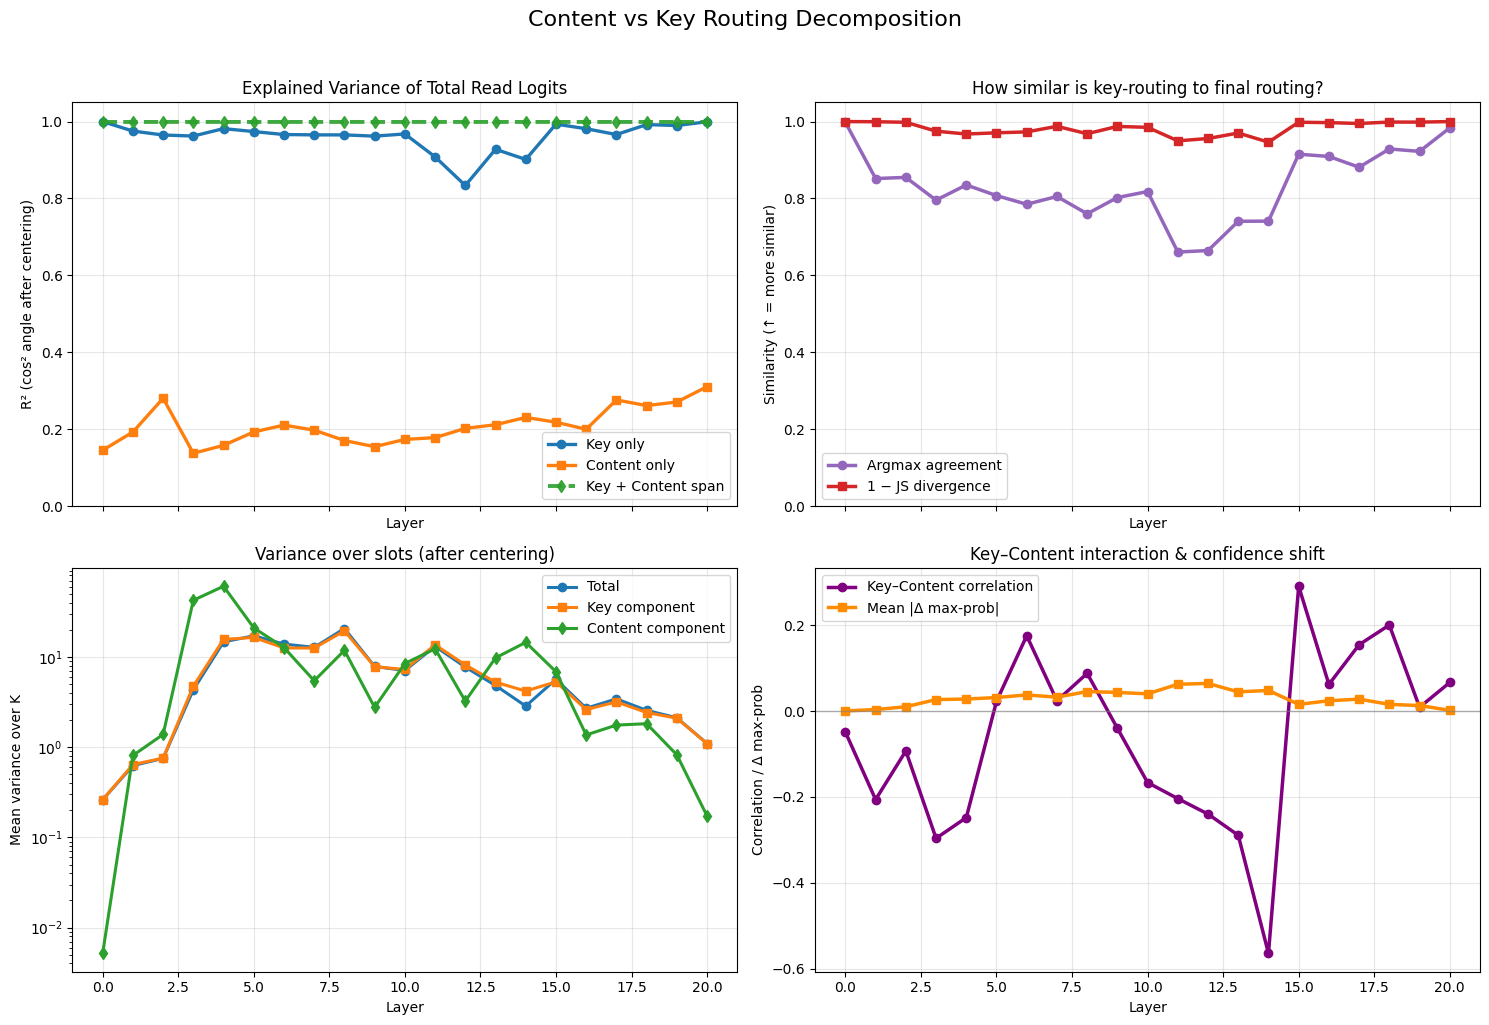

In [107]:


#@title ASA Analysis 2 (Corrected): Content vs Key routing decomposition + Visuals

import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ────────────────────────────────────────────────────────────────
#   (your original functions — unchanged)
# ────────────────────────────────────────────────────────────────

@torch.no_grad()
def _ensure_bhtk(x, name):
    if x is None:
        return None
    if x.dim() != 4:
        raise ValueError(f"{name} expected 4D [B,H,T,K], got {tuple(x.shape)}")
    return x

@torch.no_grad()
def _maybe_fix_shape(info, key_name, want_T=None):
    x = info.get(key_name, None)
    if x is None:
        return None, False
    x = x.to(torch.float32)
    partial = False
    if want_T is not None and x.shape[-2] != want_T:
        partial = True
    return x, partial

@torch.no_grad()
def content_key_breakdown_correct(model, xb, yb, attention_mask=None, eps=1e-8):
    model.eval()
    logits, infos = model(xb, attention_mask=attention_mask, return_info=True)
    base_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), yb.view(-1)).item()

    B, T = xb.shape[0], xb.shape[1]

    rows = []
    any_partial = False

    for li, info in enumerate(infos):
        key, partial_k = _maybe_fix_shape(info, "read_logits_key", want_T=T)
        tot, partial_t = _maybe_fix_shape(info, "read_logits", want_T=T)
        content, partial_c = _maybe_fix_shape(info, "read_logits_content", want_T=T)

        partial = partial_k or partial_t or partial_c
        any_partial = any_partial or partial

        if key is None or tot is None:
            continue  # skip layers without data

        B2, H, TT, K = tot.shape

        def centerK(z):
            return z - z.mean(dim=-1, keepdim=True)

        key_c = centerK(key)
        tot_c = centerK(tot)
        cont_c = centerK(content) if content is not None else None

        var_tot = tot_c.var(dim=-1, unbiased=False).mean().item()
        var_key = key_c.var(dim=-1, unbiased=False).mean().item()
        var_cont = cont_c.var(dim=-1, unbiased=False).mean().item() if cont_c is not None else float("nan")

        if cont_c is not None:
            cov_kc = (key_c * cont_c).mean(dim=-1).mean().item()
            corr_kc = cov_kc / (math.sqrt(var_key + eps) * math.sqrt(var_cont + eps))
        else:
            cov_kc = corr_kc = float("nan")

        def cos2(a, b):
            an = a.norm(dim=-1).clamp_min(eps)
            bn = b.norm(dim=-1).clamp_min(eps)
            c = (a * b).sum(dim=-1) / (an * bn)
            return (c * c)

        r2_key = cos2(tot_c, key_c).mean().item()

        if cont_c is not None:
            r2_cont = cos2(tot_c, cont_c).mean().item()

            kk = (key_c * key_c).sum(dim=-1)
            cc = (cont_c * cont_c).sum(dim=-1)
            kc = (key_c * cont_c).sum(dim=-1)
            kt = (key_c * tot_c).sum(dim=-1)
            ct = (cont_c * tot_c).sum(dim=-1)

            det = (kk * cc - kc * kc).clamp_min(eps)
            alpha = (cc * kt - kc * ct) / det
            beta = (-kc * kt + kk * ct) / det

            proj = alpha.unsqueeze(-1) * key_c + beta.unsqueeze(-1) * cont_c
            r2_span = (proj.norm(dim=-1).pow(2) / tot_c.norm(dim=-1).clamp_min(eps).pow(2)).mean().item()
        else:
            r2_cont = r2_span = float("nan")

        pk = torch.softmax(key / 1.0, dim=-1)
        pt = torch.softmax(tot / 1.0, dim=-1)

        m = 0.5 * (pk + pt)
        js = 0.5 * (F.kl_div(m.log(), pk, reduction="none").sum(dim=-1) +
                    F.kl_div(m.log(), pt, reduction="none").sum(dim=-1))
        js_mean = js.mean().item()

        agree = (key.argmax(dim=-1) == tot.argmax(dim=-1)).float().mean().item()
        maxp_delta = (pt.max(dim=-1).values - pk.max(dim=-1).values).abs().mean().item()

        rows.append({
            "layer": li,
            "base_loss": base_loss,
            "partial_T": partial,
            "T_seen": TT,
            "var_total_overK": var_tot,
            "var_key_overK": var_key,
            "var_content_overK": var_cont,
            "corr_key_content_overK": corr_kc,
            "r2_total_explained_by_key": r2_key,
            "r2_total_explained_by_content": r2_cont,
            "r2_total_explained_by_span_key_content": r2_span,
            "argmax_agreement_key_vs_total": agree,
            "js_divergence_key_total": js_mean,
            "mean_abs_delta_maxprob": maxp_delta,
        })

    if any_partial:
        print("⚠ Warning: Some layers have partial T (likely chunk logging). "
              "Results may underestimate full-sequence effects.\n")

    return rows


# ────────────────────────────────────────────────────────────────
#                   Visualization Functions
# ────────────────────────────────────────────────────────────────

def plot_content_key_decomposition(rows, figsize=(15, 10)):
    df = pd.DataFrame(rows)
    layers = df["layer"]

    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    axes = axes.flat

    # 1. Explained variance (R²)
    axes[0].plot(layers, df["r2_total_explained_by_key"], 'o-', color='C0', label='Key only', lw=2.4)
    axes[0].plot(layers, df["r2_total_explained_by_content"], 's-', color='C1', label='Content only', lw=2.4)
    axes[0].plot(layers, df["r2_total_explained_by_span_key_content"], 'd--', color='C2', label='Key + Content span',
                 lw=2.8, alpha=0.9)
    axes[0].set_title("Explained Variance of Total Read Logits")
    axes[0].set_ylabel("R² (cos² angle after centering)")
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # 2. Routing outcome similarity
    axes[1].plot(layers, df["argmax_agreement_key_vs_total"], 'o-', color='C4', label='Argmax agreement', lw=2.5)
    axes[1].plot(layers, 1 - df["js_divergence_key_total"], 's-', color='C3', label='1 − JS divergence', lw=2.5)
    axes[1].set_title("How similar is key-routing to final routing?")
    axes[1].set_ylabel("Similarity (↑ = more similar)")
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # 3. Variance breakdown
    axes[2].plot(layers, df["var_total_overK"], 'o-', color='C0', label='Total', lw=2.2)
    axes[2].plot(layers, df["var_key_overK"], 's-', color='C1', label='Key component', lw=2.2)
    axes[2].plot(layers, df["var_content_overK"], 'd-', color='C2', label='Content component', lw=2.2)
    axes[2].set_title("Variance over slots (after centering)")
    axes[2].set_ylabel("Mean variance over K")
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    # 4. Correlation & max-prob shift
    axes[3].plot(layers, df["corr_key_content_overK"], 'o-', color='purple', label='Key–Content correlation', lw=2.5)
    axes[3].plot(layers, df["mean_abs_delta_maxprob"], 's-', color='darkorange', label='Mean |Δ max-prob|', lw=2.5)
    axes[3].axhline(0, color='gray', lw=1, alpha=0.6)
    axes[3].set_title("Key–Content interaction & confidence shift")
    axes[3].set_ylabel("Correlation / Δ max-prob")
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()

    for ax in axes:
        ax.set_xlabel("Layer")

    fig.suptitle("Content vs Key Routing Decomposition", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# ────────────────────────────────────────────────────────────────
#                          Run & Visualize
# ────────────────────────────────────────────────────────────────

print("Computing content vs key routing decomposition...\n")

rows = content_key_breakdown_correct(model, xb, yb, attention_mask=None)

print("Per-layer results:")
for r in rows:
    print(f"Layer {r['layer']:2d}: "
          f"R²(key)={r['r2_total_explained_by_key']:.3f}  "
          f"R²(content)={r['r2_total_explained_by_content']:.3f}  "
          f"R²(span)={r['r2_total_explained_by_span_key_content']:.3f}  |  "
          f"argmax agree={r['argmax_agreement_key_vs_total']:.3f}  "
          f"JS={r['js_divergence_key_total']:.4f}")

print("\nPlotting summary...\n")

plot_content_key_decomposition(rows)

Computing slot memory timescales...

=== Slot memory timescale summary (per layer) ===


layer  mean_tail_half_life_tokens  p25_tail_half_life_tokens  \
0       0                  125.438271                       32.0   
1       1                   44.492352                        6.0   
2       2                   52.211548                        9.0   
3       3                   84.320030                       20.0   
4       4                   83.483803                       22.0   
5       5                   84.653770                       22.0   
6       6                   83.331177                       20.0   
7       7                   81.644897                       20.0   
8       8                   77.728516                       21.0   
9       9                   90.438515                       25.0   
10     10                  100.708412                       21.0   
11     11                   97.831505                       26.0   
12     12                   93.154213                       20.0   
13     13                  123.606972                       25.0   
14     14                  115.600060                       25.0   
15     15                  172.110352                       50.0   
16     16                  166.283081                       42.0   
17     17                  144.710526                       33.0   
18     18                  136.871658                       24.0   
19     19                  147.597168                       37.0   
20     20                  116.374306                       23.0   

    median_tail_half_life_tokens  p75_tail_half_life_tokens    mean_ess  \
0                           88.0                      196.0  244.522339   
1                           23.0                       58.0   57.638454   
2                           25.0                       72.0   81.204407   
3                           49.0                      124.0  114.560509   
4                           50.0                      126.0  139.831741   
5                           48.0                      120.0  125.987190   
6                           53.0                      119.0  103.233429   
7                           52.0                      120.0   87.916359   
8                           54.0                      101.0   67.167580   
9                           64.0                      117.0   53.975002   
10                          62.0                      136.0   61.545059   
11                          68.0                      142.0   68.787224   
12                          51.0                      146.0   52.695847   
13                          70.0                      190.0   58.164795   
14                          68.0                      181.0   64.686157   
15                         138.0                      262.0   52.073547   
16                         127.0                      250.0   60.102951   
17                          95.0                      234.0   53.193375   
18                          75.0                      207.0   59.665787   
19                         104.0                      217.0   83.735481   
20                          68.0                      179.0   87.748741   

    median_ess  
0   136.152603  
1    19.176577  
2    31.262293  
3    60.094353  
4    67.813774  
5    52.532948  
6    31.410809  
7    27.531200  
8    16.322374  
9    16.618008  
10   16.651701  
11   19.529985  
12   15.333204  
13   19.446440  
14   21.407133  
15   23.305067  
16   21.318027  
17   22.875147  
18   20.551775  
19   34.753807  
20   39.121521

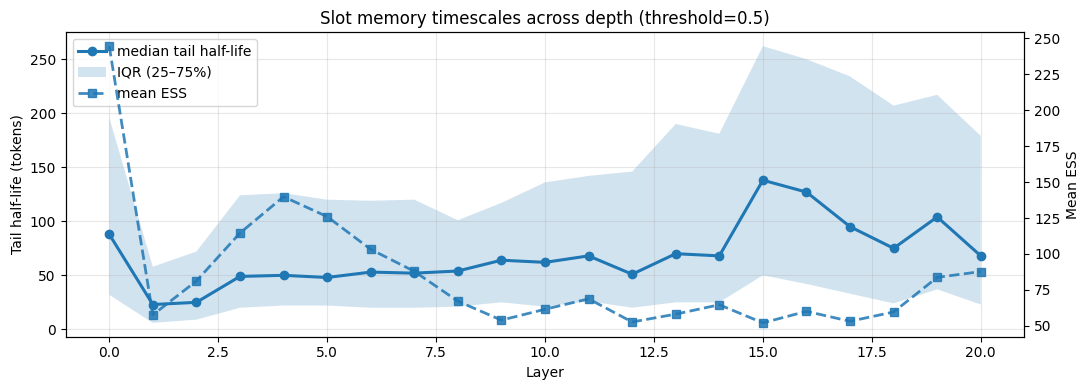

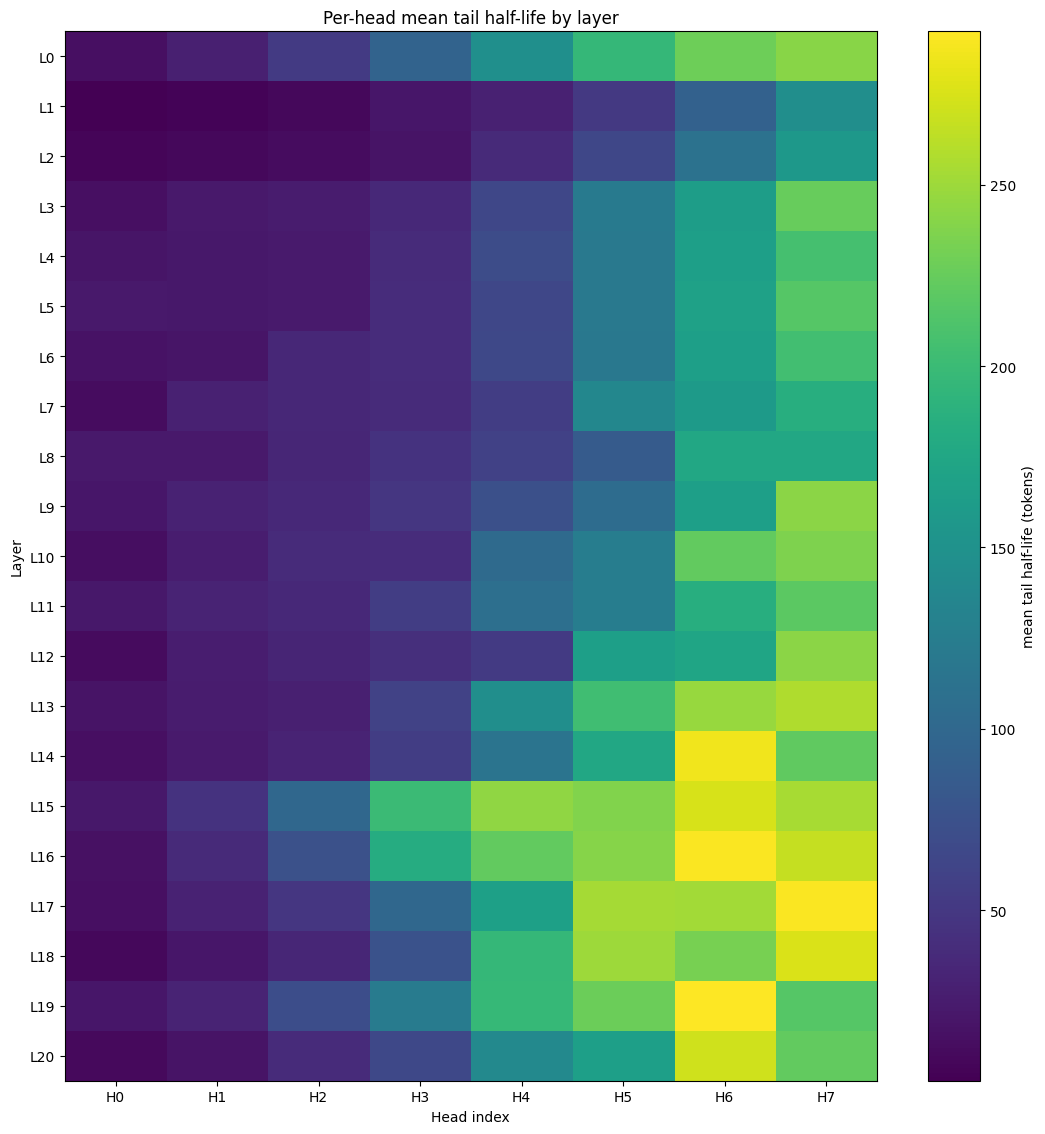


=== Heads with largest mean tail half-life (across layers) ===


head     HL_mean     HL_std    ESS_mean
0     7  224.018738  36.131924  181.354111
1     6  206.146454  57.555962  170.896164
2     5  156.614624  60.080143  129.162613
3     4  112.237076  62.546413   80.479713
4     3   67.696457  47.417015   53.404873


=== Heads with smallest mean tail half-life (across layers) ===


head     HL_mean     HL_std   ESS_mean
3     4  112.237076  62.546413  80.479713
4     3   67.696457  47.417015  53.404873
5     2   39.267036  20.448042  31.993059
6     1   25.198757   8.421088  18.427032
7     0   15.522259   5.224335  11.781880


Scalar checks:
Layers analyzed: 21  |  heads: 8  |  slots(K): 16
Overall mean tail half-life: 105.84 tokens
Overall mean ESS:           84.69


In [108]:

#@title Slot Half-Life (ASA-meaningful) — curated + rigorous summary (REPLACEMENT CELL)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ────────────────────────────────────────────────────────────────
# Core metrics (unchanged semantics)
# ────────────────────────────────────────────────────────────────

@torch.no_grad()
def _tail_mass_half_life_from_logp(logp: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    """
    Smallest n such that tail mass (from most-recent backwards) >= threshold.
    """
    thr = float(threshold)
    p = logp.exp()
    tail = torch.flip(p, dims=[-1]).cumsum(dim=-1)
    hl = (tail < thr).sum(dim=-1).to(torch.int32) + 1
    return hl

@torch.no_grad()
def _ess_from_logp(logp: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    p = logp.exp()
    denom = (p * p).sum(dim=-1).clamp_min(eps)
    return 1.0 / denom

@torch.no_grad()
def slot_memory_timescale_from_write_logits(
    write_logits: torch.Tensor,
    t_points: torch.Tensor,
    threshold: float = 0.5,
):
    """
    write_logits: [B,H,K,T]
    Returns:
      tail_hl: [B,H,K,P] int32
      ess:     [B,H,K,P] float32
    """
    B, H, K, T = write_logits.shape
    t_points = t_points.to(write_logits.device)
    P = int(t_points.numel())

    tail_hl_out = torch.empty((B, H, K, P), device=write_logits.device, dtype=torch.int32)
    ess_out     = torch.empty((B, H, K, P), device=write_logits.device, dtype=torch.float32)

    for pi, t in enumerate(t_points.tolist()):
        t = int(t)
        L = t + 1
        logits = write_logits[..., :L]
        logp = F.log_softmax(logits, dim=-1)
        tail_hl_out[..., pi] = _tail_mass_half_life_from_logp(logp, threshold=threshold)
        ess_out[..., pi]     = _ess_from_logp(logp)

    return tail_hl_out, ess_out

@torch.no_grad()
def slot_half_life_analysis(
    model,
    xb: torch.Tensor,
    attention_mask=None,
    threshold: float = 0.5,
    n_timepoints: int = 32,
    min_t: int = 32,
    max_t: int = None,
    per_head: bool = True,
):
    """
    Returns dict with:
      - per_layer: list of layer records with mean/median + optional per-head means
      - raw_t_points: sampled t_points
    """
    model.eval()
    device = xb.device
    _, infos = model(xb, attention_mask=attention_mask, return_info=True)

    T = xb.shape[1]
    if max_t is None:
        max_t = T - 1
    max_t = min(int(max_t), T - 1)
    min_t = min(int(min_t), max_t)

    t_points = torch.linspace(min_t, max_t, steps=int(n_timepoints), device=device).round().to(torch.long)
    t_points = torch.unique(t_points)

    out = {
        "threshold": float(threshold),
        "t_points": t_points.detach().cpu().tolist(),
        "per_layer": [],
    }

    for layer, info in enumerate(infos):
        if info is None or info.get("write_logits", None) is None:
            continue

        wl = info["write_logits"].to(device=device, dtype=torch.float32)  # [B,H,K,T]
        B, H, K, T2 = wl.shape
        if T2 != T:
            print(f"Warning: Layer {layer} write_logits T={T2} != xb T={T} (skipping layer).")
            continue

        tail_hl, ess = slot_memory_timescale_from_write_logits(wl, t_points, threshold=threshold)
        hl_f = tail_hl.to(torch.float32)

        layer_rec = {
            "layer": int(layer),
            "mean_tail_half_life_tokens": float(hl_f.mean().cpu().item()),
            "p25_tail_half_life_tokens":  float(torch.quantile(hl_f.flatten(), 0.25).cpu().item()),
            "median_tail_half_life_tokens": float(hl_f.median().cpu().item()),
            "p75_tail_half_life_tokens":  float(torch.quantile(hl_f.flatten(), 0.75).cpu().item()),
            "mean_ess": float(ess.mean().cpu().item()),
            "median_ess": float(ess.median().cpu().item()),
            "B": int(B), "H": int(H), "K": int(K), "T": int(T),
        }

        if per_head:
            # mean over (B,K,P) -> per head [H]
            layer_rec["per_head_mean_tail_half_life"] = hl_f.mean(dim=(0,2,3)).detach().cpu().numpy()
            layer_rec["per_head_mean_ess"]            = ess.mean(dim=(0,2,3)).detach().cpu().numpy()

        out["per_layer"].append(layer_rec)

    return out

# ────────────────────────────────────────────────────────────────
# Curated plots & tables
#   - 1 summary figure: HL (median with IQR) + ESS mean (secondary axis)
#   - 1 heatmap: per-head half-life by layer
#   - 1 table: top/bottom heads by half-life (aggregated across layers)
# ────────────────────────────────────────────────────────────────

def _build_layer_df(res):
    df = pd.DataFrame(res["per_layer"]).sort_values("layer").reset_index(drop=True)
    return df

def _stack_per_head(res, key):
    # returns mat [n_layers, H] aligned to df order
    layers = [r["layer"] for r in res["per_layer"]]
    layers_sorted_idx = np.argsort(layers)
    recs = [res["per_layer"][i] for i in layers_sorted_idx]
    mat = np.stack([r[key] for r in recs], axis=0)
    layers_sorted = [r["layer"] for r in recs]
    return layers_sorted, mat

def plot_half_life_summary_curated(df, threshold):
    layers = df["layer"].to_numpy()
    med = df["median_tail_half_life_tokens"].to_numpy()
    p25 = df["p25_tail_half_life_tokens"].to_numpy()
    p75 = df["p75_tail_half_life_tokens"].to_numpy()
    ess = df["mean_ess"].to_numpy()

    fig, ax = plt.subplots(1, 1, figsize=(11,4))

    ax.plot(layers, med, "o-", lw=2.2, label="median tail half-life")
    ax.fill_between(layers, p25, p75, alpha=0.2, label="IQR (25–75%)")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Tail half-life (tokens)")
    ax.grid(True, alpha=0.3)

    ax2 = ax.twinx()
    ax2.plot(layers, ess, "s--", alpha=0.85, lw=2.0, label="mean ESS")
    ax2.set_ylabel("Mean ESS")

    # one combined legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="best", frameon=True)

    ax.set_title(f"Slot memory timescales across depth (threshold={threshold})")
    plt.tight_layout()
    plt.show()

def plot_per_head_hl_heatmap(layers, hl_mat):
    plt.figure(figsize=(11, 0.45*len(layers)+2))
    plt.imshow(hl_mat, aspect="auto")
    plt.yticks(range(len(layers)), [f"L{l}" for l in layers])
    plt.xticks(range(hl_mat.shape[1]), [f"H{h}" for h in range(hl_mat.shape[1])])
    plt.colorbar(label="mean tail half-life (tokens)")
    plt.title("Per-head mean tail half-life by layer")
    plt.xlabel("Head index")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

def summarize_heads_across_layers(layers, hl_mat, ess_mat, topk=5):
    """
    hl_mat, ess_mat: [n_layers,H]
    Returns a compact table ranking heads by across-layer mean HL.
    """
    hl_mean = hl_mat.mean(axis=0)
    hl_std  = hl_mat.std(axis=0)
    ess_mean = ess_mat.mean(axis=0)

    dfh = pd.DataFrame({
        "head": np.arange(hl_mat.shape[1], dtype=np.int32),
        "HL_mean": hl_mean,
        "HL_std": hl_std,
        "ESS_mean": ess_mean,
    }).sort_values("HL_mean", ascending=False).reset_index(drop=True)

    return dfh.head(topk), dfh.tail(topk), dfh

# ────────────────────────────────────────────────────────────────
# Run + curated outputs
# ────────────────────────────────────────────────────────────────

print("Computing slot memory timescales...\n")

res_hl = slot_half_life_analysis(
    model,
    xb,
    attention_mask=None,
    threshold=0.5,
    n_timepoints=48,   # enough density for stable estimates
    min_t=32,
    max_t=None,
    per_head=True,
)

df = _build_layer_df(res_hl)

print("=== Slot memory timescale summary (per layer) ===")
display(df[[
    "layer",
    "mean_tail_half_life_tokens",
    "p25_tail_half_life_tokens",
    "median_tail_half_life_tokens",
    "p75_tail_half_life_tokens",
    "mean_ess",
    "median_ess",
]])

# 1) Summary figure (the one you actually want in a report)
plot_half_life_summary_curated(df, threshold=res_hl["threshold"])

# 2) Per-head heatmap (compact and comparative)
layers_sorted, hl_mat = _stack_per_head(res_hl, "per_head_mean_tail_half_life")
_, ess_mat = _stack_per_head(res_hl, "per_head_mean_ess")

plot_per_head_hl_heatmap(layers_sorted, hl_mat)

# 3) Small “who are the memory heads?” table
top, bottom, dfh = summarize_heads_across_layers(layers_sorted, hl_mat, ess_mat, topk=5)
print("\n=== Heads with largest mean tail half-life (across layers) ===")
display(top)
print("\n=== Heads with smallest mean tail half-life (across layers) ===")
display(bottom)

# Optional: if you want a single scalar summary for write behavior per layer:
print("\nScalar checks:")
print(f"Layers analyzed: {len(df)}  |  heads: {int(df['H'].iloc[0])}  |  slots(K): {int(df['K'].iloc[0])}")
print(f"Overall mean tail half-life: {df['mean_tail_half_life_tokens'].mean():.2f} tokens")
print(f"Overall mean ESS:           {df['mean_ess'].mean():.2f}")

=== Second-order parameters (per layer) ===


layer  slotspace_gate  content_read_gamma
0       0        0.061273            0.037825
1       1        0.048781            0.070871
2       2        0.051638            0.103201
3       3        0.057509            0.098956
4       4        0.061468            0.117580
5       5        0.066144            0.163813
6       6        0.065367            0.191333
7       7        0.064881            0.171205
8       8        0.061735            0.220713
9       9        0.079000            0.229903
10     10        0.063496            0.180588
11     11        0.074082            0.285384
12     12        0.065395            0.468704
13     13        0.078059            0.246993
14     14        0.074935            0.295325
15     15        0.098685            0.086312
16     16        0.062645            0.184327
17     17        0.071811            0.225001
18     18        0.086964            0.127904
19     19        0.072756            0.149743
20     20        0.052499            0.046839

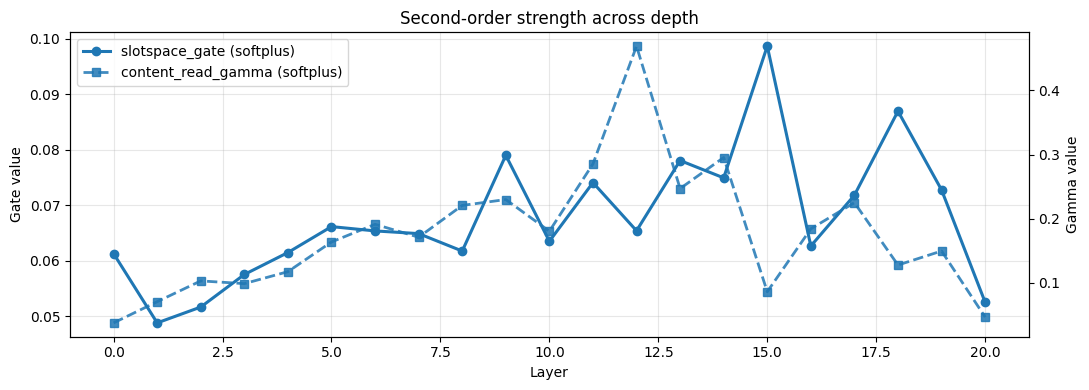


=== Logged delta norms (per layer) ===


layer  slotspace_delta_norm
0       0             15.112902
1       1             37.538544
2       2             38.041954
3       3             33.611786
4       4             34.078236
5       5             17.709337
6       6             20.879507
7       7             20.210354
8       8             24.534849
9       9             24.276134
10     10             28.726805
11     11             28.287430
12     12             43.572735
13     13             31.480944
14     14             36.957298
15     15             28.505190
16     16             43.859436
17     17             50.031071
18     18             31.538908
19     19             30.566620
20     20             38.944630

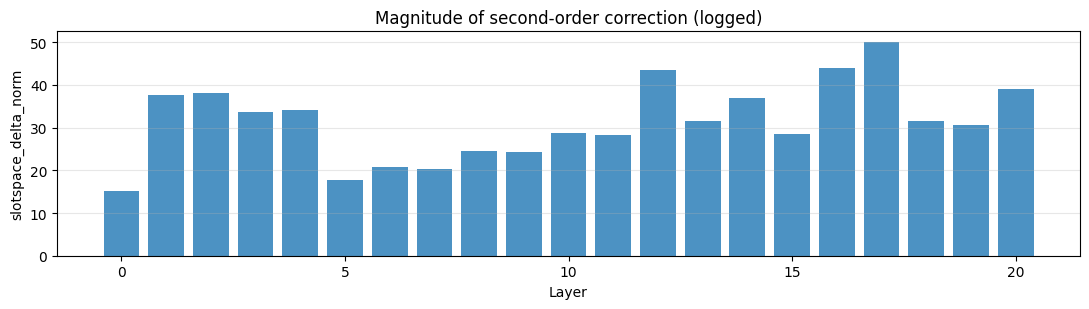


=== Merged analysis table (second-order + behavior) ===


layer  slotspace_gate  content_read_gamma  slotspace_delta_norm  \
0       0        0.061273            0.037825             15.112902   
1       1        0.048781            0.070871             37.538544   
2       2        0.051638            0.103201             38.041954   
3       3        0.057509            0.098956             33.611786   
4       4        0.061468            0.117580             34.078236   
5       5        0.066144            0.163813             17.709337   
6       6        0.065367            0.191333             20.879507   
7       7        0.064881            0.171205             20.210354   
8       8        0.061735            0.220713             24.534849   
9       9        0.079000            0.229903             24.276134   
10     10        0.063496            0.180588             28.726805   
11     11        0.074082            0.285384             28.287430   
12     12        0.065395            0.468704             43.572735   
13     13        0.078059            0.246993             31.480944   
14     14        0.074935            0.295325             36.957298   
15     15        0.098685            0.086312             28.505190   
16     16        0.062645            0.184327             43.859436   
17     17        0.071811            0.225001             50.031071   
18     18        0.086964            0.127904             31.538908   
19     19        0.072756            0.149743             30.566620   
20     20        0.052499            0.046839             38.944630   

    mean_tail_half_life_tokens  median_tail_half_life_tokens    mean_ess  \
0                   125.438271                          88.0  244.522339   
1                    44.492352                          23.0   57.638454   
2                    52.211548                          25.0   81.204407   
3                    84.320030                          49.0  114.560509   
4                    83.483803                          50.0  139.831741   
5                    84.653770                          48.0  125.987190   
6                    83.331177                          53.0  103.233429   
7                    81.644897                          52.0   87.916359   
8                    77.728516                          54.0   67.167580   
9                    90.438515                          64.0   53.975002   
10                  100.708412                          62.0   61.545059   
11                   97.831505                          68.0   68.787224   
12                   93.154213                          51.0   52.695847   
13                  123.606972                          70.0   58.164795   
14                  115.600060                          68.0   64.686157   
15                  172.110352                         138.0   52.073547   
16                  166.283081                         127.0   60.102951   
17                  144.710526                          95.0   53.193375   
18                  136.871658                          75.0   59.665787   
19                  147.597168                         104.0   83.735481   
20                  116.374306                          68.0   87.748741   

    median_ess  mean_inertia_lag1  mean_inertia_mean  mean_inertia_slope  \
0   136.152603           0.891839           0.887195        3.099605e-06   
1    19.176577           0.841761           0.840025        4.261519e-07   
2    31.262293           0.920669           0.836184       -2.414635e-03   
3    60.094353           0.895852           0.699945       -4.286756e-03   
4    67.813774           0.906029           0.699126       -4.009692e-03   
5    52.532948           0.824343           0.593187       -3.542264e-03   
6    31.410809           0.863232           0.573096       -5.040905e-03   
7    27.531200           0.822746           0.527724       -5.096164e-03   
8    16.322374           0.837475           0.551632       -4.063284e-03   
9    16.


=== PAPER TABLE: second-order params vs behavior (Pearson r with bootstrap CI) ===


x(second_order)                   y(behavior)  n_layers  pearson_r  \
18    content_read_gamma             mean_inertia_mean        21  -0.583918   
21    content_read_gamma                  mean_tok_ent        21  -0.505668   
16    content_read_gamma                    median_ess        21  -0.503628   
22    content_read_gamma                mean_eff_slots        21  -0.476501   
23    content_read_gamma                mean_top4_mass        21   0.464878   
15    content_read_gamma                      mean_ess        21  -0.459144   
25    content_read_gamma                mean_write_ess        21  -0.459144   
19    content_read_gamma            mean_inertia_slope        21  -0.426535   
14    content_read_gamma  median_tail_half_life_tokens        21  -0.065018   
20    content_read_gamma         mean_inertia_half_lag        21  -0.057802   
13    content_read_gamma    mean_tail_half_life_tokens        21  -0.016426   
24    content_read_gamma     mean_write_tail_half_life        21  -0.016426   
17    content_read_gamma             mean_inertia_lag1        21   0.002058   
28  slotspace_delta_norm                      mean_ess        21  -0.520216   
38  slotspace_delta_norm                mean_write_ess        21  -0.520216   
29  slotspace_delta_norm                    median_ess        21  -0.406055   
32  slotspace_delta_norm            mean_inertia_slope        21   0.373163   
30  slotspace_delta_norm             mean_inertia_lag1        21  -0.337869   
37  slotspace_delta_norm     mean_write_tail_half_life        21   0.195094   
26  slotspace_delta_norm    mean_tail_half_life_tokens        21   0.195094   
34  slotspace_delta_norm                  mean_tok_ent        21   0.172968   
36  slotspace_delta_norm                mean_top4_mass        21  -0.151773   
31  slotspace_delta_norm             mean_inertia_mean        21   0.128633   
27  slotspace_delta_norm  median_tail_half_life_tokens        21   0.108969   
35  slotspace_delta_norm                mean_eff_slots        21   0.104516   
33  slotspace_delta_norm         mean_inertia_half_lag        21  -0.030429   
11        slotspace_gate     mean_write_tail_half_life        21   0.637722   
0         slotspace_gate    mean_tail_half_life_tokens        21   0.637722   
1         slotspace_gate  median_tail_half_life_tokens        21   0.615909   
9         slotspace_gate                mean_eff_slots        21  -0.523819   
10        slotspace_gate                mean_top4_mass        21   0.472262   
8         slotspace_gate                  mean_tok_ent        21  -0.470125   
7         slotspace_gate         mean_inertia_half_lag        21  -0.417773   
5         slotspace_gate             mean_inertia_mean        21  -0.401417   
4         slotspace_gate             mean_inertia_lag1        21  -0.366116   
12        slotspace_gate                mean_write_ess        21  -0.317232   
2         slotspace_gate                      mean_ess        21  -0.317232   
3         slotspace_gate                    median_ess        21  -0.268437   
6         slotspace_gate            mean_inertia_slope        21   0.070622   

             CI_95  
18  [-0.78, -0.36]  
21  [-0.78, -0.14]  
16  [-0.72, -0.31]  
22  [-0.78, -0.07]  
23    [0.04, 0.77]  
15  [-0.69, -0.14]  
25  [-0.69, -0.14]  
19  [-0.69, -0.12]  
14   [-0.40, 0.39]  
20   [-0.43, 0.41]  
13   [-0.36, 0.38]  
24   [-0.36, 0.38]  
17   [-0.37, 0.36]  
28  [-0.73, -0.04]  
38  [-0.73, -0.04]  
29   [-0.68, 0.17]  
32   [-0.10, 0.76]  
30   [-0.66, 0.07]  
37   [-0.24, 0.60]  
26   [-0.24, 0.60]  
34   [-0.34, 0.72]  
36   [-0.72, 0.36]  
31   [-0.38, 0.69]  
27   [-0.36, 0.51]  
35   [-0.40, 0.70]  
33   [-0.51, 0.34]  
11    [0.22, 0.88]  
0     [0.22, 0.88]  
1     [0.16, 0.88]  
9   [-0.74, -0.18]  
10    [0.06, 0.70]  
8   [-0.71, -0.05]  
7   [-0.72, -0.02]  
5    [-0.70, 0.03]  
4    [-0.70, 0.05]  
12  [-0.58, -0.10]  
2   [-0.58, -0.10]  
3   [-0.51, -0.09]  
6    [-0.41, 0.52]

In [109]:

#@title Second-Order Slotspace Attention (FINAL, curated, story-completing)

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------

def _softplus_scalar(x: float) -> float:
    return float(F.softplus(torch.tensor(x)).item())

def _bootstrap_corr_ci(x, y, n_boot=5000, seed=0, alpha=0.05):
    """
    Pearson r + bootstrap CI.
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    if x.std() < 1e-12 or y.std() < 1e-12:
        return np.nan, (np.nan, np.nan)

    r0 = float(np.corrcoef(x, y)[0,1])
    n = len(x)
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        xb = x[idx]; yb = y[idx]
        if xb.std() < 1e-12 or yb.std() < 1e-12:
            continue
        boots.append(float(np.corrcoef(xb, yb)[0,1]))
    if len(boots) == 0:
        return r0, (np.nan, np.nan)
    lo = float(np.quantile(boots, alpha/2))
    hi = float(np.quantile(boots, 1-alpha/2))
    return r0, (lo, hi)

# ----------------------------
# 1) Extract params per layer
# ----------------------------

def extract_second_order_params(model):
    """
    Returns DataFrame with columns:
      layer, slotspace_gate, content_read_gamma
    """
    rows = []
    for layer_idx, block in enumerate(model.blocks):
        attn = getattr(block, "attn", None)
        if attn is None:
            rows.append({"layer": layer_idx, "slotspace_gate": np.nan, "content_read_gamma": np.nan})
            continue

        # slotspace gate
        gate = np.nan
        if hasattr(attn, "_slotspace_gate_raw") and (attn._slotspace_gate_raw is not None):
            raw = float(attn._slotspace_gate_raw.detach().cpu().item())
            gate = _softplus_scalar(raw)

        # content gamma (clamped if max provided)
        gamma = np.nan
        if hasattr(attn, "_content_read_gamma_raw") and (attn._content_read_gamma_raw is not None):
            raw = float(attn._content_read_gamma_raw.detach().cpu().item())
            gamma = _softplus_scalar(raw)
            max_g = getattr(attn, "content_read_max_gamma", None)
            if (max_g is not None) and (float(max_g) > 0):
                gamma = min(gamma, float(max_g))

        rows.append({"layer": layer_idx, "slotspace_gate": gate, "content_read_gamma": gamma})

    df = pd.DataFrame(rows).dropna().reset_index(drop=True)
    return df

df_so = extract_second_order_params(model)

print("=== Second-order parameters (per layer) ===")
display(df_so)

# ----------------------------
# 2) Main plot (one figure)
# ----------------------------

fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(df_so["layer"], df_so["slotspace_gate"], "o-", lw=2.2, label="slotspace_gate (softplus)")
ax.set_xlabel("Layer")
ax.set_ylabel("Gate value")
ax.grid(True, alpha=0.3)
ax.set_title("Second-order strength across depth")

ax2 = ax.twinx()
ax2.plot(df_so["layer"], df_so["content_read_gamma"], "s--", lw=2.0, alpha=0.85, label="content_read_gamma (softplus)")
ax2.set_ylabel("Gamma value")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc="best", frameon=True)
plt.tight_layout()
plt.show()

# ----------------------------
# 3) Optional: delta_norm from infos (if present)
# ----------------------------

delta_df = None
try:
    _, test_infos = run_with_infos(model, xb)
    delta = []
    if test_infos and (test_infos[0] is not None) and ("slotspace_delta_norm" in test_infos[0]):
        for li, info in enumerate(test_infos):
            if info is None or "slotspace_delta_norm" not in info:
                continue
            dn = info["slotspace_delta_norm"]
            dn = float(dn.detach().cpu().item()) if isinstance(dn, torch.Tensor) else float(dn)
            delta.append((li, dn))
        if len(delta) > 0:
            delta_df = pd.DataFrame(delta, columns=["layer", "slotspace_delta_norm"])
            print("\n=== Logged delta norms (per layer) ===")
            display(delta_df)

            plt.figure(figsize=(11,3.2))
            plt.bar(delta_df["layer"], delta_df["slotspace_delta_norm"], alpha=0.8)
            plt.xlabel("Layer")
            plt.ylabel("slotspace_delta_norm")
            plt.title("Magnitude of second-order correction (logged)")
            plt.grid(True, axis="y", alpha=0.3)
            plt.tight_layout()
            plt.show()
except Exception as e:
    print(f"\n(note) Could not read delta norms from infos: {type(e).__name__}: {e}")

# ----------------------------
# 4) Merge with “behavioral” summaries you already have
#    - from res_hl (slot half-life cell)
#    - from feat_by_layer (head feature bank)
# ----------------------------

# 4a) Half-life summary (if res_hl exists)
df_hl = None
if "res_hl" in globals() and isinstance(res_hl, dict) and ("per_layer" in res_hl):
    df_hl = pd.DataFrame(res_hl["per_layer"])[[
        "layer",
        "mean_tail_half_life_tokens",
        "median_tail_half_life_tokens",
        "mean_ess",
        "median_ess",
    ]].copy()

# 4b) Routing/memory feature summaries from feat_by_layer (if exists)
df_feat = None
if "feat_by_layer" in globals() and "feature_names" in globals() and feat_by_layer is not None:
    rows = []
    for l, X in enumerate(feat_by_layer):
        if X is None:
            continue
        X = np.asarray(X)
        rec = {"layer": int(l)}
        # layer-level mean of each feature across heads
        for j, nm in enumerate(feature_names):
            rec[f"mean_{nm}"] = float(X[:, j].mean())
        rows.append(rec)
    if len(rows) > 0:
        df_feat = pd.DataFrame(rows)

# Merge all available
df_merge = df_so.copy()
if delta_df is not None:
    df_merge = df_merge.merge(delta_df, on="layer", how="left")
if df_hl is not None:
    df_merge = df_merge.merge(df_hl, on="layer", how="left")
if df_feat is not None:
    df_merge = df_merge.merge(df_feat, on="layer", how="left")

print("\n=== Merged analysis table (second-order + behavior) ===")
display(df_merge)

# ----------------------------
# 5) Paper table: correlations (with bootstrap CIs)
# ----------------------------

targets = []
# Always include these
targets += ["slotspace_gate", "content_read_gamma"]
# Optional: if present
if "slotspace_delta_norm" in df_merge.columns:
    targets += ["slotspace_delta_norm"]

# Candidate behavioral metrics (include only if present)
candidates = []
for col in [
    # memory timescale summaries
    "mean_tail_half_life_tokens", "median_tail_half_life_tokens", "mean_ess", "median_ess",
    # feature bank summaries (layer means)
    "mean_inertia_lag1", "mean_inertia_mean", "mean_inertia_slope", "mean_inertia_half_lag",
    "mean_tok_ent", "mean_eff_slots", "mean_top4_mass",
    "mean_write_tail_half_life", "mean_write_ess",
]:
    if col in df_merge.columns:
        candidates.append(col)

corr_rows = []
for t in targets:
    for c in candidates:
        d = df_merge[[t, c]].dropna()
        if len(d) < 4:
            continue
        r, (lo, hi) = _bootstrap_corr_ci(d[t].to_numpy(), d[c].to_numpy(), seed=SEED if "SEED" in globals() else 0)
        corr_rows.append({
            "x(second_order)": t,
            "y(behavior)": c,
            "n_layers": int(len(d)),
            "pearson_r": r,
            "CI_95": f"[{lo:.2f}, {hi:.2f}]",
        })

df_corr = pd.DataFrame(corr_rows)
if len(df_corr) == 0:
    print("\n(no correlations computed — missing behavioral columns or not enough layers)")
else:
    # rank by absolute effect size
    df_corr["abs_r"] = df_corr["pearson_r"].abs()
    df_corr = df_corr.sort_values(["x(second_order)", "abs_r"], ascending=[True, False]).drop(columns=["abs_r"])
    print("\n=== PAPER TABLE: second-order params vs behavior (Pearson r with bootstrap CI) ===")
    display(df_corr)

In [110]:


#@title Head Clustering + Head Alignment (Hungarian) — utilities

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# Small helpers
# --------------------------

def _cos_sim_matrix(A: np.ndarray, B: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    # A: [H,D], B: [H,D] (or [H2,D])
    An = A / (np.linalg.norm(A, axis=-1, keepdims=True) + eps)
    Bn = B / (np.linalg.norm(B, axis=-1, keepdims=True) + eps)
    return An @ Bn.T  # [H,H2]

def _safe_softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / (np.sum(ex, axis=axis, keepdims=True) + 1e-12)

def _entropy(p, axis=-1, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=axis)

def _effective_support(p, axis=-1, eps=1e-12):
    # exp(entropy) is a nice "effective count"
    return np.exp(_entropy(p, axis=axis, eps=eps))

def _topk_mass(p, k=4, axis=-1):
    part = np.partition(p, -k, axis=axis)
    topk = part.take(indices=range(p.shape[axis]-k, p.shape[axis]), axis=axis)
    return np.sum(topk, axis=axis)

# --------------------------
# Routing inertia per head
# --------------------------

@torch.no_grad()
def routing_inertia_per_head(t2a: torch.Tensor, max_lag: int = 64, eps: float = 1e-8) -> torch.Tensor:
    """
    t2a: [B,H,T,K] probabilities
    returns: [H,L] where L=min(max_lag,T-1) mean over (B,T')
    """
    B,H,T,K = t2a.shape
    L = int(min(max_lag, T-1))
    p = t2a.float()
    # normalize over K for cosine
    p = p / (p.norm(dim=-1, keepdim=True).clamp_min(eps))
    # windows: [B,H,T-L,K,L+1] -> [B,H,T-L,L+1,K]
    w = p.unfold(dimension=2, size=L+1, step=1).permute(0,1,2,4,3).contiguous()
    a = w[:,:,:,:1,:]          # [B,H,T-L,1,K]
    b = w[:,:,:,1:,:]          # [B,H,T-L,L,K]
    sim = (a*b).sum(dim=-1)    # [B,H,T-L,L]
    return sim.mean(dim=(0,2)) # [H,L]

def summarize_inertia_curve(curve_hl: np.ndarray) -> np.ndarray:
    """
    curve_hl: [H,L] (cos similarity vs lag)
    Returns per-head summary features: [H, 4]
      - lag1
      - mean over lags
      - slope (linear fit)
      - "half-decay lag" where curve falls below (lag1+min)/2
    """
    H,L = curve_hl.shape
    x = np.arange(1, L+1, dtype=np.float32)

    out = np.zeros((H,4), dtype=np.float32)
    for h in range(H):
        y = curve_hl[h].astype(np.float32)

        lag1 = y[0]
        mean = float(y.mean())

        # slope via least squares on (x,y)
        xc = x - x.mean()
        yc = y - y.mean()
        slope = float((xc*yc).sum() / (xc*xc).sum() + 1e-12)

        # half-decay lag heuristic
        y_min = float(y.min())
        thr = 0.5*(lag1 + y_min)
        idx = np.argmax(y < thr)  # 0 if already below
        half_lag = float(x[idx]) if (y < thr).any() else float(L)

        out[h] = [lag1, mean, slope, half_lag]
    return out

# --------------------------
# Per-head memory half-life + ESS from write logits
# --------------------------

@torch.no_grad()
def per_head_half_life_ess(write_logits: torch.Tensor, threshold: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
    """
    write_logits: [B,H,K,T]
    Computes tail half-life and ESS for each (B,H,K,Tpoints) then averages over (B,K,Tpoints).
    Returns:
      hl_h:  [H] float
      ess_h: [H] float
    """
    import math
    B,H,K,T = write_logits.shape
    # choose a set of time points (like your analysis); keep it light
    t_points = torch.linspace(32, T-1, steps=48, device=write_logits.device).round().long().unique()
    hl_acc = []
    ess_acc = []
    for t in t_points.tolist():
        L = int(t)+1
        logits = write_logits[..., :L]                  # [B,H,K,L]
        logp = F.log_softmax(logits, dim=-1)            # over time
        p = logp.exp()

        tail = torch.flip(p, dims=[-1]).cumsum(dim=-1)  # [B,H,K,L]
        hl = (tail < threshold).sum(dim=-1).float() + 1 # [B,H,K]
        ess = 1.0 / (p*p).sum(dim=-1).clamp_min(1e-12)  # [B,H,K]

        hl_acc.append(hl.mean(dim=(0,2)))               # [H]
        ess_acc.append(ess.mean(dim=(0,2)))             # [H]

    hl_h  = torch.stack(hl_acc).mean(dim=0).detach().cpu().numpy()
    ess_h = torch.stack(ess_acc).mean(dim=0).detach().cpu().numpy()
    return hl_h, ess_h

# --------------------------
# Head-level routing distribution stats (from read_weights)
# --------------------------

@torch.no_grad()
def per_head_routing_stats(read_weights: torch.Tensor, topk: int = 4) -> dict:
    """
    read_weights: [B,H,T,K] probabilities
    Returns: dict of per-head arrays [H]
      - tok_ent: entropy over K averaged over (B,T)
      - eff_slots: exp(entropy) averaged over (B,T)
      - topk_mass: average top-k mass over (B,T)
    """
    p = read_weights.detach().float().cpu().numpy()  # [B,H,T,K]
    # average over B,T -> keep head structure
    # ent per token:
    ent = _entropy(p, axis=-1)        # [B,H,T]
    tok_ent_h = ent.mean(axis=(0,2))  # [H]
    eff_h = np.exp(tok_ent_h)         # [H]
    topk_h = _topk_mass(p, k=topk, axis=-1).mean(axis=(0,2))  # [H]
    return {"tok_ent": tok_ent_h.astype(np.float32),
            "eff_slots": eff_h.astype(np.float32),
            "topk_mass": topk_h.astype(np.float32)}

# --------------------------
# Build head feature vectors per layer
# --------------------------

def head_features_for_layer(info: dict,
                            *,
                            max_lag: int = 64,
                            include_inertia: bool = True,
                            include_memory: bool = True,
                            include_routing_stats: bool = True,
                            threshold_hl: float = 0.5) -> tuple[np.ndarray, list[str]]:
    """
    Returns:
      X: [H,D] numpy
      names: list of feature names length D
    """
    feats = []
    names = []

    # read_weights required for inertia + routing stats
    rw = info.get("read_weights", None)

    if include_inertia and (rw is not None):
        curve = routing_inertia_per_head(rw, max_lag=max_lag)   # [H,L]
        curve_np = curve.detach().cpu().numpy()
        summ = summarize_inertia_curve(curve_np)                # [H,4]
        feats.append(summ); names += ["inertia_lag1", "inertia_mean", "inertia_slope", "inertia_half_lag"]

    if include_routing_stats and (rw is not None):
        stats = per_head_routing_stats(rw, topk=4)
        feats.append(stats["tok_ent"][:,None]); names += ["tok_ent"]
        feats.append(stats["eff_slots"][:,None]); names += ["eff_slots"]
        feats.append(stats["topk_mass"][:,None]); names += ["top4_mass"]

    if include_memory:
        wl = info.get("write_logits", None)
        if wl is not None:
            hl_h, ess_h = per_head_half_life_ess(wl, threshold=threshold_hl)  # [H],[H]
            feats.append(hl_h[:,None]);  names += ["write_tail_half_life"]
            feats.append(ess_h[:,None]); names += ["write_ess"]

    if not feats:
        raise ValueError("No features extracted (missing read_weights / write_logits?)")

    X = np.concatenate(feats, axis=1).astype(np.float32)  # [H,D]
    return X, names

def build_head_feature_bank(infos,
                            *,
                            max_lag: int = 64,
                            include_inertia: bool = True,
                            include_memory: bool = True,
                            include_routing_stats: bool = True,
                            threshold_hl: float = 0.5):
    """
    Returns:
      feat_by_layer: list of [H,D]
      feature_names: [D]
    """
    feat_by_layer = []
    feature_names = None
    for li, info in enumerate(infos):
        if info is None:
            feat_by_layer.append(None); continue
        if info.get("read_weights", None) is None and info.get("write_logits", None) is None:
            feat_by_layer.append(None); continue

        X, names = head_features_for_layer(
            info,
            max_lag=max_lag,
            include_inertia=include_inertia,
            include_memory=include_memory,
            include_routing_stats=include_routing_stats,
            threshold_hl=threshold_hl,
        )
        feat_by_layer.append(X)
        if feature_names is None:
            feature_names = names
    return feat_by_layer, feature_names

# --------------------------
# Hungarian alignment over heads (H x H)
# --------------------------

def hungarian_best_cos_heads(A_hd: np.ndarray, B_hd: np.ndarray):
    """
    A_hd, B_hd: [H,D]
    returns:
      diag_cos, best_cos, perm (perm[h] = matched head in B for head h in A)
    """
    from scipy.optimize import linear_sum_assignment
    S = _cos_sim_matrix(A_hd, B_hd)  # [H,H]
    diag = float(np.diag(S).mean())
    row, col = linear_sum_assignment(-S)
    best = float(S[row, col].mean())
    perm = np.empty((S.shape[0],), dtype=np.int64)
    perm[row] = col
    return diag, best, perm

def compute_adjacent_head_alignment(feat_by_layer):
    rows = []
    for l in range(len(feat_by_layer)-1):
        A = feat_by_layer[l]
        B = feat_by_layer[l+1]
        if A is None or B is None:
            continue
        d, b, perm = hungarian_best_cos_heads(A, B)
        rows.append({"l": l, "l_to": l+1, "diag_cos": d, "best_cos": b, "improvement": b-d, "perm": perm})
    return rows

# --------------------------
# Simple K-means (numpy) so no sklearn dependency
# --------------------------

def kmeans(X: np.ndarray, k: int, n_init: int = 10, iters: int = 100, seed: int = 0):
    """
    X: [N,D]
    Returns:
      labels: [N]
      centers: [k,D]
      inertia: float
    """
    rng = np.random.default_rng(seed)
    best = None

    # normalize helps clustering when features have different scales
    Xn = X.copy()
    Xn = (Xn - Xn.mean(axis=0, keepdims=True)) / (Xn.std(axis=0, keepdims=True) + 1e-6)

    for init in range(n_init):
        # kmeans++ lite: pick one random, then farthest
        centers = np.empty((k, Xn.shape[1]), dtype=np.float32)
        idx0 = rng.integers(0, Xn.shape[0])
        centers[0] = Xn[idx0]
        dist = np.sum((Xn - centers[0])**2, axis=1)
        for j in range(1, k):
            idx = np.argmax(dist)
            centers[j] = Xn[idx]
            dist = np.minimum(dist, np.sum((Xn - centers[j])**2, axis=1))

        for _ in range(iters):
            d2 = np.sum((Xn[:,None,:] - centers[None,:,:])**2, axis=2)  # [N,k]
            labels = np.argmin(d2, axis=1)
            new_centers = np.stack([Xn[labels==j].mean(axis=0) if np.any(labels==j) else centers[j] for j in range(k)])
            if np.max(np.abs(new_centers - centers)) < 1e-5:
                centers = new_centers
                break
            centers = new_centers

        inertia_val = float(np.sum((Xn - centers[labels])**2))
        if best is None or inertia_val < best[0]:
            best = (inertia_val, labels.copy(), centers.copy())

    return best[1], best[2], best[0]

# --------------------------
# Plotting
# --------------------------

def plot_head_cluster_map(cluster_by_layer, title="Head clusters by layer"):
    layers = sorted([l for l in cluster_by_layer.keys()])
    H = len(cluster_by_layer[layers[0]])
    mat = np.stack([cluster_by_layer[l] for l in layers], axis=0)  # [L,H]

    plt.figure(figsize=(10, 0.6*len(layers)+2))
    plt.imshow(mat, aspect="auto")
    plt.yticks(range(len(layers)), [f"L{l}" for l in layers])
    plt.xticks(range(H), [f"H{h}" for h in range(H)])
    plt.colorbar(label="cluster id")
    plt.title(title)
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

def plot_alignment_quality(df: pd.DataFrame, title="Head alignment (adjacent layers)"):
    plt.figure(figsize=(10,4))
    plt.plot(df["l"], df["diag_cos"], "o--", label="diag")
    plt.plot(df["l"], df["best_cos"], "o-", label="hungarian best")
    plt.plot(df["l"], df["improvement"], "s-", label="improvement")
    plt.axhline(0, lw=1)
    plt.xlabel("Layer transition l → l+1")
    plt.ylabel("cosine similarity")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importance_like(centers: np.ndarray, feature_names: list[str], title="Cluster centers (z-scored space)"):
    # centers are in normalized space from kmeans; just show relative profiles
    plt.figure(figsize=(max(10, len(feature_names)*0.7), 4))
    for j in range(centers.shape[0]):
        plt.plot(range(len(feature_names)), centers[j], marker="o", label=f"cluster {j}")
    plt.xticks(range(len(feature_names)), feature_names, rotation=35, ha="right")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    #plt.legend()
    plt.tight_layout()
    plt.show()

Valid layers with head features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Feature dim: 9 ['inertia_lag1', 'inertia_mean', 'inertia_slope', 'inertia_half_lag', 'tok_ent', 'eff_slots', 'top4_mass', 'write_tail_half_life', 'write_ess']

Adjacent-layer head alignment summary:


l  l_to  diag_cos  best_cos  improvement
0    0     1  0.805175  0.805623     0.000448
1    1     2  0.842526  0.869065     0.026540
2    2     3  0.934456  0.939598     0.005142
3    3     4  0.984981  0.985819     0.000839
4    4     5  0.989260  0.989939     0.000679
5    5     6  0.966195  0.974757     0.008561
6    6     7  0.956301  0.993163     0.036862
7    7     8  0.942549  0.981572     0.039023
8    8     9  0.961225  0.993237     0.032012
9    9    10  0.987473  0.989785     0.002312
10  10    11  0.974070  0.979413     0.005343
11  11    12  0.977116  0.979536     0.002420
12  12    13  0.949077  0.978169     0.029093
13  13    14  0.982749  0.982833     0.000083
14  14    15  0.916839  0.937016     0.020177
15  15    16  0.988376  0.989904     0.001528
16  16    17  0.974481  0.993629     0.019148
17  17    18  0.977017  0.991135     0.014117
18  18    19  0.968227  0.984245     0.016018
19  19    20  0.957575  0.970470     0.012895

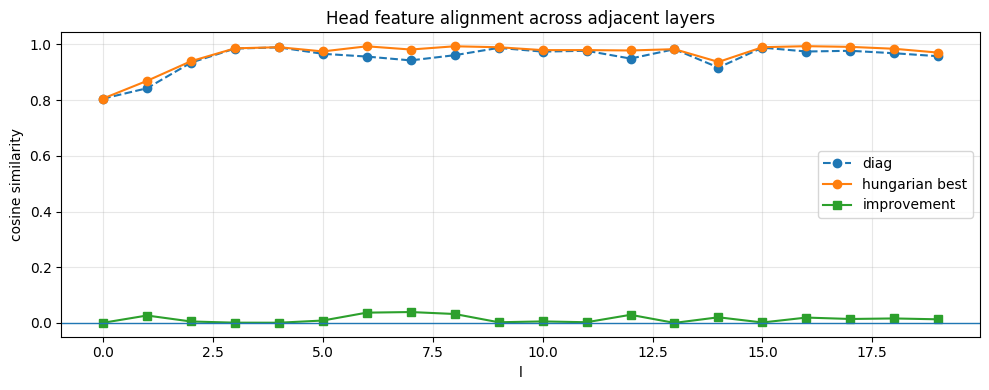


Anchor alignment summary (anchor=L10):


anchor   l  diag_cos  best_cos  improvement
0       10   0  0.780349  0.786627     0.006278
1       10   1  0.746319  0.803948     0.057629
2       10   2  0.852553  0.858859     0.006306
3       10   3  0.928133  0.933049     0.004915
4       10   4  0.889797  0.913490     0.023694
5       10   5  0.905152  0.925184     0.020032
6       10   6  0.955092  0.970313     0.015221
7       10   7  0.965588  0.977727     0.012139
8       10   8  0.960085  0.984469     0.024384
9       10   9  0.987473  0.989785     0.002312
10      10  11  0.974070  0.979413     0.005343
11      10  12  0.975812  0.986939     0.011127
12      10  13  0.966099  0.979862     0.013763
13      10  14  0.956981  0.969199     0.012218
14      10  15  0.888486  0.916896     0.028410
15      10  16  0.891268  0.924306     0.033038
16      10  17  0.890042  0.926086     0.036044
17      10  18  0.894121  0.922722     0.028601
18      10  19  0.900654  0.925679     0.025025
19      10  20  0.889086  0.907638     0.018552

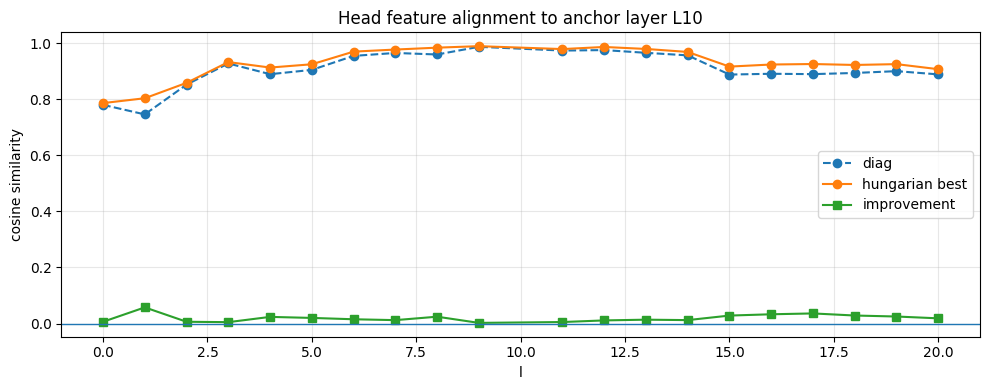


=== PAPER TABLE: summary metrics (↑ keep/ARI/NMI better; ↓ entropy better) ===


mode  k  inertia(z)  keep_mean  ARI_mean  NMI_mean  \
0        no_align  7  395.486725    0.58125  0.228817  0.649007   
1  aligned_anchor  7  379.502045    0.44375  0.079631  0.563944   

   slot_entropy_mean              keep_CI                ARI_CI  \
0           1.085864  0.581 [0.481,0.675]   0.229 [0.094,0.384]   
1           1.383063  0.444 [0.350,0.537]  0.080 [-0.017,0.185]   

                NMI_CI           entropy_CI  
0  0.649 [0.555,0.742]  1.086 [0.920,1.234]  
1  0.564 [0.457,0.674]  1.383 [1.248,1.517]


MODE: no_align
K-means inertia (z-scored space): 395.49
Correspondence: adjacent stability uses ADJACENT Hungarian perms


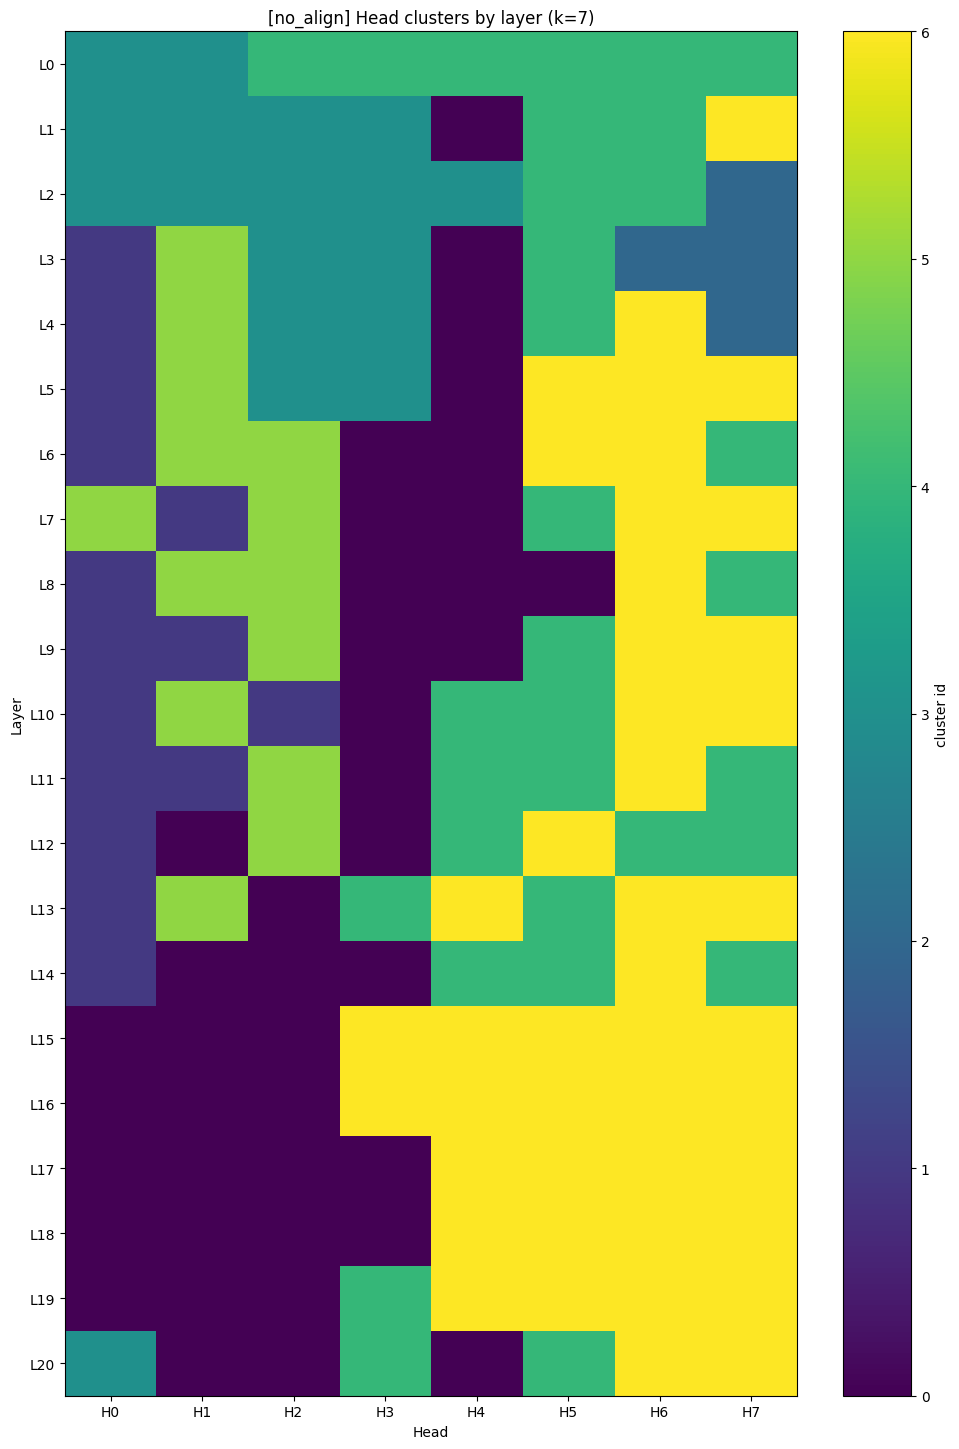

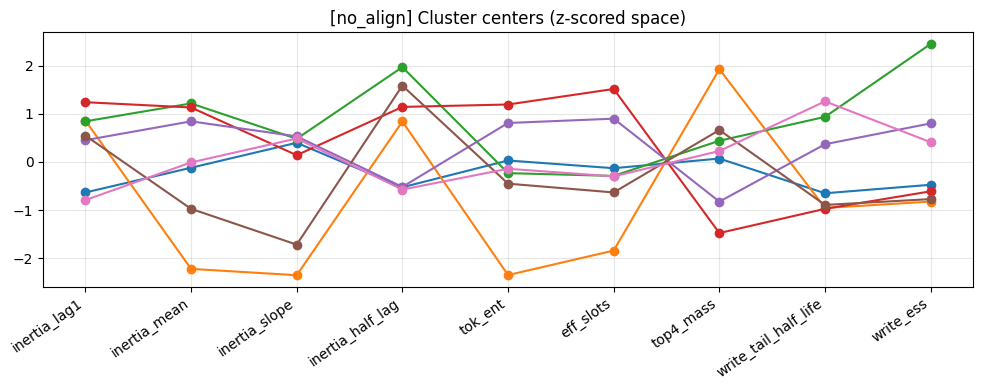


[no_align] Per-transition stability metrics:


l  keep_rate       ARI       NMI
0    0      0.500 -0.133333  0.243065
1    1      0.625  0.520000  0.688006
2    2      0.500  0.037500  0.552172
3    3      0.625  0.650000  0.952381
4    4      0.750  0.363636  0.878841
5    5      0.500  0.186047  0.751600
6    6      0.375 -0.120000  0.666667
7    7      0.750  0.511628  0.865091
8    8      0.125  0.186047  0.751600
9    9      0.500 -0.120000  0.666667
10  10      0.250 -0.139535  0.638109
11  11      0.625  0.125000  0.724276
12  12      0.625  0.125000  0.724276
13  13      0.500  0.034483  0.613533
14  14      0.250 -0.117021  0.192147
15  15      1.000  1.000000  1.000000
16  16      0.875  0.494845  0.561590
17  17      0.750  0.125000  0.188722
18  18      0.875  0.774194  0.831380
19  19      0.625  0.072848  0.490009

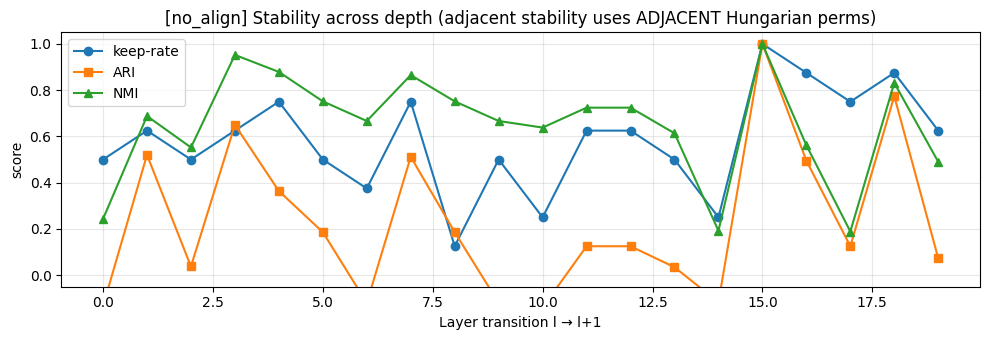

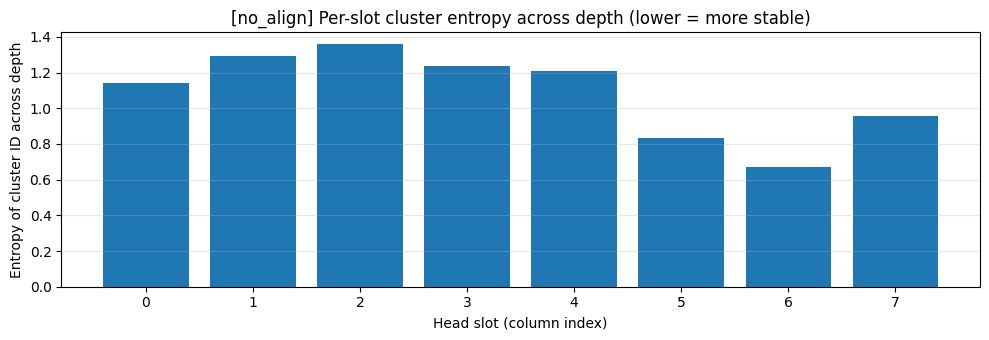


[no_align] Cluster lifecycle table:


cluster  first_layer  last_layer  lifespan_layers
0        0            1          20               20
1        1            3          14               12
2        2            2           4                3
3        3            0          20               21
4        4            0          20               21
5        5            3          13               11
6        6            1          20               20

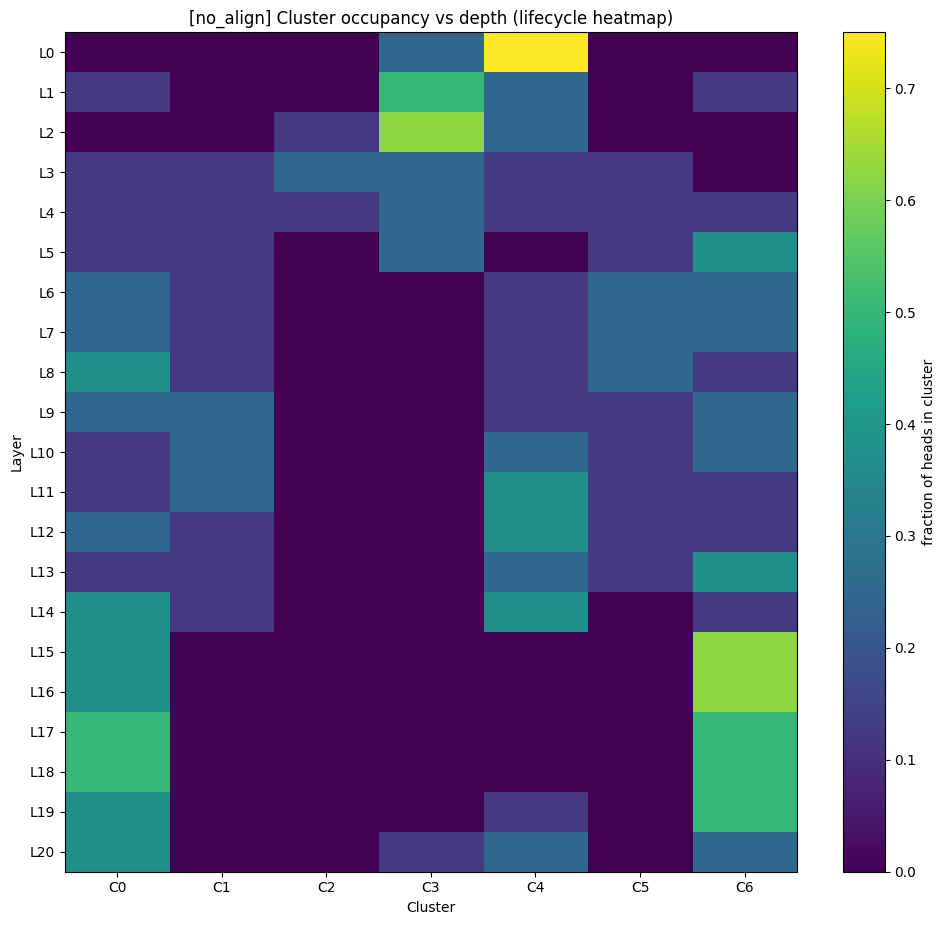


MODE: aligned_anchor
K-means inertia (z-scored space): 379.50
Correspondence: adjacent stability uses IDENTITY (slots anchored to L10)


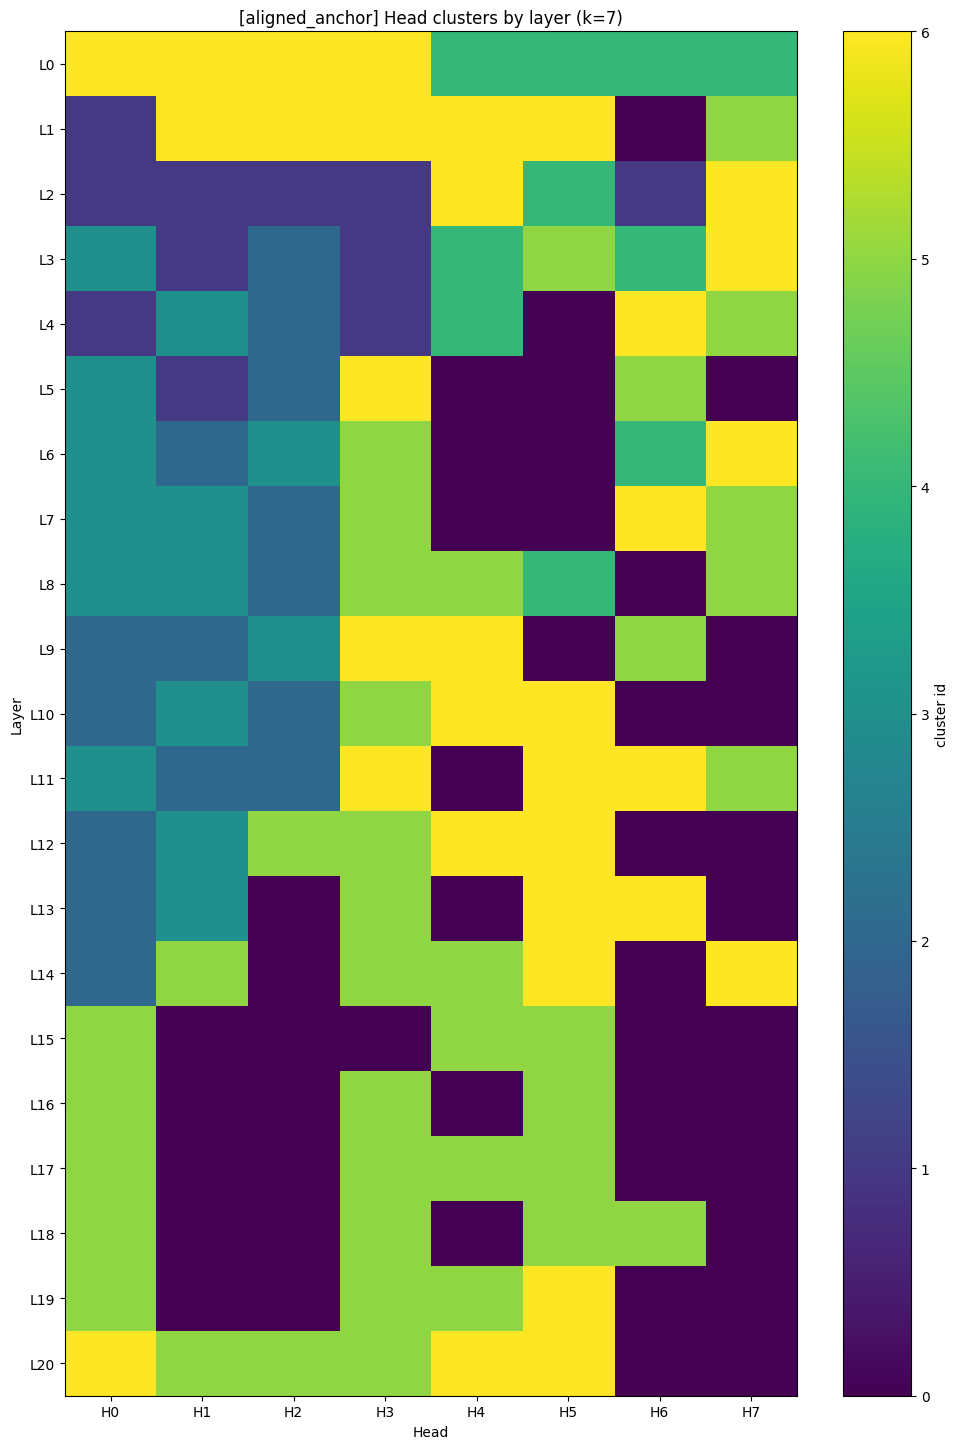

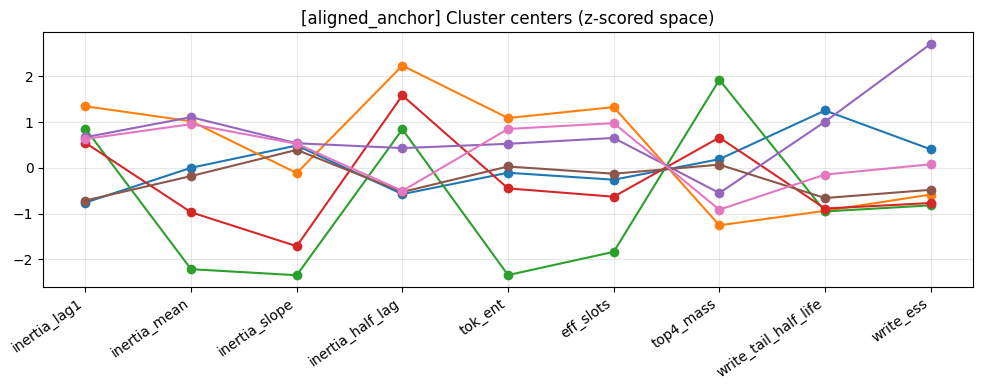


[aligned_anchor] Per-transition stability metrics:


l  keep_rate       ARI       NMI
0    0      0.375 -0.042553  0.308503
1    1      0.250 -0.141304  0.310403
2    2      0.375  0.037500  0.552172
3    3      0.375 -0.050000  0.857143
4    4      0.250 -0.056604  0.836226
5    5      0.375  0.343750  0.878841
6    6      0.500  0.343750  0.842105
7    7      0.625  0.511628  0.865091
8    8      0.000  0.511628  0.865091
9    9      0.375 -0.120000  0.666667
10  10      0.250 -0.139535  0.638109
11  11      0.125 -0.139535  0.638109
12  12      0.625 -0.139535  0.638109
13  13      0.500 -0.188679  0.522633
14  14      0.375 -0.048128  0.251793
15  15      0.750  0.138462  0.166453
16  16      0.875  0.494845  0.561590
17  17      0.750  0.125000  0.188722
18  18      0.625  0.021505  0.207845
19  19      0.500  0.130435  0.483274

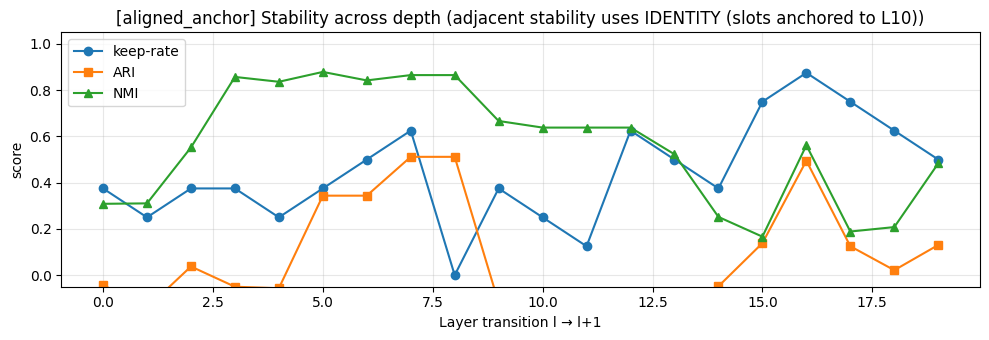

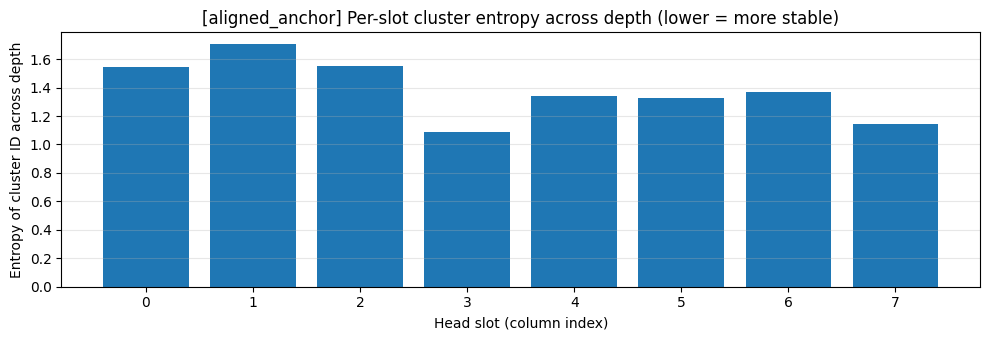


[aligned_anchor] Cluster lifecycle table:


cluster  first_layer  last_layer  lifespan_layers
0        0            1          20               20
1        1            1           5                5
2        2            3          14               12
3        3            3          13               11
4        4            0           8                9
5        5            1          20               20
6        6            0          20               21

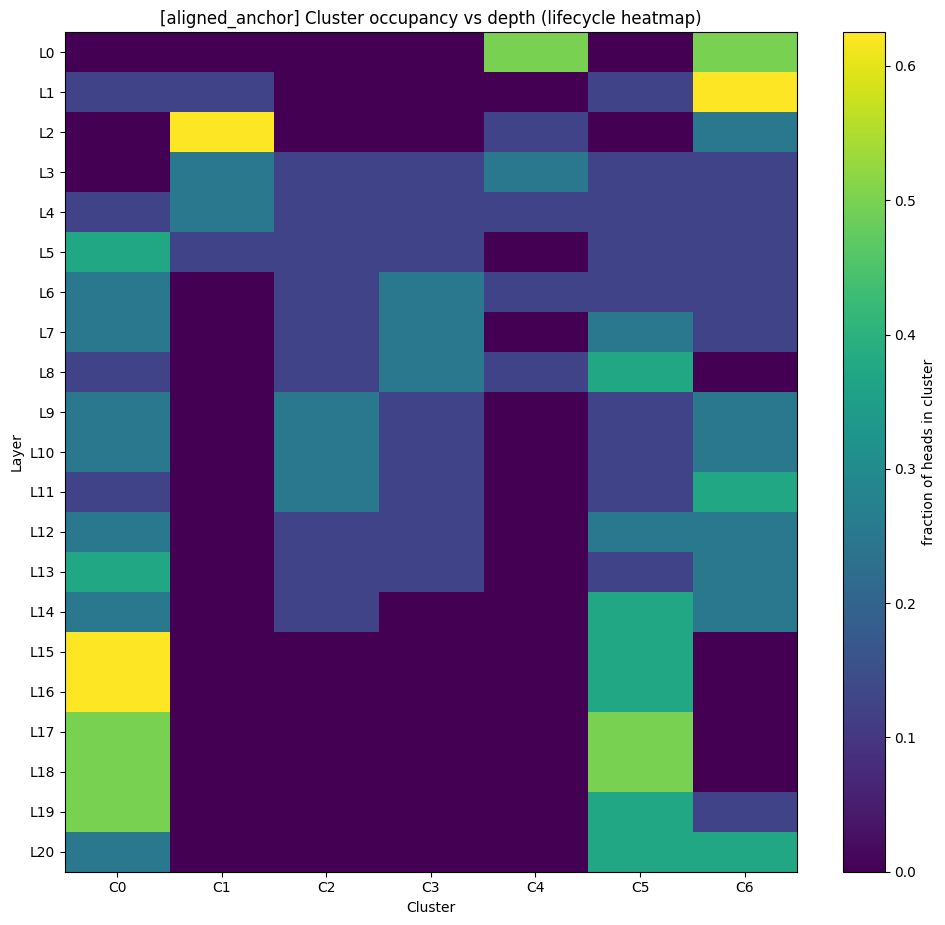

In [111]:

#@title Head clustering + rigorous head alignment (adjacent + ANCHOR) + paper-grade metrics (FULL CELL)

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# =============================================================================
# Helpers
# =============================================================================

def _cos_sim_matrix(A: np.ndarray, B: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    An = A / (np.linalg.norm(A, axis=-1, keepdims=True) + eps)
    Bn = B / (np.linalg.norm(B, axis=-1, keepdims=True) + eps)
    return An @ Bn.T  # [H,H2]

def _entropy(p, axis=-1, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=axis)

def _topk_mass(p, k=4, axis=-1):
    part = np.partition(p, -k, axis=axis)
    topk = part.take(indices=range(p.shape[axis]-k, p.shape[axis]), axis=axis)
    return np.sum(topk, axis=axis)

# =============================================================================
# Routing inertia per head
# =============================================================================

@torch.no_grad()
def routing_inertia_per_head(t2a: torch.Tensor, max_lag: int = 64, eps: float = 1e-8) -> torch.Tensor:
    """
    t2a: [B,H,T,K] probabilities
    returns: [H,L] where L=min(max_lag,T-1) mean over (B,T')
    """
    B,H,T,K = t2a.shape
    L = int(min(max_lag, T-1))
    p = t2a.float()
    p = p / (p.norm(dim=-1, keepdim=True).clamp_min(eps))
    w = p.unfold(dimension=2, size=L+1, step=1).permute(0,1,2,4,3).contiguous()
    a = w[:,:,:,:1,:]          # [B,H,T-L,1,K]
    b = w[:,:,:,1:,:]          # [B,H,T-L,L,K]
    sim = (a*b).sum(dim=-1)    # [B,H,T-L,L]
    return sim.mean(dim=(0,2)) # [H,L]

def summarize_inertia_curve(curve_hl: np.ndarray) -> np.ndarray:
    """
    curve_hl: [H,L] (cos similarity vs lag)
    Returns per-head summary features: [H, 4]
      - lag1
      - mean over lags
      - slope (linear fit)
      - half-decay lag where curve < (lag1+min)/2
    """
    H,L = curve_hl.shape
    x = np.arange(1, L+1, dtype=np.float32)

    out = np.zeros((H,4), dtype=np.float32)
    for h in range(H):
        y = curve_hl[h].astype(np.float32)

        lag1 = float(y[0])
        mean = float(y.mean())

        xc = x - x.mean()
        yc = y - y.mean()
        slope = float((xc*yc).sum() / ((xc*xc).sum() + 1e-12))

        y_min = float(y.min())
        thr = 0.5*(lag1 + y_min)
        idx = np.argmax(y < thr)
        half_lag = float(x[idx]) if (y < thr).any() else float(L)

        out[h] = [lag1, mean, slope, half_lag]
    return out

# =============================================================================
# Per-head memory half-life + ESS from write logits
# =============================================================================

@torch.no_grad()
def per_head_half_life_ess(write_logits: torch.Tensor, threshold: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
    """
    write_logits: [B,H,K,T]
    Returns:
      hl_h:  [H]
      ess_h: [H]
    """
    B,H,K,T = write_logits.shape
    t_points = torch.linspace(32, T-1, steps=48, device=write_logits.device).round().long().unique()
    hl_acc = []
    ess_acc = []
    for t in t_points.tolist():
        L = int(t)+1
        logits = write_logits[..., :L]                  # [B,H,K,L]
        logp = F.log_softmax(logits, dim=-1)            # over time
        p = logp.exp()

        tail = torch.flip(p, dims=[-1]).cumsum(dim=-1)  # [B,H,K,L]
        hl = (tail < threshold).sum(dim=-1).float() + 1 # [B,H,K]
        ess = 1.0 / (p*p).sum(dim=-1).clamp_min(1e-12)  # [B,H,K]

        hl_acc.append(hl.mean(dim=(0,2)))               # [H]
        ess_acc.append(ess.mean(dim=(0,2)))             # [H]

    hl_h  = torch.stack(hl_acc).mean(dim=0).detach().cpu().numpy()
    ess_h = torch.stack(ess_acc).mean(dim=0).detach().cpu().numpy()
    return hl_h, ess_h

# =============================================================================
# Head-level routing distribution stats (from read_weights)
# =============================================================================

@torch.no_grad()
def per_head_routing_stats(read_weights: torch.Tensor, topk: int = 4) -> dict:
    """
    read_weights: [B,H,T,K] probabilities
    Returns: dict of per-head arrays [H]
      - tok_ent: entropy over K averaged over (B,T)
      - eff_slots: exp(entropy)
      - topk_mass: average top-k mass
    """
    p = read_weights.detach().float().cpu().numpy()  # [B,H,T,K]
    ent = _entropy(p, axis=-1)                       # [B,H,T]
    tok_ent_h = ent.mean(axis=(0,2))                 # [H]
    eff_h = np.exp(tok_ent_h)                        # [H]
    topk_h = _topk_mass(p, k=topk, axis=-1).mean(axis=(0,2))
    return {"tok_ent": tok_ent_h.astype(np.float32),
            "eff_slots": eff_h.astype(np.float32),
            "topk_mass": topk_h.astype(np.float32)}

# =============================================================================
# Build head feature vectors per layer
# =============================================================================

def head_features_for_layer(
    info: dict,
    *,
    max_lag: int = 64,
    include_inertia: bool = True,
    include_memory: bool = True,
    include_routing_stats: bool = True,
    threshold_hl: float = 0.5
) -> tuple[np.ndarray, list[str]]:
    feats = []
    names = []

    rw = info.get("read_weights", None)

    if include_inertia and (rw is not None):
        curve = routing_inertia_per_head(rw, max_lag=max_lag)   # [H,L]
        curve_np = curve.detach().cpu().numpy()
        summ = summarize_inertia_curve(curve_np)                # [H,4]
        feats.append(summ)
        names += ["inertia_lag1", "inertia_mean", "inertia_slope", "inertia_half_lag"]

    if include_routing_stats and (rw is not None):
        stats = per_head_routing_stats(rw, topk=4)
        feats.append(stats["tok_ent"][:,None]);   names += ["tok_ent"]
        feats.append(stats["eff_slots"][:,None]); names += ["eff_slots"]
        feats.append(stats["topk_mass"][:,None]); names += ["top4_mass"]

    if include_memory:
        wl = info.get("write_logits", None)
        if wl is not None:
            hl_h, ess_h = per_head_half_life_ess(wl, threshold=threshold_hl)
            feats.append(hl_h[:,None]);  names += ["write_tail_half_life"]
            feats.append(ess_h[:,None]); names += ["write_ess"]

    if not feats:
        raise ValueError("No features extracted (missing read_weights / write_logits?)")

    X = np.concatenate(feats, axis=1).astype(np.float32)
    return X, names

def build_head_feature_bank(
    infos,
    *,
    max_lag: int = 64,
    include_inertia: bool = True,
    include_memory: bool = True,
    include_routing_stats: bool = True,
    threshold_hl: float = 0.5
):
    feat_by_layer = []
    feature_names = None

    for li, info in enumerate(infos):
        if info is None:
            feat_by_layer.append(None); continue
        if info.get("read_weights", None) is None and info.get("write_logits", None) is None:
            feat_by_layer.append(None); continue

        X, names = head_features_for_layer(
            info,
            max_lag=max_lag,
            include_inertia=include_inertia,
            include_memory=include_memory,
            include_routing_stats=include_routing_stats,
            threshold_hl=threshold_hl,
        )
        feat_by_layer.append(X)
        if feature_names is None:
            feature_names = names

    return feat_by_layer, feature_names

# =============================================================================
# Hungarian alignment (adjacent + anchor)
# =============================================================================

def hungarian_best_cos_heads(A_hd: np.ndarray, B_hd: np.ndarray):
    """
    A_hd, B_hd: [H,D]
    returns:
      diag_cos, best_cos, perm
    perm[h] = matched head index in B for head h in A
    """
    from scipy.optimize import linear_sum_assignment
    S = _cos_sim_matrix(A_hd, B_hd)  # [H,H]
    diag = float(np.diag(S).mean())
    row, col = linear_sum_assignment(-S)
    best = float(S[row, col].mean())
    perm = np.empty((S.shape[0],), dtype=np.int64)
    perm[row] = col
    return diag, best, perm

def compute_adjacent_head_alignment(feat_by_layer):
    rows = []
    for l in range(len(feat_by_layer)-1):
        A = feat_by_layer[l]
        B = feat_by_layer[l+1]
        if A is None or B is None:
            continue
        if A.shape[0] != B.shape[0]:
            continue
        d, b, perm = hungarian_best_cos_heads(A, B)
        rows.append({"l": l, "l_to": l+1, "diag_cos": d, "best_cos": b, "improvement": b-d, "perm": perm})
    return rows

def compute_anchor_head_alignment(feat_by_layer, valid_layers, anchor_layer: int):
    """
    Align each layer l to anchor_layer via one Hungarian solve:
      perm_anchor_to_l[h_anchor] = h_l
    Returns rows with perm from anchor -> l.
    """
    A = feat_by_layer[anchor_layer]
    if A is None:
        raise ValueError("Anchor layer has no features.")
    rows = []
    for l in valid_layers:
        if l == anchor_layer:
            continue
        B = feat_by_layer[l]
        if B is None:
            continue
        if A.shape[0] != B.shape[0]:
            continue
        d, b, perm = hungarian_best_cos_heads(A, B)
        rows.append({"anchor": anchor_layer, "l": l, "diag_cos": d, "best_cos": b, "improvement": b-d, "perm": perm})
    return rows

def make_aligned_feat_by_anchor(feat_by_layer, valid_layers, anchor_rows, anchor_layer: int):
    """
    Creates feat_aligned where all layers are reordered into ANCHOR slot space:
      aligned_feat[l][h_anchor] = feat_by_layer[l][ perm_anchor_to_l[h_anchor] ]
    """
    perm_by_l = {int(r["l"]): r["perm"] for r in anchor_rows}
    feat_aligned = list(feat_by_layer)
    for l in valid_layers:
        if l == anchor_layer:
            continue
        if l not in perm_by_l:
            continue
        feat_aligned[l] = feat_by_layer[l][perm_by_l[l]]
    return feat_aligned, perm_by_l

# =============================================================================
# K-means (numpy)
# =============================================================================

def kmeans(X: np.ndarray, k: int, n_init: int = 10, iters: int = 100, seed: int = 0):
    """
    X: [N,D]
    Returns:
      labels: [N]
      centers: [k,D] (z-scored space)
      inertia: float (z-scored space)
    """
    rng = np.random.default_rng(seed)
    best = None

    Xn = X.copy()
    Xn = (Xn - Xn.mean(axis=0, keepdims=True)) / (Xn.std(axis=0, keepdims=True) + 1e-6)

    for _ in range(n_init):
        centers = np.empty((k, Xn.shape[1]), dtype=np.float32)
        idx0 = rng.integers(0, Xn.shape[0])
        centers[0] = Xn[idx0]
        dist = np.sum((Xn - centers[0])**2, axis=1)
        for j in range(1, k):
            idx = int(np.argmax(dist))
            centers[j] = Xn[idx]
            dist = np.minimum(dist, np.sum((Xn - centers[j])**2, axis=1))

        for _it in range(iters):
            d2 = np.sum((Xn[:,None,:] - centers[None,:,:])**2, axis=2)  # [N,k]
            labels = np.argmin(d2, axis=1)
            new_centers = np.stack([
                Xn[labels==j].mean(axis=0) if np.any(labels==j) else centers[j]
                for j in range(k)
            ])
            if np.max(np.abs(new_centers - centers)) < 1e-5:
                centers = new_centers
                break
            centers = new_centers

        inertia_val = float(np.sum((Xn - centers[labels])**2))
        if best is None or inertia_val < best[0]:
            best = (inertia_val, labels.copy(), centers.copy())

    return best[1], best[2], best[0]

# =============================================================================
# Plotting
# =============================================================================

def plot_head_cluster_map(cluster_by_layer, title="Head clusters by layer"):
    layers = sorted(cluster_by_layer.keys())
    H = len(cluster_by_layer[layers[0]])
    mat = np.stack([cluster_by_layer[l] for l in layers], axis=0)  # [L,H]

    plt.figure(figsize=(10, 0.6*len(layers)+2))
    plt.imshow(mat, aspect="auto")
    plt.yticks(range(len(layers)), [f"L{l}" for l in layers])
    plt.xticks(range(H), [f"H{h}" for h in range(H)])
    plt.colorbar(label="cluster id")
    plt.title(title)
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

def plot_alignment_quality(df: pd.DataFrame, xcol: str, title="Head alignment"):
    plt.figure(figsize=(10,4))
    plt.plot(df[xcol], df["diag_cos"], "o--", label="diag")
    plt.plot(df[xcol], df["best_cos"], "o-", label="hungarian best")
    plt.plot(df[xcol], df["improvement"], "s-", label="improvement")
    plt.axhline(0, lw=1)
    plt.xlabel(xcol)
    plt.ylabel("cosine similarity")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importance_like(centers: np.ndarray, feature_names: list[str], title="Cluster centers (z-scored space)"):
    plt.figure(figsize=(max(10, len(feature_names)*0.7), 4))
    for j in range(centers.shape[0]):
        plt.plot(range(len(feature_names)), centers[j], marker="o", label=f"cluster {j}")
    plt.xticks(range(len(feature_names)), feature_names, rotation=35, ha="right")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cluster_occupancy(occ, layers, k, title):
    plt.figure(figsize=(10, 0.35*len(layers)+2))
    plt.imshow(occ, aspect="auto")
    plt.yticks(range(len(layers)), [f"L{l}" for l in layers])
    plt.xticks(range(k), [f"C{c}" for c in range(k)])
    plt.colorbar(label="fraction of heads in cluster")
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

def plot_slot_entropy(ent, title):
    plt.figure(figsize=(10, 3.5))
    plt.bar(np.arange(len(ent)), ent)
    plt.grid(True, axis="y", alpha=0.3)
    plt.xlabel("Head slot (column index)")
    plt.ylabel("Entropy of cluster ID across depth")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_stability_curves(df_adj, title):
    plt.figure(figsize=(10, 3.5))
    plt.plot(df_adj["l"], df_adj["keep_rate"], "o-", label="keep-rate")
    plt.plot(df_adj["l"], df_adj["ARI"], "s-", label="ARI")
    plt.plot(df_adj["l"], df_adj["NMI"], "^-", label="NMI")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)
    plt.xlabel("Layer transition l → l+1")
    plt.ylabel("score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# Packing / mapping
# =============================================================================

def _pack_all_heads(feat_by_layer, valid_layers):
    Xs, meta = [], []
    for l in valid_layers:
        X = feat_by_layer[l]
        H = X.shape[0]
        Xs.append(X)
        for h in range(H):
            meta.append((l, h))
    X_all = np.concatenate(Xs, axis=0)
    meta = np.array(meta, dtype=np.int32)
    return X_all, meta

def _clusters_to_map(meta, labels, feat_by_layer):
    cluster_by_layer = {}
    for (l,h), c in zip(meta, labels):
        l = int(l); h = int(h); c = int(c)
        cluster_by_layer.setdefault(l, np.full((feat_by_layer[l].shape[0],), -1, dtype=np.int32))
        cluster_by_layer[l][h] = c
    return cluster_by_layer

# =============================================================================
# Paper-grade metrics
# =============================================================================

def adjacent_partition_metrics(cluster_by_layer, perm_by_l):
    """
    Per-transition stability metrics after providing head correspondence perm_by_l
      perm_by_l[l] maps head indices in layer l -> head indices in layer l+1
    """
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    layers = sorted(cluster_by_layer.keys())
    rows = []
    for l in layers:
        if (l+1) not in cluster_by_layer:
            continue
        if l not in perm_by_l:
            continue

        A = np.asarray(cluster_by_layer[l])
        B = np.asarray(cluster_by_layer[l+1])
        perm = perm_by_l[l]
        if perm.shape[0] != B.shape[0]:
            continue

        B_aligned = B[perm]
        keep = float((A == B_aligned).mean())
        ari = float(adjusted_rand_score(A, B_aligned))
        nmi = float(normalized_mutual_info_score(A, B_aligned))
        rows.append({"l": l, "keep_rate": keep, "ARI": ari, "NMI": nmi})
    return pd.DataFrame(rows)

def slot_entropy_across_depth(cluster_by_layer):
    layers = sorted(cluster_by_layer.keys())
    mat = np.stack([cluster_by_layer[l] for l in layers], axis=0)  # [L,H]
    L, H = mat.shape
    ent = np.zeros((H,), dtype=np.float32)
    for h in range(H):
        vals = mat[:, h]
        uniq, cnt = np.unique(vals, return_counts=True)
        p = cnt.astype(np.float32) / cnt.sum()
        ent[h] = float(_entropy(p, axis=0))
    return ent

def cluster_lifecycle(cluster_by_layer, k):
    layers = sorted(cluster_by_layer.keys())
    H = len(cluster_by_layer[layers[0]])
    occ = np.zeros((len(layers), k), dtype=np.float32)
    for i, l in enumerate(layers):
        v = np.asarray(cluster_by_layer[l])
        for c in range(k):
            occ[i, c] = float((v == c).mean())

    first, last, life = [], [], []
    for c in range(k):
        present = np.where(occ[:, c] > 0)[0]
        if len(present) == 0:
            first.append(np.nan); last.append(np.nan); life.append(np.nan)
        else:
            f = layers[int(present[0])]
            t = layers[int(present[-1])]
            first.append(f); last.append(t); life.append(t - f + 1)

    df = pd.DataFrame({"cluster": np.arange(k, dtype=np.int32),
                       "first_layer": first, "last_layer": last, "lifespan_layers": life})
    return df, occ, layers

# =============================================================================
# Bootstrap CIs (rigor)
# =============================================================================

def bootstrap_ci(values, n_boot=2000, seed=0, alpha=0.05):
    """
    Nonparametric bootstrap CI for the mean.
    values: 1D array-like
    Returns (mean, lo, hi)
    """
    rng = np.random.default_rng(seed)
    v = np.asarray(values, dtype=np.float64)
    if v.size == 0:
        return (np.nan, np.nan, np.nan)
    means = []
    for _ in range(n_boot):
        samp = rng.choice(v, size=v.size, replace=True)
        means.append(samp.mean())
    means = np.asarray(means)
    lo = float(np.quantile(means, alpha/2))
    hi = float(np.quantile(means, 1-alpha/2))
    return (float(v.mean()), lo, hi)

def bootstrap_ci_rows(df, col, n_boot=2000, seed=0, alpha=0.05):
    if df is None or len(df) == 0:
        return (np.nan, np.nan, np.nan)
    return bootstrap_ci(df[col].to_numpy(), n_boot=n_boot, seed=seed, alpha=alpha)

# =============================================================================
# MAIN RUN
# =============================================================================

# ---- knobs ----
MAX_LAG = 64
INCLUDE_INERTIA = True
INCLUDE_MEMORY = True
INCLUDE_ROUTING_STATS = True
HL_THRESHOLD = 0.5

N_CLUSTERS = 7
N_INIT = 15
SEED = 0

# Alignment strategy for "aligned" mode:
#  - "anchor": align all layers to a single anchor layer (recommended)
#  - "adjacent": keep your original adjacent composition approach (kept here mainly for comparison)
ALIGN_MODE = "anchor"   # {"anchor","adjacent"}
ANCHOR_LAYER = None     # if None, uses middle valid layer

# Bootstrap rigor knobs
BOOTSTRAP = True
N_BOOT = 2000
ALPHA = 0.05

# ---- build features ----
feat_by_layer, feature_names = build_head_feature_bank(
    infos,
    max_lag=MAX_LAG,
    include_inertia=INCLUDE_INERTIA,
    include_memory=INCLUDE_MEMORY,
    include_routing_stats=INCLUDE_ROUTING_STATS,
    threshold_hl=HL_THRESHOLD,
)

valid_layers = [i for i, x in enumerate(feat_by_layer) if x is not None]
print("Valid layers with head features:", valid_layers)
print("Feature dim:", len(feature_names), feature_names)

# ---- adjacent alignment diagnostics (always useful) ----
align_rows_adj = compute_adjacent_head_alignment(feat_by_layer)
df_align_adj = pd.DataFrame([{k: v for k, v in r.items() if k != "perm"} for r in align_rows_adj])
print("\nAdjacent-layer head alignment summary:")
display(df_align_adj)
if len(df_align_adj) > 0:
    plot_alignment_quality(df_align_adj, xcol="l", title="Head feature alignment across adjacent layers")

perm_by_l_adj = {int(r["l"]): r["perm"] for r in align_rows_adj}

# ---- choose anchor layer + compute anchor alignment ----
if ANCHOR_LAYER is None:
    ANCHOR_LAYER = valid_layers[len(valid_layers)//2]

anchor_rows = compute_anchor_head_alignment(feat_by_layer, valid_layers, anchor_layer=ANCHOR_LAYER)
df_align_anchor = pd.DataFrame([{k: v for k, v in r.items() if k != "perm"} for r in anchor_rows]).sort_values("l")
print(f"\nAnchor alignment summary (anchor=L{ANCHOR_LAYER}):")
display(df_align_anchor)
if len(df_align_anchor) > 0:
    plot_alignment_quality(df_align_anchor, xcol="l", title=f"Head feature alignment to anchor layer L{ANCHOR_LAYER}")

# ---- construct aligned feature bank using anchor perms ----
feat_aligned_anchor, perm_anchor_to_l = make_aligned_feat_by_anchor(
    feat_by_layer, valid_layers, anchor_rows, anchor_layer=ANCHOR_LAYER
)

# For anchor-aligned data, adjacent transition perm (l->l+1) is derivable from anchor perms:
# B_aligned_to_A at transition l->l+1 is achieved by indexing both in anchor-slot space already,
# so we can use identity correspondence when comparing slots. But for strict comparison with your old
# formulation (A[h] corresponds to B[perm[h]]), we can just use perm_by_l = identity.
def _identity_perm_by_l_from_cluster_map(cluster_by_layer):
    perm_by = {}
    layers = sorted(cluster_by_layer.keys())
    for l in layers:
        if (l+1) not in cluster_by_layer:
            continue
        H = len(cluster_by_layer[l])
        perm_by[l] = np.arange(H, dtype=np.int64)
    return perm_by

# ---- clustering runner ----
def run_mode(mode_name, feat_src):
    X_all, meta = _pack_all_heads(feat_src, valid_layers)
    labels, centers, inertia_val = kmeans(X_all, k=N_CLUSTERS, n_init=N_INIT, iters=200, seed=SEED)
    cluster_by_layer = _clusters_to_map(meta, labels, feat_src)
    return {
        "mode": mode_name,
        "X_all": X_all,
        "meta": meta,
        "labels": labels,
        "centers": centers,
        "inertia": float(inertia_val),
        "cluster_by_layer": cluster_by_layer,
    }

results = {}
results["no_align"] = run_mode("no_align", feat_by_layer)

if ALIGN_MODE == "anchor":
    results["aligned"] = run_mode("aligned_anchor", feat_aligned_anchor)
elif ALIGN_MODE == "adjacent":
    # Keep old behavior: composing adjacent perms to define slots (less rigorous than anchor)
    # Here we simply reuse your original "no reindexing" and interpret stability using perm_by_l_adj.
    results["aligned"] = run_mode("aligned_adjacent_semantics", feat_by_layer)
else:
    raise ValueError("ALIGN_MODE must be 'anchor' or 'adjacent'.")

# ---- paper-grade summary table (with optional bootstrap CIs) ----
summary_rows = []
for key, R in results.items():
    cb = R["cluster_by_layer"]

    # pick correspondence for adjacent stability metrics
    if key == "aligned" and ALIGN_MODE == "anchor":
        perm_by_l_for_metrics = _identity_perm_by_l_from_cluster_map(cb)
    else:
        perm_by_l_for_metrics = perm_by_l_adj

    df_adj = adjacent_partition_metrics(cb, perm_by_l_for_metrics)
    ent = slot_entropy_across_depth(cb)

    row = {
        "mode": R["mode"],
        "k": N_CLUSTERS,
        "inertia(z)": R["inertia"],
        "keep_mean": float(df_adj["keep_rate"].mean()) if len(df_adj) else np.nan,
        "ARI_mean": float(df_adj["ARI"].mean()) if len(df_adj) else np.nan,
        "NMI_mean": float(df_adj["NMI"].mean()) if len(df_adj) else np.nan,
        "slot_entropy_mean": float(ent.mean()),
    }

    if BOOTSTRAP and len(df_adj) > 0:
        km, klo, khi = bootstrap_ci_rows(df_adj, "keep_rate", n_boot=N_BOOT, seed=SEED, alpha=ALPHA)
        am, alo, ahi = bootstrap_ci_rows(df_adj, "ARI", n_boot=N_BOOT, seed=SEED+1, alpha=ALPHA)
        nm, nlo, nhi = bootstrap_ci_rows(df_adj, "NMI", n_boot=N_BOOT, seed=SEED+2, alpha=ALPHA)
        em, elo, ehi = bootstrap_ci(ent, n_boot=N_BOOT, seed=SEED+3, alpha=ALPHA)

        row.update({
            "keep_CI": f"{km:.3f} [{klo:.3f},{khi:.3f}]",
            "ARI_CI":  f"{am:.3f} [{alo:.3f},{ahi:.3f}]",
            "NMI_CI":  f"{nm:.3f} [{nlo:.3f},{nhi:.3f}]",
            "entropy_CI": f"{em:.3f} [{elo:.3f},{ehi:.3f}]",
        })

    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)
print("\n=== PAPER TABLE: summary metrics (↑ keep/ARI/NMI better; ↓ entropy better) ===")
display(df_summary)

# =============================================================================
# Detailed outputs per mode
# =============================================================================

for key, R in results.items():
    cb = R["cluster_by_layer"]

    # correspondence for adjacent stability metrics
    if key == "aligned" and ALIGN_MODE == "anchor":
        perm_by_l_for_metrics = _identity_perm_by_l_from_cluster_map(cb)
        corr_note = f"adjacent stability uses IDENTITY (slots anchored to L{ANCHOR_LAYER})"
    else:
        perm_by_l_for_metrics = perm_by_l_adj
        corr_note = "adjacent stability uses ADJACENT Hungarian perms"

    print("\n" + "="*80)
    print(f"MODE: {R['mode']}")
    print("="*80)
    print(f"K-means inertia (z-scored space): {R['inertia']:.2f}")
    print(f"Correspondence: {corr_note}")

    plot_head_cluster_map(cb, title=f"[{R['mode']}] Head clusters by layer (k={N_CLUSTERS})")
    plot_feature_importance_like(R["centers"], feature_names, title=f"[{R['mode']}] Cluster centers (z-scored space)")

    df_adj = adjacent_partition_metrics(cb, perm_by_l_for_metrics)
    print(f"\n[{R['mode']}] Per-transition stability metrics:")
    display(df_adj)
    if len(df_adj) > 0:
        plot_stability_curves(df_adj, title=f"[{R['mode']}] Stability across depth ({corr_note})")

    ent = slot_entropy_across_depth(cb)
    plot_slot_entropy(ent, title=f"[{R['mode']}] Per-slot cluster entropy across depth (lower = more stable)")

    df_life, occ, layers = cluster_lifecycle(cb, k=N_CLUSTERS)
    print(f"\n[{R['mode']}] Cluster lifecycle table:")
    display(df_life)
    plot_cluster_occupancy(occ, layers, N_CLUSTERS, title=f"[{R['mode']}] Cluster occupancy vs depth (lifecycle heatmap)")


=== Alignment diagnostics ===


l  diag_cos  best_cos  improvement
0    0  0.805175  0.805623     0.000448
1    1  0.842526  0.869065     0.026540
2    2  0.934456  0.939598     0.005142
3    3  0.984981  0.985819     0.000839
4    4  0.989260  0.989939     0.000679
5    5  0.966195  0.974757     0.008561
6    6  0.956301  0.993163     0.036862
7    7  0.942549  0.981572     0.039023
8    8  0.961225  0.993237     0.032012
9    9  0.987473  0.989785     0.002312
10  10  0.974070  0.979413     0.005343
11  11  0.977116  0.979536     0.002420
12  12  0.949077  0.978169     0.029093
13  13  0.982749  0.982833     0.000083
14  14  0.916839  0.937016     0.020177
15  15  0.988376  0.989904     0.001528
16  16  0.974481  0.993629     0.019148
17  17  0.977017  0.991135     0.014117
18  18  0.968227  0.984245     0.016018
19  19  0.957575  0.970470     0.012895

l  diag_cos  best_cos  improvement
0    0  0.780349  0.786627     0.006278
1    1  0.746319  0.803948     0.057629
2    2  0.852553  0.858859     0.006306
3    3  0.928133  0.933049     0.004915
4    4  0.889797  0.913490     0.023694
5    5  0.905152  0.925184     0.020032
6    6  0.955092  0.970313     0.015221
7    7  0.965588  0.977727     0.012139
8    8  0.960085  0.984469     0.024384
9    9  0.987473  0.989785     0.002312
10  11  0.974070  0.979413     0.005343
11  12  0.975812  0.986939     0.011127
12  13  0.966099  0.979862     0.013763
13  14  0.956981  0.969199     0.012218
14  15  0.888486  0.916896     0.028410
15  16  0.891268  0.924306     0.033038
16  17  0.890042  0.926086     0.036044
17  18  0.894121  0.922722     0.028601
18  19  0.900654  0.925679     0.025025
19  20  0.889086  0.907638     0.018552

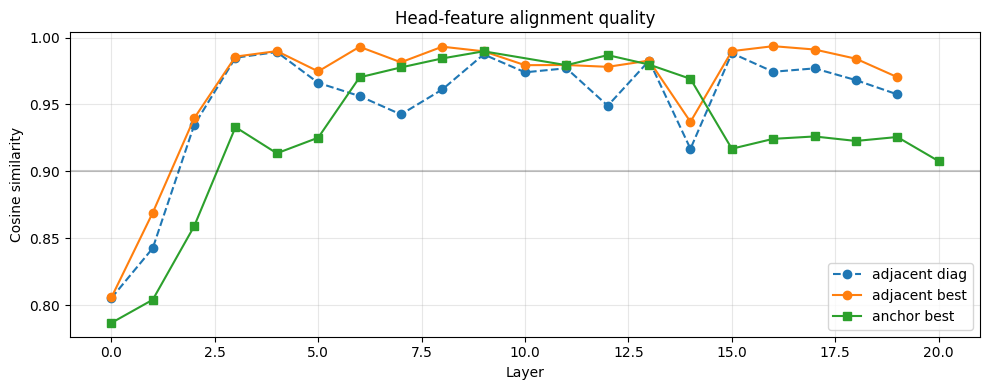


=== Cluster lifecycle table ===


cluster  first_layer  last_layer  lifespan_layers  occupancy_sum
6        6            0          20               21          4.125
5        5            1          20               20          4.875
0        0            1          20               20          5.750
2        2            3          14               12          1.875
3        3            3          13               11          1.750
4        4            0           8                9          1.250
1        1            1           5                5          1.375

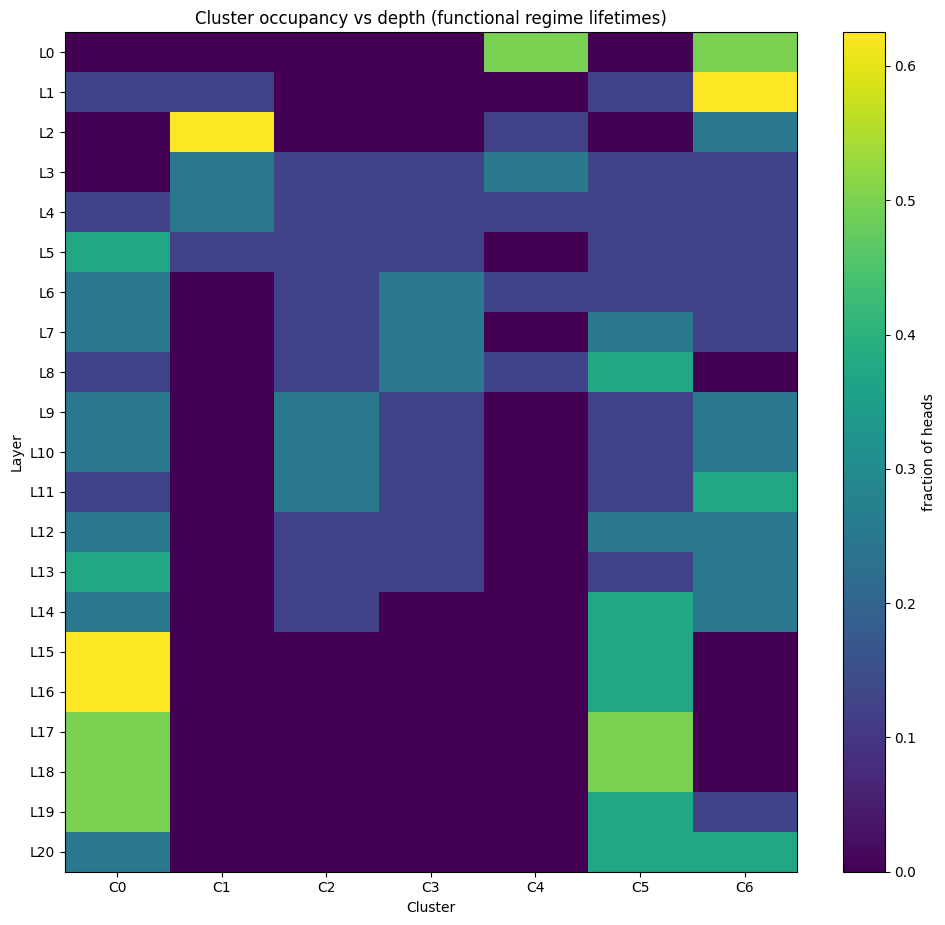


=== Per-slot role dynamics (anchor slot basis) ===


slot  switches   entropy  mean_inertia_lag1  mean_inertia_mean  \
6     6        16  1.370108           0.831701           0.762740   
4     4        14  1.343810           0.797612           0.716683   
1     1        12  1.703474           0.840957           0.508227   
7     7        11  1.141227           0.775435           0.687611   
3     3         9  1.084432           0.843045           0.555160   
2     2         9  1.549207           0.822960           0.692053   
0     0         9  1.543234           0.869578           0.572966   
5     5         9  1.329011           0.795863           0.706419   

   mean_inertia_slope  mean_inertia_half_lag  mean_tok_ent  mean_eff_slots  \
6           -0.000563               6.142857      2.238092        9.751246   
4           -0.000549               5.190476      2.231377        9.551824   
1           -0.005247               9.238095      1.880283        7.532931   
7           -0.000500               3.523809      2.168222        8.965186   
3           -0.006275              14.952381      2.064630        8.401625   
2           -0.001368               6.428571      2.245734        9.832481   
0           -0.005576              12.857142      1.964522        8.487477   
5           -0.000559               3.142857      2.222337        9.558954   

   mean_top4_mass  mean_write_tail_half_life  mean_write_ess  
6        0.617327                 121.655014      175.450668  
4        0.626058                 157.968918      142.544754  
1        0.725959                  56.974430       27.676491  
7        0.653359                  98.822334      125.200928  
3        0.679789                  83.658310       39.343853  
2        0.606451                 137.518631       64.307678  
0        0.680215                  20.431377       16.716669  
5        0.623260                 169.672394       86.258408

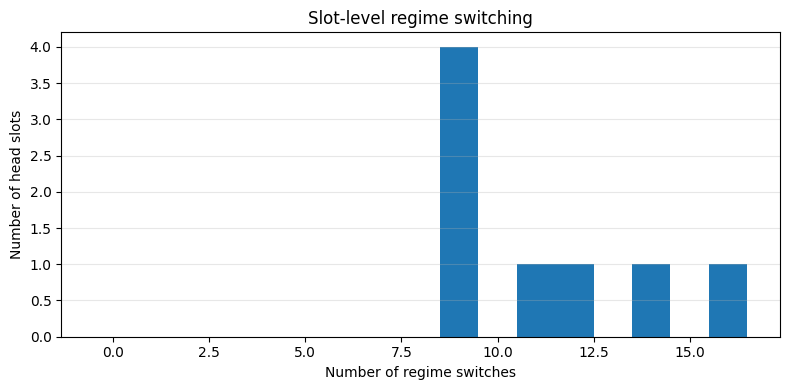


=== Correlation of regime switching with head features ===


feature  corr_with_switches
8             write_ess            0.762167
1          inertia_mean            0.445297
2         inertia_slope            0.414183
4               tok_ent            0.241752
5             eff_slots            0.219375
7  write_tail_half_life            0.218609
0          inertia_lag1           -0.159953
6             top4_mass           -0.180858
3      inertia_half_lag           -0.330917

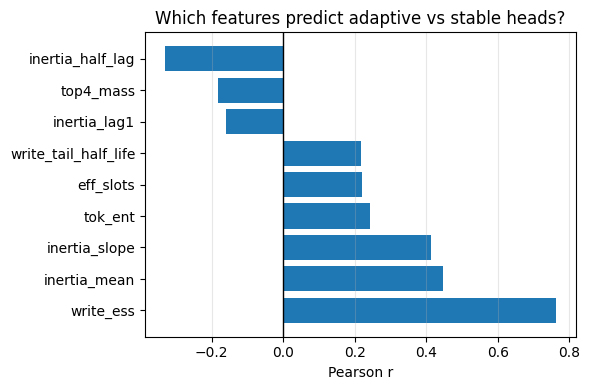

In [112]:
#@title Head functional regimes across depth (FINAL, curated analysis cell)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ASSUMES ALREADY COMPUTED (from previous pipeline):
#   - feat_by_layer
#   - feat_aligned        (anchor-aligned feature bank)
#   - feature_names
#   - results["aligned_anchor"]
#   - perm_anchor_to_l
#   - valid_layers
#   - ANCHOR_LAYER
# ============================================================

R = results["aligned"] # Corrected: Access 'aligned' key
cluster_by_layer = R["cluster_by_layer"]
k = N_CLUSTERS
layers = sorted(cluster_by_layer.keys())
L = len(layers)
H = len(cluster_by_layer[layers[0]])

# ============================================================
# 1. ALIGNMENT QUALITY (METHOD VALIDATION)
# ============================================================

df_align_adj = pd.DataFrame(
    [{k: v for k, v in r.items() if k != "perm"} for r in align_rows_adj]
)

df_align_anchor = pd.DataFrame(
    [{k: v for k, v in r.items() if k != "perm"} for r in anchor_rows]
).sort_values("l")

print("\n=== Alignment diagnostics ===")
display(df_align_adj[["l","diag_cos","best_cos","improvement"]])
display(df_align_anchor[["l","diag_cos","best_cos","improvement"]])

plt.figure(figsize=(10,4))
plt.plot(df_align_adj["l"], df_align_adj["diag_cos"], "o--", label="adjacent diag")
plt.plot(df_align_adj["l"], df_align_adj["best_cos"], "o-", label="adjacent best")
plt.plot(df_align_anchor["l"], df_align_anchor["best_cos"], "s-", label="anchor best")
plt.axhline(0.9, color="k", alpha=0.2)
plt.xlabel("Layer")
plt.ylabel("Cosine similarity")
plt.title("Head-feature alignment quality")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. CLUSTER LIFECYCLE (CORE RESULT)
# ============================================================

def cluster_lifecycle(cluster_by_layer, k):
    occ = np.zeros((L, k), dtype=np.float32)
    for i, l in enumerate(layers):
        v = np.asarray(cluster_by_layer[l])
        for c in range(k):
            occ[i, c] = (v == c).mean()

    first, last, life = [], [], []
    for c in range(k):
        idx = np.where(occ[:,c] > 0)[0]
        if len(idx) == 0:
            first.append(np.nan); last.append(np.nan); life.append(np.nan)
        else:
            first.append(layers[idx[0]])
            last.append(layers[idx[-1]])
            life.append(layers[idx[-1]] - layers[idx[0]] + 1)

    df = pd.DataFrame({
        "cluster": np.arange(k),
        "first_layer": first,
        "last_layer": last,
        "lifespan_layers": life,
        "occupancy_sum": occ.sum(axis=0),
    })
    return df, occ

df_life, occ = cluster_lifecycle(cluster_by_layer, k)

print("\n=== Cluster lifecycle table ===")
display(df_life.sort_values("lifespan_layers", ascending=False))

plt.figure(figsize=(10,0.35*L+2))
plt.imshow(occ, aspect="auto")
plt.yticks(range(L), [f"L{l}" for l in layers])
plt.xticks(range(k), [f"C{c}" for c in range(k)])
plt.colorbar(label="fraction of heads")
plt.title("Cluster occupancy vs depth (functional regime lifetimes)")
plt.xlabel("Cluster")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

# ============================================================
# 3. SLOT-LEVEL ROLE DYNAMICS (KILLER RESULT)
# ============================================================

# cluster assignments in anchor slot basis
mat = np.stack([cluster_by_layer[l] for l in layers], axis=0)  # [L,H]

# number of regime switches per slot
switches = (mat[1:] != mat[:-1]).sum(axis=0)

# entropy per slot
def slot_entropy(mat):
    ent = np.zeros((H,), dtype=np.float32)
    for h in range(H):
        u,c = np.unique(mat[:,h], return_counts=True)
        p = c / c.sum()
        ent[h] = -np.sum(p*np.log(p+1e-12))
    return ent

ent = slot_entropy(mat)

# mean feature vector per slot
Xs = np.stack([feat_aligned[l] for l in layers], axis=0)  # [L,H,D]
feat_mean = Xs.mean(axis=0)

df_slot = pd.DataFrame({
    "slot": np.arange(H),
    "switches": switches,
    "entropy": ent,
})

for j, name in enumerate(feature_names):
    df_slot[f"mean_{name}"] = feat_mean[:, j]

print("\n=== Per-slot role dynamics (anchor slot basis) ===")
display(df_slot.sort_values("switches", ascending=False))

plt.figure(figsize=(8,4))
plt.hist(switches, bins=np.arange(switches.max()+2)-0.5)
plt.xlabel("Number of regime switches")
plt.ylabel("Number of head slots")
plt.title("Slot-level regime switching")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 4. MECHANISTIC CORRELATES OF ADAPTIVITY
# ============================================================

corr_rows = []
y = switches.astype(np.float64)
for j, name in enumerate(feature_names):
    x = feat_mean[:, j].astype(np.float64)
    if x.std() < 1e-12 or y.std() < 1e-12:
        r = np.nan
    else:
        r = float(np.corrcoef(x, y)[0,1])
    corr_rows.append({"feature": name, "corr_with_switches": r})

df_corr = pd.DataFrame(corr_rows).sort_values("corr_with_switches", ascending=False)

print("\n=== Correlation of regime switching with head features ===")
display(df_corr)

plt.figure(figsize=(6,4))
plt.barh(df_corr["feature"], df_corr["corr_with_switches"])
plt.axvline(0, color="k", lw=1)
plt.xlabel("Pearson r")
plt.title("Which features predict adaptive vs stable heads?")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [113]:

# ============================================================
#@title ROBUST CORRELATION ANALYSIS (small-n safe)
# ============================================================

from scipy.stats import spearmanr

def bootstrap_corr(x, y, kind="pearson", n_boot=5000, seed=0, alpha=0.05):
    """
    Bootstrap CI for correlation.
    kind: "pearson" or "spearman"
    Returns: (point_estimate, lo, hi)
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    if kind == "pearson":
        point = np.corrcoef(x, y)[0,1]
    elif kind == "spearman":
        point = spearmanr(x, y).correlation
    else:
        raise ValueError("kind must be pearson or spearman")

    boots = []
    n = len(x)
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        xb = x[idx]
        yb = y[idx]
        if kind == "pearson":
            r = np.corrcoef(xb, yb)[0,1]
        else:
            r = spearmanr(xb, yb).correlation
        boots.append(r)

    boots = np.asarray(boots)
    lo = float(np.quantile(boots, alpha/2))
    hi = float(np.quantile(boots, 1-alpha/2))
    return float(point), lo, hi

# ------------------------------------------------------------------
# Compute robust correlations: switches vs mean features
# ------------------------------------------------------------------

rows = []
x_switch = df_slot["switches"].to_numpy().astype(np.float64)

for name in feature_names:
    y = df_slot[f"mean_{name}"].to_numpy().astype(np.float64)

    if x_switch.std() < 1e-12 or y.std() < 1e-12:
        continue

    p_r, p_lo, p_hi = bootstrap_corr(x_switch, y, kind="pearson", seed=SEED)
    s_r, s_lo, s_hi = bootstrap_corr(x_switch, y, kind="spearman", seed=SEED+1)

    rows.append({
        "feature": name,
        "pearson_r": p_r,
        "pearson_CI": f"[{p_lo:.2f}, {p_hi:.2f}]",
        "spearman_r": s_r,
        "spearman_CI": f"[{s_lo:.2f}, {s_hi:.2f}]",
    })

df_corr_robust = (
    pd.DataFrame(rows)
      .sort_values("spearman_r", ascending=False)
      .reset_index(drop=True)
)

print("\n=== Robust correlations: regime switching vs head features ===")
display(df_corr_robust)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipython-input-2898321166.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = spearmanr(xb, yb).correlation



=== Robust correlations: regime switching vs head features ===


feature  pearson_r  pearson_CI  spearman_r spearman_CI
0             write_ess   0.762167  [nan, nan]    0.646867  [nan, nan]
1         inertia_slope   0.414183  [nan, nan]    0.443928  [nan, nan]
2          inertia_mean   0.445297  [nan, nan]    0.431244  [nan, nan]
3               tok_ent   0.241752  [nan, nan]    0.177571  [nan, nan]
4  write_tail_half_life   0.218609  [nan, nan]    0.101469  [nan, nan]
5             eff_slots   0.219375  [nan, nan]    0.063418  [nan, nan]
6             top4_mass  -0.180858  [nan, nan]   -0.063418  [nan, nan]
7          inertia_lag1  -0.159953  [nan, nan]   -0.190255  [nan, nan]
8      inertia_half_lag  -0.330917  [nan, nan]   -0.266357  [nan, nan]

Found slot_keys in 21 layers: [0, 1, 2, 3, 4] ... [16, 17, 18, 19, 20]

=== Slot embedding summary (per layer) ===


layer  H   K   d  norm_mean  norm_std  intra_div_mean  intra_div_std  \
0       0  8  16  48   1.179666  0.238733        0.841918       0.165113   
1       1  8  16  48   1.420122  0.258993        0.747344       0.208385   
2       2  8  16  48   1.520422  0.317764        0.776998       0.248762   
3       3  8  16  48   1.563549  0.308001        0.839506       0.263607   
4       4  8  16  48   1.521343  0.339039        0.820560       0.272875   
5       5  8  16  48   1.517192  0.314676        0.869087       0.274193   
6       6  8  16  48   1.587103  0.286920        0.827128       0.283119   
7       7  8  16  48   1.717768  0.389037        0.865642       0.268297   
8       8  8  16  48   1.720276  0.317336        0.799486       0.272887   
9       9  8  16  48   1.782413  0.345909        0.782355       0.257601   
10     10  8  16  48   1.819164  0.373297        0.811987       0.264176   
11     11  8  16  48   1.803444  0.373353        0.793907       0.278976   
12     12  8  16  48   1.859487  0.351297        0.778096       0.261281   
13     13  8  16  48   1.842621  0.344026        0.772068       0.252774   
14     14  8  16  48   1.734768  0.291375        0.736637       0.258950   
15     15  8  16  48   1.938296  0.364264        0.804577       0.228378   
16     16  8  16  48   1.834294  0.333644        0.783675       0.256434   
17     17  8  16  48   1.832587  0.378004        0.788300       0.237061   
18     18  8  16  48   1.858039  0.309183        0.814013       0.271330   
19     19  8  16  48   1.902183  0.352339        0.817329       0.299911   
20     20  8  16  48   1.950504  0.403325        0.859959       0.402477   

    inter_same_slot_mean  inter_same_slot_std  global_cos_mean  \
0               0.005169             0.148730         0.021513   
1               0.001671             0.165572         0.032280   
2              -0.012153             0.152950         0.008488   
3               0.007643             0.152474         0.022592   
4               0.005602             0.148715         0.028117   
5               0.007048             0.150910         0.014788   
6               0.004650             0.154229         0.028972   
7              -0.002578             0.156164         0.011584   
8              -0.005629             0.144502         0.024531   
9              -0.010209             0.142810         0.019084   
10             -0.006000             0.150694         0.019543   
11             -0.005594             0.146159         0.032546   
12             -0.003889             0.161771         0.025771   
13              0.004357             0.151304         0.039900   
14             -0.006205             0.146027         0.023604   
15             -0.010795             0.148520         0.015221   
16              0.007690             0.154713         0.024199   
17             -0.005273             0.150479         0.027827   
18             -0.006544             0.147991         0.018638   
19              0.003952             0.146696         0.018315   
20              0.000544             0.152310         0.012900   

    global_cos_std  dead_frac  
0         0.162240        0.0  
1         0.190731        0.0  
2         0.187541        0.0  
3         0.184269        0.0  
4         0.181882        0.0  
5         0.175873        0.0  
6         0.183842        0.0  
7         0.180417        0.0  
8         0.186121        0.0  
9         0.188181        0.0  
10        0.178017        0.0  
11        0.188113        0.0  
12        0.188516        0.0  
13        0.183847        0.0  
14        0.188380        0.0  
15        0.176393        0.0  
16        0.179033        0.0  
17        0.175995        0.0  
18        0.180824        0.0  
19        0.182642        0.0  
20        0.212669        0.0

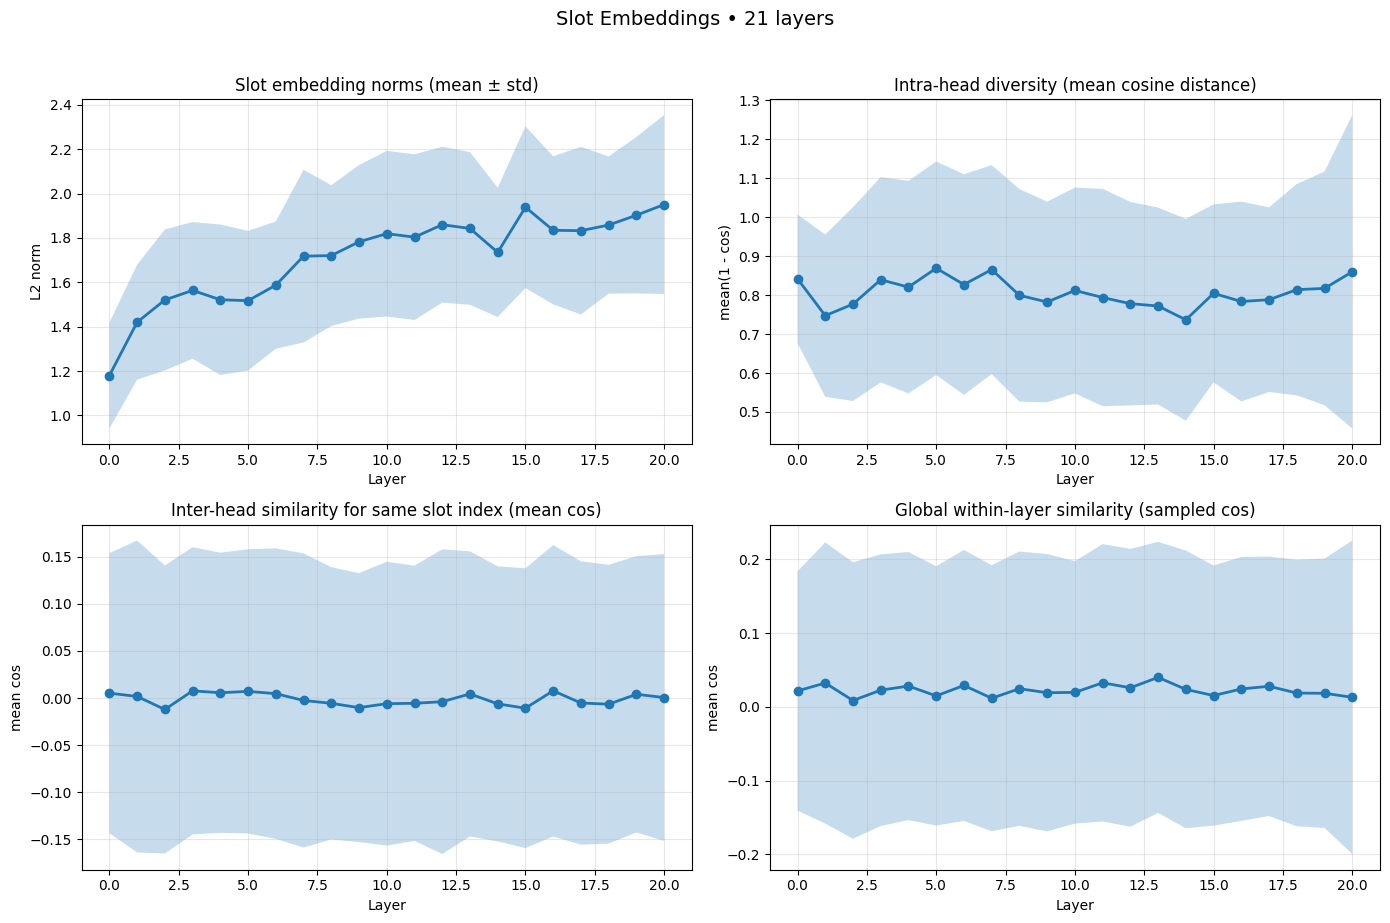

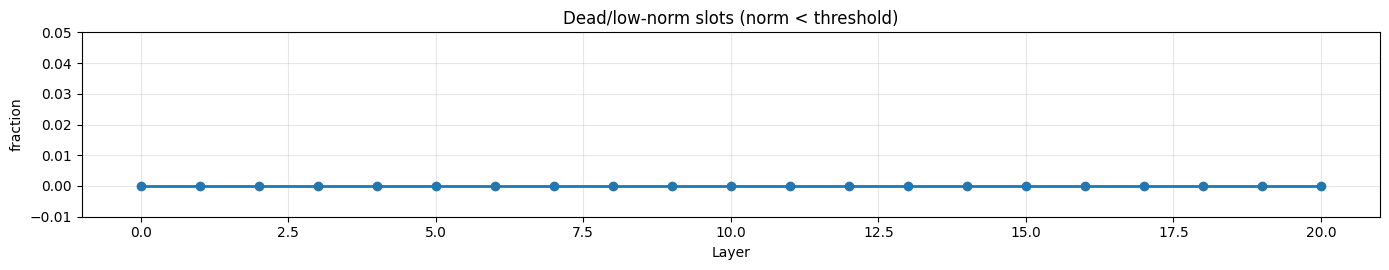


=== Most specialized layers (highest intra-head diversity) ===


layer  norm_mean  intra_div_mean  inter_same_slot_mean  global_cos_mean  \
5       5   1.517192        0.869087              0.007048         0.014788   
7       7   1.717768        0.865642             -0.002578         0.011584   
20     20   1.950504        0.859959              0.000544         0.012900   
0       0   1.179666        0.841918              0.005169         0.021513   
3       3   1.563549        0.839506              0.007643         0.022592   

    dead_frac  
5         0.0  
7         0.0  
20        0.0  
0         0.0  
3         0.0


=== Most collapsed layers (highest global cosine similarity) ===


layer  norm_mean  intra_div_mean  inter_same_slot_mean  global_cos_mean  \
13     13   1.842621        0.772068              0.004357         0.039900   
11     11   1.803444        0.793907             -0.005594         0.032546   
1       1   1.420122        0.747344              0.001671         0.032280   
6       6   1.587103        0.827128              0.004650         0.028972   
4       4   1.521343        0.820560              0.005602         0.028117   

    dead_frac  
13        0.0  
11        0.0  
1         0.0  
6         0.0  
4         0.0


=== Least diverse within-head (lowest intra-head diversity) ===


layer  norm_mean  intra_div_mean  inter_same_slot_mean  global_cos_mean  \
14     14   1.734768        0.736637             -0.006205         0.023604   
1       1   1.420122        0.747344              0.001671         0.032280   
13     13   1.842621        0.772068              0.004357         0.039900   
2       2   1.520422        0.776998             -0.012153         0.008488   
12     12   1.859487        0.778096             -0.003889         0.025771   

    dead_frac  
14        0.0  
1         0.0  
13        0.0  
2         0.0  
12        0.0


Representative layers (compact views): [0, 5, 10, 14, 20]


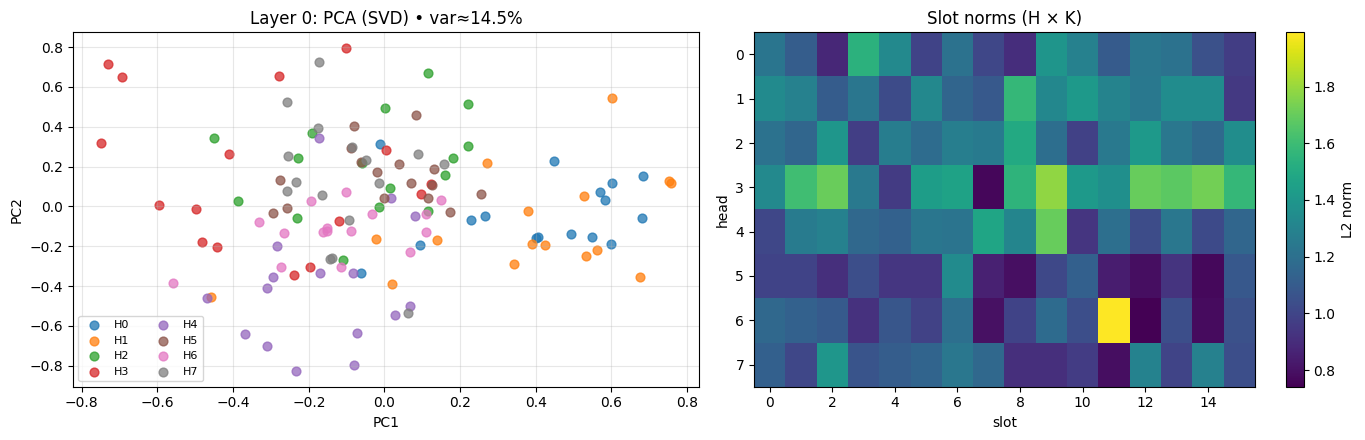

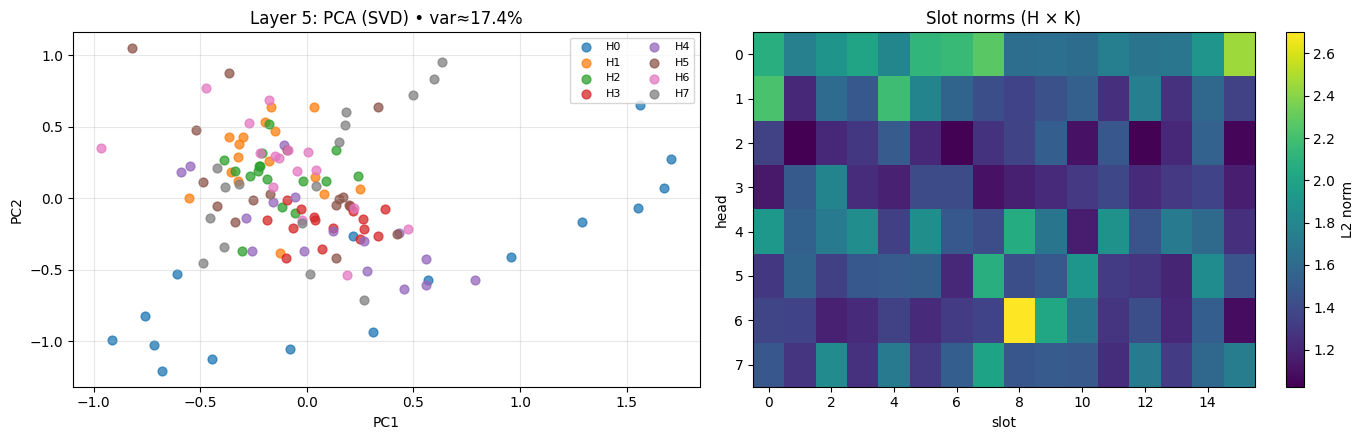

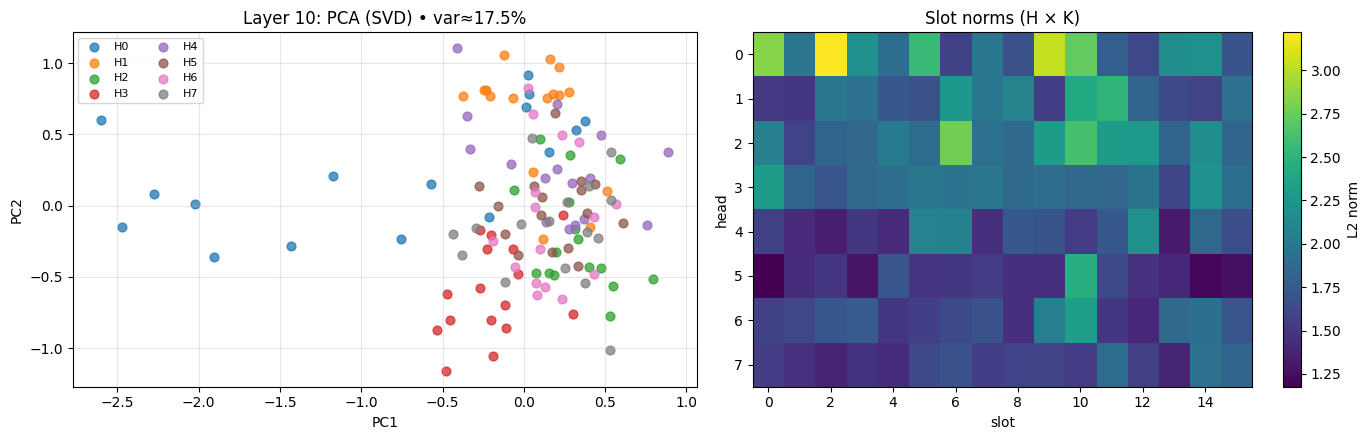

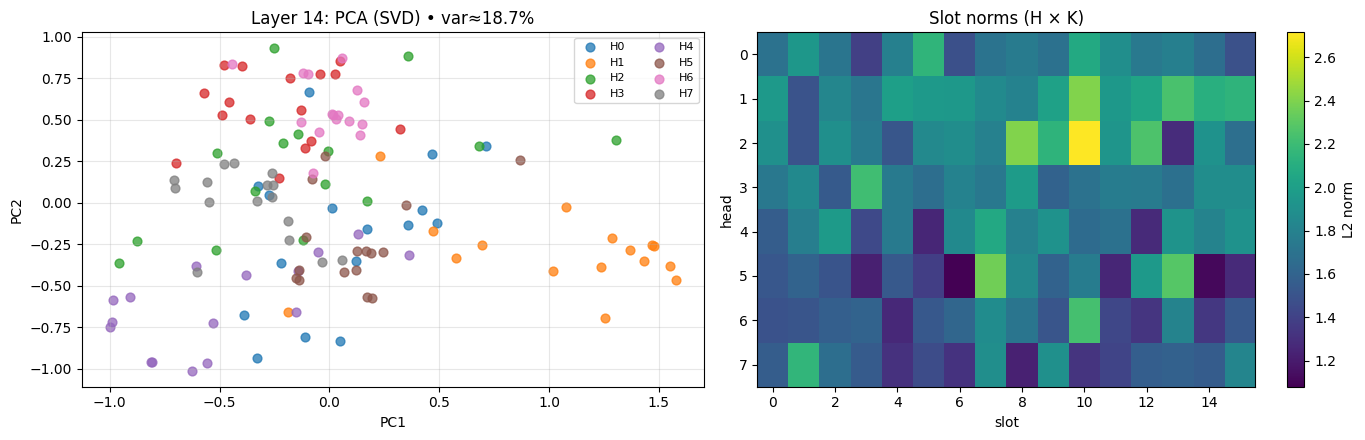

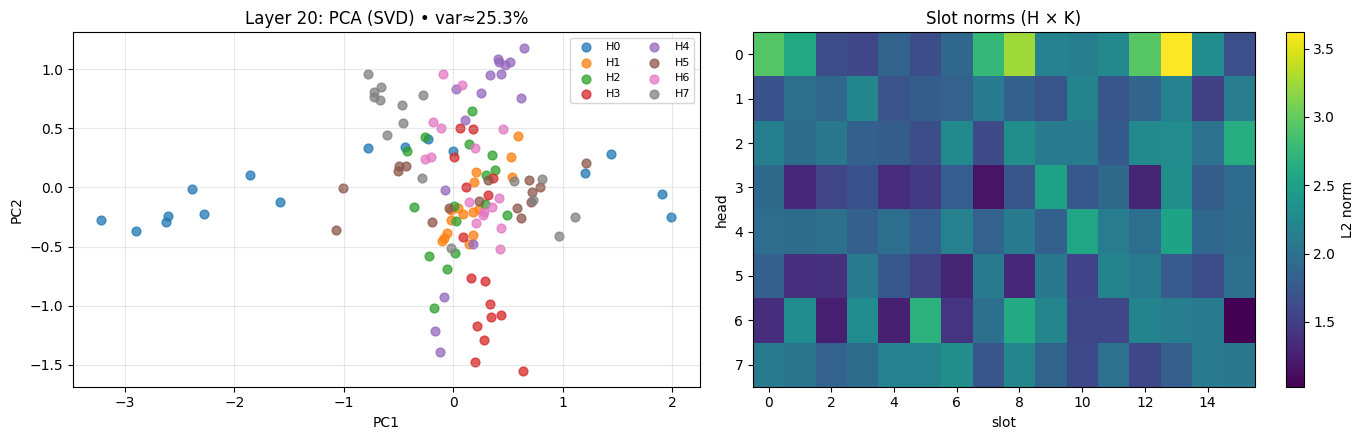

In [114]:

#@title Slot Embeddings — compact, rigorous, low-overload (HF-loaded + ckpt_obj available)

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# =============================================================================
# State dict resolution (HF-loaded model + ckpt_obj)
# =============================================================================

def resolve_state_dict(*, model=None, ckpt_obj=None):
    """
    Resolve a PyTorch state_dict from either:
      - ckpt_obj (already loaded object; dict or state_dict-like)
      - model (HF-loaded model; uses model.state_dict())

    Priority: ckpt_obj > model
    """
    if ckpt_obj is not None:
        # common checkpoint wrappers
        if isinstance(ckpt_obj, dict):
            if "model_state_dict" in ckpt_obj:
                return ckpt_obj["model_state_dict"]
            if "state_dict" in ckpt_obj:
                return ckpt_obj["state_dict"]
            if "model" in ckpt_obj and isinstance(ckpt_obj["model"], dict):
                return ckpt_obj["model"]
        # might already be a plain state_dict
        return ckpt_obj

    if model is None:
        raise ValueError("Need either ckpt_obj or model to resolve state_dict.")
    return model.state_dict()

def extract_slot_keys_by_layer(state_dict):
    """
    Returns dict: layer -> tensor [H,K,d] for keys that contain 'slot_keys'.
    Expected key pattern: blocks.{layer}.attn.slot_keys
    """
    slot = {}
    for k, v in state_dict.items():
        if "slot_keys" not in k:
            continue
        try:
            li = int(k.split(".")[1])
        except Exception:
            continue
        slot[li] = v.detach().cpu()
    return slot

# =============================================================================
# Metrics
# =============================================================================

def _cos_sim(a, b, eps=1e-12):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(np.dot(a, b))

def _pairwise_cosine_stats(X, max_pairs=4000, seed=0):
    """
    X: [N,d], returns mean/std cosine similarity over sampled random pairs.
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    if N < 2:
        return np.nan, np.nan

    P = min(max_pairs, N * (N - 1) // 2)
    sims = np.empty((P,), dtype=np.float32)
    for p in range(P):
        i = rng.integers(0, N)
        j = rng.integers(0, N - 1)
        if j >= i:
            j += 1
        sims[p] = _cos_sim(X[i], X[j])
    return float(sims.mean()), float(sims.std())

def compute_slot_metrics(slot_by_layer, pair_samples=5000, seed=0, dead_thr=0.10):
    """
    Per-layer metrics summarizing slot embeddings:
      - norms mean/std
      - intra-head diversity (mean cosine distance within head)
      - inter-head similarity for same slot index across heads (mean cosine sim)
      - global pairwise cosine similarity within layer (sampled)
      - dead slot fraction (norm < dead_thr)
    """
    rows = []
    layers = sorted(slot_by_layer.keys())
    for l in layers:
        S = slot_by_layer[l].numpy()  # [H,K,d]
        H, K, d = S.shape
        X = S.reshape(-1, d).astype(np.float32)

        norms = np.linalg.norm(X, axis=1)
        norm_mean = float(norms.mean())
        norm_std  = float(norms.std())
        dead_frac = float((norms < dead_thr).mean())

        # Intra-head diversity = mean(1 - cos) within each head, then mean across heads
        intra_means = []
        intra_stds  = []
        for h in range(H):
            head = S[h].astype(np.float32)  # [K,d]
            # all pairs (K=16 in your config; fine)
            sims = []
            for i in range(K):
                for j in range(i + 1, K):
                    sims.append(_cos_sim(head[i], head[j]))
            sims = np.asarray(sims, dtype=np.float32)
            div = 1.0 - sims
            intra_means.append(float(div.mean()))
            intra_stds.append(float(div.std()))

        intra_div_mean = float(np.mean(intra_means))
        intra_div_std  = float(np.mean(intra_stds))

        # Inter-head similarity for same slot index across heads
        inter_means = []
        inter_stds  = []
        for k in range(K):
            across = S[:, k, :].astype(np.float32)  # [H,d]
            sims = []
            for i in range(H):
                for j in range(i + 1, H):
                    sims.append(_cos_sim(across[i], across[j]))
            sims = np.asarray(sims, dtype=np.float32)
            inter_means.append(float(sims.mean()))
            inter_stds.append(float(sims.std()))

        inter_same_slot_mean = float(np.mean(inter_means))
        inter_same_slot_std  = float(np.mean(inter_stds))

        global_cos_mean, global_cos_std = _pairwise_cosine_stats(X, max_pairs=pair_samples, seed=seed + 101*l)

        rows.append(dict(
            layer=int(l), H=int(H), K=int(K), d=int(d),
            norm_mean=norm_mean, norm_std=norm_std,
            intra_div_mean=intra_div_mean, intra_div_std=intra_div_std,
            inter_same_slot_mean=inter_same_slot_mean, inter_same_slot_std=inter_same_slot_std,
            global_cos_mean=global_cos_mean, global_cos_std=global_cos_std,
            dead_frac=dead_frac,
        ))

    return pd.DataFrame(rows)

# =============================================================================
# Plotting (one overview dashboard + optional representative layers)
# =============================================================================

def plot_slot_overview(df, title="Slot Embedding Overview"):
    layers = df["layer"].to_numpy()

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))

    ax = axes[0, 0]
    ax.plot(layers, df["norm_mean"], "o-", lw=2)
    ax.fill_between(layers, df["norm_mean"] - df["norm_std"], df["norm_mean"] + df["norm_std"], alpha=0.25)
    ax.set_title("Slot embedding norms (mean ± std)")
    ax.set_xlabel("Layer"); ax.set_ylabel("L2 norm")
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(layers, df["intra_div_mean"], "o-", lw=2)
    ax.fill_between(layers, df["intra_div_mean"] - df["intra_div_std"], df["intra_div_mean"] + df["intra_div_std"], alpha=0.25)
    ax.set_title("Intra-head diversity (mean cosine distance)")
    ax.set_xlabel("Layer"); ax.set_ylabel("mean(1 - cos)")
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.plot(layers, df["inter_same_slot_mean"], "o-", lw=2)
    ax.fill_between(layers, df["inter_same_slot_mean"] - df["inter_same_slot_std"], df["inter_same_slot_mean"] + df["inter_same_slot_std"], alpha=0.25)
    ax.set_title("Inter-head similarity for same slot index (mean cos)")
    ax.set_xlabel("Layer"); ax.set_ylabel("mean cos")
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.plot(layers, df["global_cos_mean"], "o-", lw=2)
    ax.fill_between(layers, df["global_cos_mean"] - df["global_cos_std"], df["global_cos_mean"] + df["global_cos_std"], alpha=0.25)
    ax.set_title("Global within-layer similarity (sampled cos)")
    ax.set_xlabel("Layer"); ax.set_ylabel("mean cos")
    ax.grid(True, alpha=0.3)

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 2.8))
    plt.plot(layers, df["dead_frac"], "o-", lw=2)
    plt.ylim(-0.01, max(0.05, float(df["dead_frac"].max()) + 0.01))
    plt.grid(True, alpha=0.3)
    plt.xlabel("Layer"); plt.ylabel("fraction")
    plt.title("Dead/low-norm slots (norm < threshold)")
    plt.tight_layout()
    plt.show()

def visualize_single_layer_compact(slots_tensor, layer_idx, show_similarity=False):
    """
    Compact layer view:
      - PCA (SVD) scatter colored by head
      - norms heatmap (H x K)
      - optional HKxHK cosine similarity matrix (heavy; off by default)
    """
    S = slots_tensor.detach().cpu().numpy().astype(np.float32)  # [H,K,d]
    H, K, d = S.shape
    X = S.reshape(-1, d)

    # PCA via SVD
    Xc = X - X.mean(axis=0, keepdims=True)
    U, s, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z = Xc @ Vt[:2].T
    var2 = float((s[:2]**2).sum() / (s**2).sum())

    fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

    ax = axes[0]
    for h in range(H):
        i0, i1 = h*K, (h+1)*K
        ax.scatter(Z[i0:i1, 0], Z[i0:i1, 1], s=40, alpha=0.75, label=(f"H{h}" if H <= 12 else None))
    ax.set_title(f"Layer {layer_idx}: PCA (SVD) • var≈{var2:.1%}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)
    if H <= 12:
        ax.legend(ncol=2, fontsize=8, frameon=True)

    ax = axes[1]
    norms = np.linalg.norm(X, axis=1).reshape(H, K)
    im = ax.imshow(norms, aspect="auto")
    ax.set_title("Slot norms (H × K)")
    ax.set_xlabel("slot"); ax.set_ylabel("head")
    plt.colorbar(im, ax=ax, label="L2 norm")

    plt.tight_layout()
    plt.show()

    if show_similarity:
        Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
        sim = Xn @ Xn.T  # [HK,HK]
        plt.figure(figsize=(7, 6))
        plt.imshow(sim, vmin=-1, vmax=1, aspect="auto", cmap="RdBu_r")
        for h in range(1, H):
            plt.axhline(h*K - 0.5, color="white", lw=1.5, alpha=0.9)
            plt.axvline(h*K - 0.5, color="white", lw=1.5, alpha=0.9)
        plt.title(f"Layer {layer_idx}: cosine similarity (HK×HK)")
        plt.xlabel("slot index"); plt.ylabel("slot index")
        plt.colorbar(label="cos sim")
        plt.tight_layout()
        plt.show()

def pick_representative_layers(df, n=5):
    layers = df["layer"].to_numpy()
    picks = {int(layers[0]), int(layers[len(layers)//2]), int(layers[-1])}
    picks.add(int(df.loc[df["intra_div_mean"].idxmax(), "layer"]))
    picks.add(int(df.loc[df["intra_div_mean"].idxmin(), "layer"]))
    picks = list(dict.fromkeys(sorted(picks)))  # unique, sorted
    return picks[:n]

# =============================================================================
# Run (assumes: HF model is loaded and ckpt_obj is available)
# =============================================================================

# You said: assume ckpt_obj is available; also model is HF-loaded.
# We won't force either name; try common names.
_model = globals().get("model", None)
_ckpt_obj = globals().get("ckpt_obj", None)

state_dict = resolve_state_dict(model=_model, ckpt_obj=_ckpt_obj)
slot_by_layer = extract_slot_keys_by_layer(state_dict)

layers = sorted(slot_by_layer.keys())
print(f"Found slot_keys in {len(layers)} layers: {layers[:5]} ... {layers[-5:]}")

df_slots = compute_slot_metrics(slot_by_layer, pair_samples=5000, seed=0, dead_thr=0.10)

print("\n=== Slot embedding summary (per layer) ===")
display(df_slots)

plot_slot_overview(df_slots, title=f"Slot Embeddings • {len(df_slots)} layers")

cols_show = ["layer", "norm_mean", "intra_div_mean", "inter_same_slot_mean", "global_cos_mean", "dead_frac"]
df_rank = df_slots[cols_show].copy()

print("\n=== Most specialized layers (highest intra-head diversity) ===")
display(df_rank.sort_values("intra_div_mean", ascending=False).head(5))

print("\n=== Most collapsed layers (highest global cosine similarity) ===")
display(df_rank.sort_values("global_cos_mean", ascending=False).head(5))

print("\n=== Least diverse within-head (lowest intra-head diversity) ===")
display(df_rank.sort_values("intra_div_mean", ascending=True).head(5))

REP_LAYERS = pick_representative_layers(df_slots, n=5)
print(f"\nRepresentative layers (compact views): {REP_LAYERS}")

for l in REP_LAYERS:
    visualize_single_layer_compact(slot_by_layer[l], l, show_similarity=False)

# If you want ONE heavy similarity matrix:
# visualize_single_layer_compact(slot_by_layer[REP_LAYERS[0]], REP_LAYERS[0], show_similarity=True)

Extracted 2688 slot key vectors in 48-dim space.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


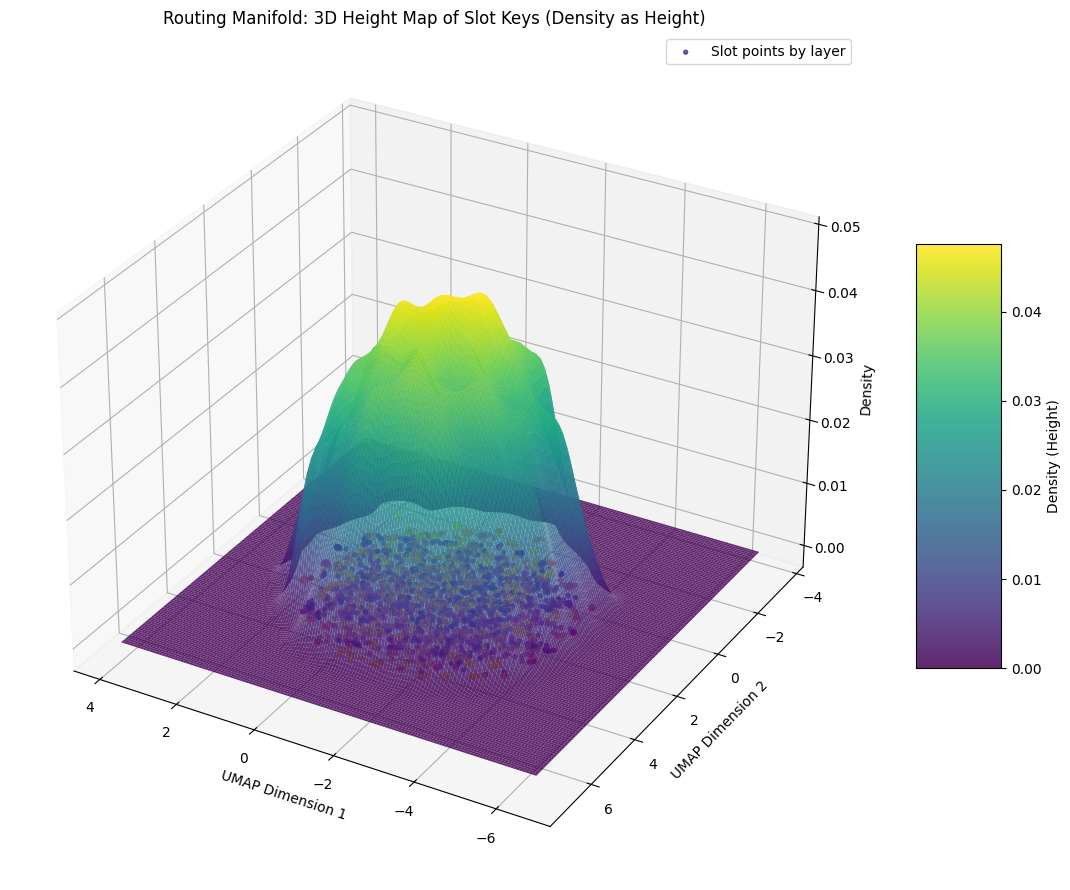

In [115]:

#@title slotkeys embedding density plot

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity
from scipy.interpolate import griddata

#from asa.load_pretrained import load_pretrained  # Your loader

# Load model (returns model, report, config or similar)
#model, *_ = load_pretrained()  # Add args like device='cpu', variant='default' if needed
#device = torch.device('cpu')   # Or 'cuda' if you have GPU
#model.to(device)
model.eval()

#print("Model loaded successfully.")

# Collect slot_keys from all layers
slot_keys_list = []
for layer_idx in range(21):
    attn = model.blocks[layer_idx].attn  # Direct access per your state_dict
    keys = attn.slot_keys.detach().cpu().numpy()  # [8 heads, 16 slots, 48 dim]
    slot_keys_list.append(keys)

slot_keys = np.stack(slot_keys_list)  # [21 layers, 8, 16, 48]

# Flatten into dataset of points: each (layer, head, slot) → one 48-dim vector
# Total points: 21 × 8 × 16 = 2688
data = slot_keys.reshape(-1, 48)

# Optional: Normalize per dimension (helps UMAP in high-dim)
data_mean = data.mean(axis=0)
data_std = data.std(axis=0) + 1e-8  # Avoid div-by-zero
data = (data - data_mean) / data_std

print(f"Extracted {data.shape[0]} slot key vectors in 48-dim space.")

# Step 1: UMAP projection to 2D (good for capturing clusters/manifold structure)
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,       # Tune for local vs global structure
    min_dist=0.1,
    metric='cosine',      # Cosine often better for embeddings
    random_state=42
)
proj_2d = reducer.fit_transform(data)

# Step 2: Density-based height map via KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(proj_2d)  # Bandwidth ~0.2-0.5; tune for smoothness
x_min, x_max = proj_2d[:, 0].min() - 2, proj_2d[:, 0].max() + 2
y_min, y_max = proj_2d[:, 1].min() - 2, proj_2d[:, 1].max() + 2
x_grid, y_grid = np.mgrid[x_min:x_max:150j, y_min:y_max:150j]  # Higher res for detail
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
log_dens = kde.score_samples(grid_points)
heights = np.exp(log_dens).reshape(x_grid.shape)

# Step 3: 3D Surface Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(x_grid, y_grid, heights, cmap='viridis', alpha=0.85, rstride=1, cstride=1)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Density (Height)')

# Optional: Scatter original points colored by layer (to see progression/switches)
layer_colors = np.repeat(np.arange(21), 8 * 16)  # [2688] with layer index
ax.scatter(proj_2d[:, 0], proj_2d[:, 1], np.zeros_like(proj_2d[:, 0]),
           c=layer_colors, cmap='plasma', s=8, alpha=0.6, label='Slot points by layer')

ax.set_title('Routing Manifold: 3D Height Map of Slot Keys (Density as Height)')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('Density')
ax.view_init(elev=30, azim=120)  # Nice viewing angle; rotate interactively in plt
plt.legend()
plt.tight_layout()
plt.show()

# Save if desired
# fig.savefig('routing_manifold_3d.png', dpi=300)

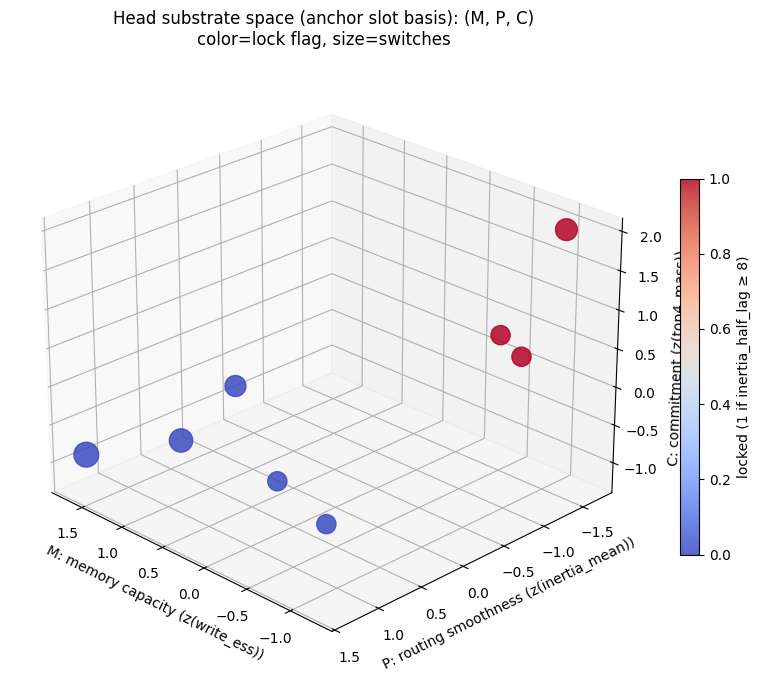

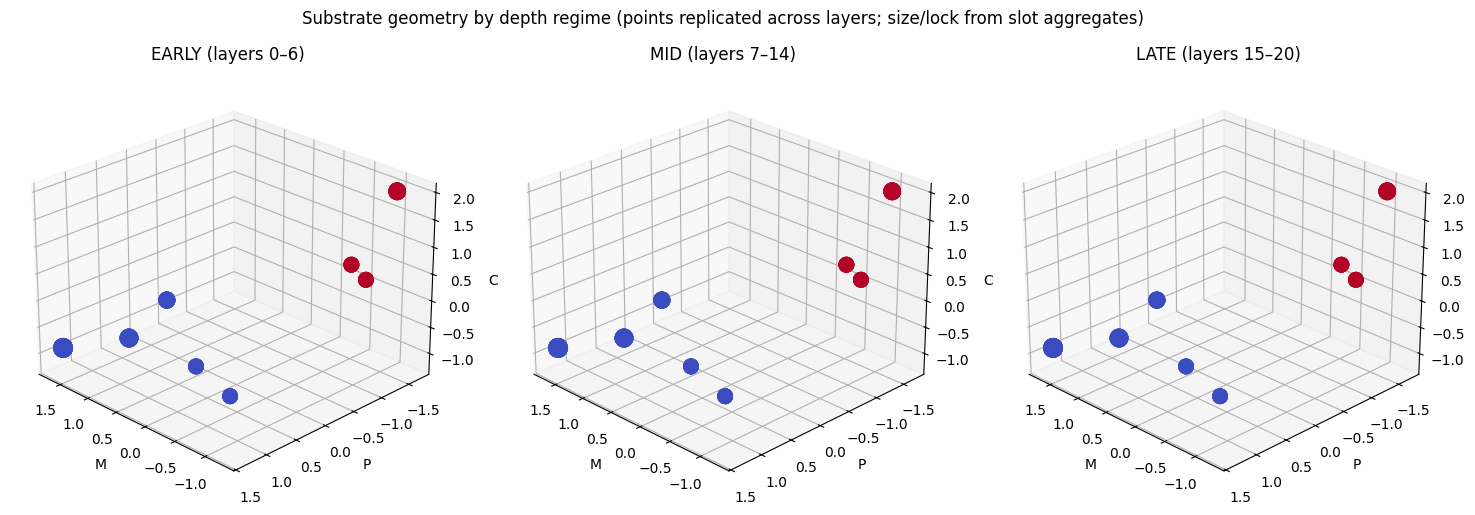

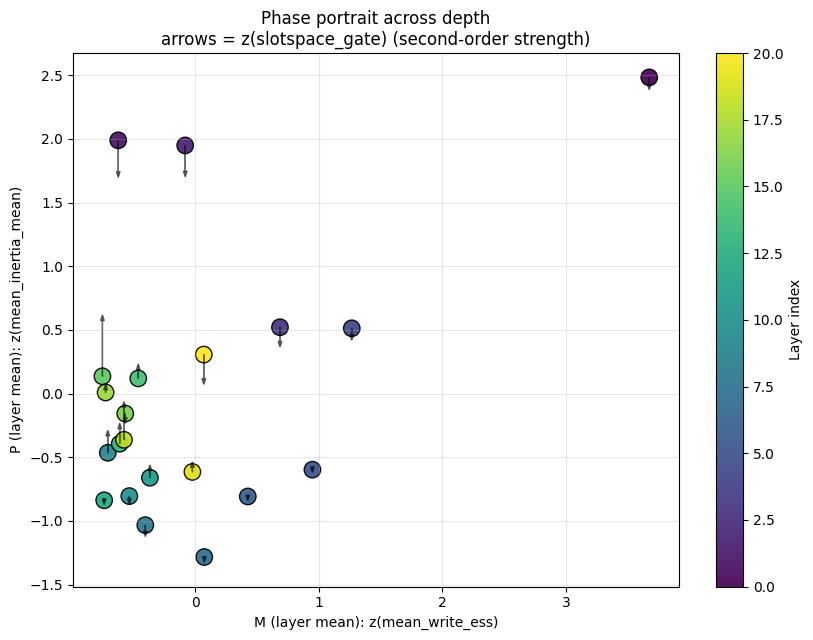

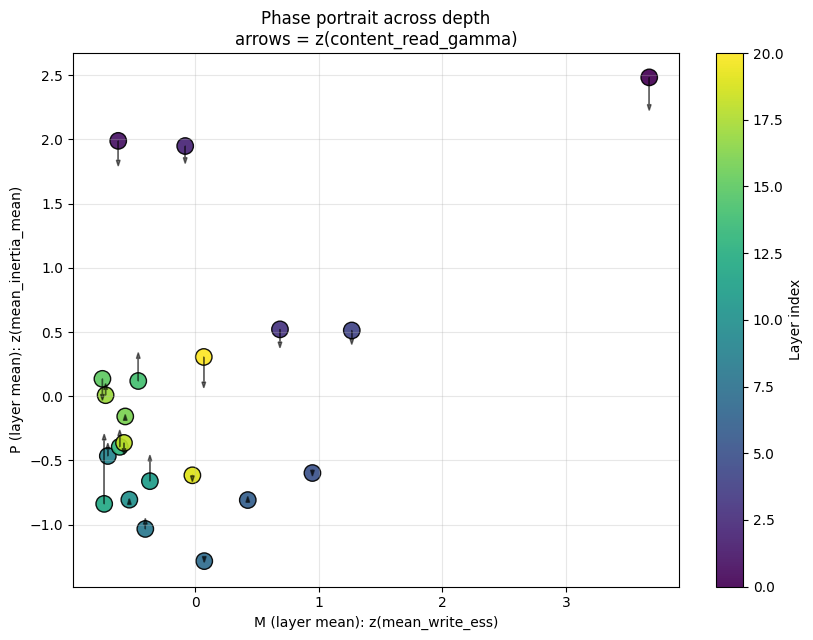

In [116]:

#@title Substrate visualization suite (FINAL, fixed second-order + true depth slices)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# 0) CONFIG
# ============================================================

LOCK_THRESHOLD = 8.0  # inertia_half_lag ≥ this → "locked"

DEPTH_BINS = {
    "early": list(range(0, 7)),    # L0–L6
    "mid":   list(range(7, 15)),   # L7–L14
    "late":  list(range(15, 21)),  # L15–L20
}

def z(x):
    x = np.asarray(x, dtype=np.float64)
    return (x - x.mean()) / (x.std() + 1e-8)

# ============================================================
# 1) PER-HEAD TABLE: (M,P,C,L,size)
# ============================================================

dfh = df_slot.copy()

# reduced coordinates
dfh["M"] = z(dfh["mean_write_ess"])
dfh["P"] = z(dfh["mean_inertia_mean"])
dfh["C"] = z(dfh["mean_top4_mass"])

# lock flag + size
dfh["locked"] = (dfh["mean_inertia_half_lag"] >= LOCK_THRESHOLD).astype(np.int32)
dfh["size"] = dfh["switches"].astype(np.float32)

# ============================================================
# 2) 3D SCATTER: (M, P, C), color by locked, size by switches
# ============================================================

def plot_3d_scatter(df, title):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        df["M"], df["P"], df["C"],
        c=df["locked"],
        cmap="coolwarm",
        s=30 + 18 * df["size"],
        alpha=0.85
    )

    ax.set_xlabel("M: memory capacity (z(write_ess))")
    ax.set_ylabel("P: routing smoothness (z(inertia_mean))")
    ax.set_zlabel("C: commitment (z(top4_mass))")
    ax.set_title(title)

    cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
    cbar.set_label(f"locked (1 if inertia_half_lag ≥ {LOCK_THRESHOLD:g})")

    ax.view_init(elev=25, azim=135)
    plt.tight_layout()
    plt.show()

plot_3d_scatter(dfh, "Head substrate space (anchor slot basis): (M, P, C)\ncolor=lock flag, size=switches")

# ============================================================
# 3) DEPTH SLICES (FACET BY LAYER GROUPS)
#    We need per-point layer membership. We can reconstruct it from results['aligned']['cluster_by_layer']
#    because that map is [layer -> cluster_id per head] in ANCHOR basis.
# ============================================================

if ("results" not in globals()) or ("aligned" not in results) or ("cluster_by_layer" not in results["aligned"]):
    raise RuntimeError(
        "Need results['aligned']['cluster_by_layer'] to facet by depth.\n"
        "Run the clustering/alignment cell (anchor mode) before this visualization cell."
    )

cluster_by_layer = results["aligned"]["cluster_by_layer"]
layers_sorted = sorted(cluster_by_layer.keys())
H = len(cluster_by_layer[layers_sorted[0]])

# Build (layer, slot) point table and join to dfh (which is per-slot aggregates)
rows = []
for l in layers_sorted:
    for s in range(H):
        rows.append({"layer": int(l), "slot": int(s)})

df_points = pd.DataFrame(rows).merge(dfh, left_on="slot", right_on="slot", how="left")

fig = plt.figure(figsize=(15, 5))
for i, (name, layer_list) in enumerate(DEPTH_BINS.items(), start=1):
    sub = df_points[df_points["layer"].isin(layer_list)].copy()
    ax = fig.add_subplot(1, 3, i, projection="3d")

    ax.scatter(
        sub["M"], sub["P"], sub["C"],
        c=sub["locked"],
        cmap="coolwarm",
        s=18 + 10 * sub["size"],
        alpha=0.80
    )

    ax.set_title(f"{name.upper()} (layers {layer_list[0]}–{layer_list[-1]})")
    ax.set_xlabel("M")
    ax.set_ylabel("P")
    ax.set_zlabel("C")
    ax.view_init(elev=25, azim=135)

plt.suptitle("Substrate geometry by depth regime (points replicated across layers; size/lock from slot aggregates)", y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# 4) PHASE PORTRAIT ACROSS DEPTH (PER LAYER MEANS)
#    Use df_feat (layer means of head features) + df_so (second-order params)
# ============================================================

# Build df_feat if missing
if "df_feat" not in globals() or df_feat is None or len(df_feat) == 0:
    if ("feat_by_layer" not in globals()) or ("feature_names" not in globals()):
        raise RuntimeError("Need df_feat OR (feat_by_layer + feature_names) to compute per-layer means.")
    rows = []
    for l, X in enumerate(feat_by_layer):
        if X is None:
            continue
        X = np.asarray(X)
        rec = {"layer": int(l)}
        for j, nm in enumerate(feature_names):
            rec[f"mean_{nm}"] = float(X[:, j].mean())
        rows.append(rec)
    df_feat = pd.DataFrame(rows)

# Merge per-layer features with second-order params
if "df_so" not in globals() or df_so is None or len(df_so) == 0:
    raise RuntimeError("Need df_so from your Second-Order Slotspace Attention cell.")

df_layer = df_feat.merge(df_so[["layer", "slotspace_gate", "content_read_gamma"]], on="layer", how="left").sort_values("layer")

# Reduced per-layer axes
M_layer = z(df_layer["mean_write_ess"])
P_layer = z(df_layer["mean_inertia_mean"])

# Choose second-order strength for arrow magnitude
second_order = df_layer["slotspace_gate"].to_numpy()  # canonical

plt.figure(figsize=(8.5, 6.5))
plt.scatter(
    M_layer,
    P_layer,
    c=df_layer["layer"],
    cmap="viridis",
    s=140,
    alpha=0.92,
    edgecolor="k"
)

# Arrow overlay: direction is +P (up); magnitude scaled by z(second_order)
so_z = z(second_order)
for i in range(len(df_layer)):
    plt.arrow(
        float(M_layer[i]),
        float(P_layer[i]),
        0.0,
        0.18 * float(so_z[i]),
        head_width=0.03,
        alpha=0.55,
        color="black",
        length_includes_head=True
    )

plt.xlabel("M (layer mean): z(mean_write_ess)")
plt.ylabel("P (layer mean): z(mean_inertia_mean)")
plt.title("Phase portrait across depth\narrows = z(slotspace_gate) (second-order strength)")
plt.colorbar(label="Layer index")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: show gamma overlay as a second plot (often peaks earlier than gate)
gamma = df_layer["content_read_gamma"].to_numpy()
plt.figure(figsize=(8.5, 6.5))
plt.scatter(
    M_layer,
    P_layer,
    c=df_layer["layer"],
    cmap="viridis",
    s=140,
    alpha=0.92,
    edgecolor="k"
)
gz = z(gamma)
for i in range(len(df_layer)):
    plt.arrow(
        float(M_layer[i]),
        float(P_layer[i]),
        0.0,
        0.18 * float(gz[i]),
        head_width=0.03,
        alpha=0.55,
        color="black",
        length_includes_head=True
    )
plt.xlabel("M (layer mean): z(mean_write_ess)")
plt.ylabel("P (layer mean): z(mean_inertia_mean)")
plt.title("Phase portrait across depth\narrows = z(content_read_gamma)")
plt.colorbar(label="Layer index")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_hp (per-head×layer) sample:


layer  head   write_ess  inertia_mean  top4_mass  inertia_half_lag  \
0      0     0   32.015125      0.939521   0.339881               2.0   
1      0     1   56.329578      0.886330   0.388293               2.0   
2      0     2  114.419609      0.905614   0.413743               2.0   
3      0     3  122.885826      0.892659   0.392406               2.0   
4      0     4  280.014374      0.836838   0.408900               2.0   
5      0     5  378.290497      0.937041   0.335756               2.0   
6      0     6  492.391449      0.832515   0.424751               2.0   
7      0     7  479.832367      0.867041   0.388999               2.0   
8      1     0    3.617480      0.901525   0.360419               2.0   
9      1     1    5.302615      0.963381   0.323790               2.0   

          M         P         C  locked  switches  size  cluster  
0 -0.569573  1.533573 -2.044772       0         9   9.0        6  
1 -0.306648  1.251601 -1.727157       0        12  12.0        6  
2  0.321509  1.353830 -1.560185       0         9   9.0        6  
3  0.413059  1.285148 -1.700174       0         9   9.0        6  
4  2.112170  0.989234 -1.591960       0        14  14.0        4  
5  3.174880  1.520430 -2.071831       0         9   9.0        4  
6  4.408712  0.966314 -1.487964       0        16  16.0        4  
7  4.272904  1.149345 -1.722524       0        11  11.0        4  
8 -0.876651  1.332151 -1.910024       0         9   9.0        1  
9 -0.858429  1.660063 -2.150335       0        12  12.0        6

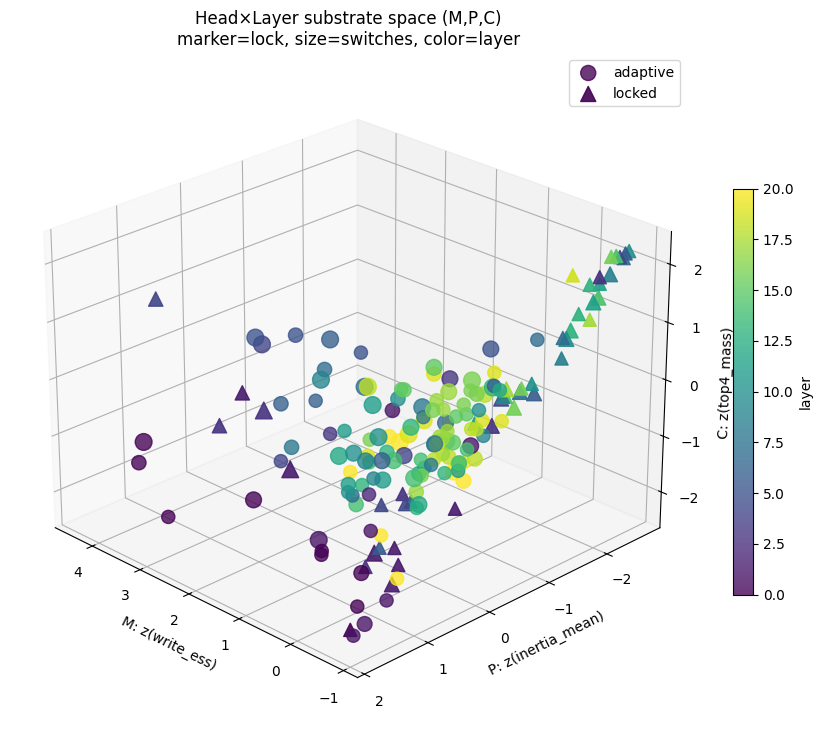

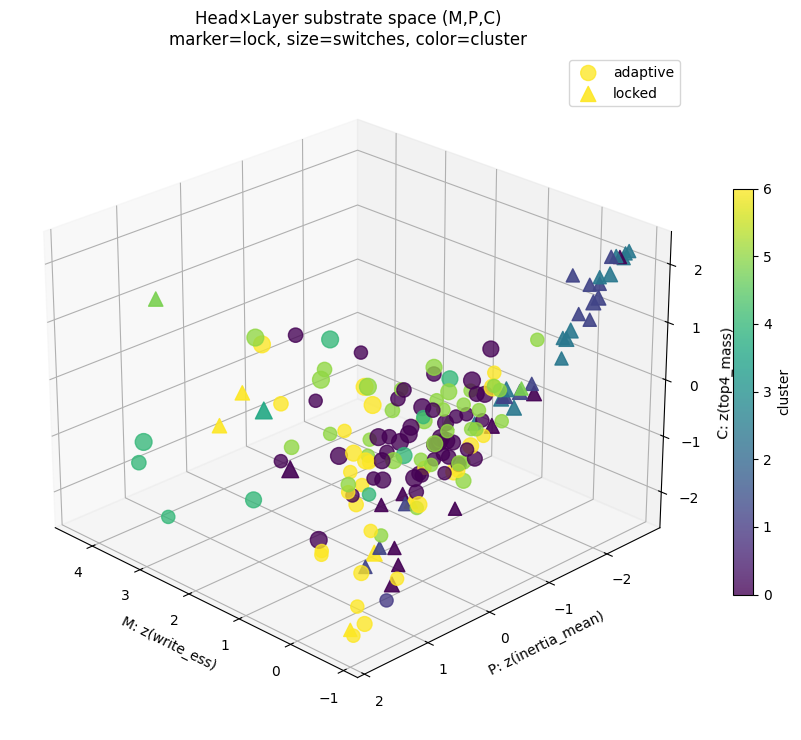

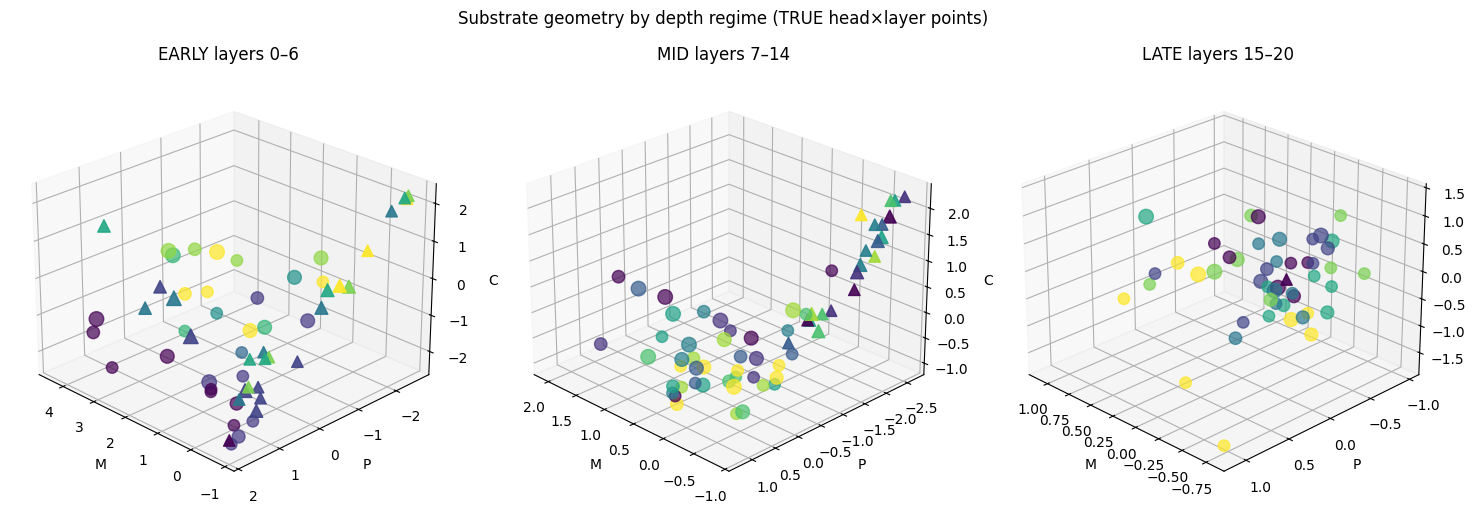

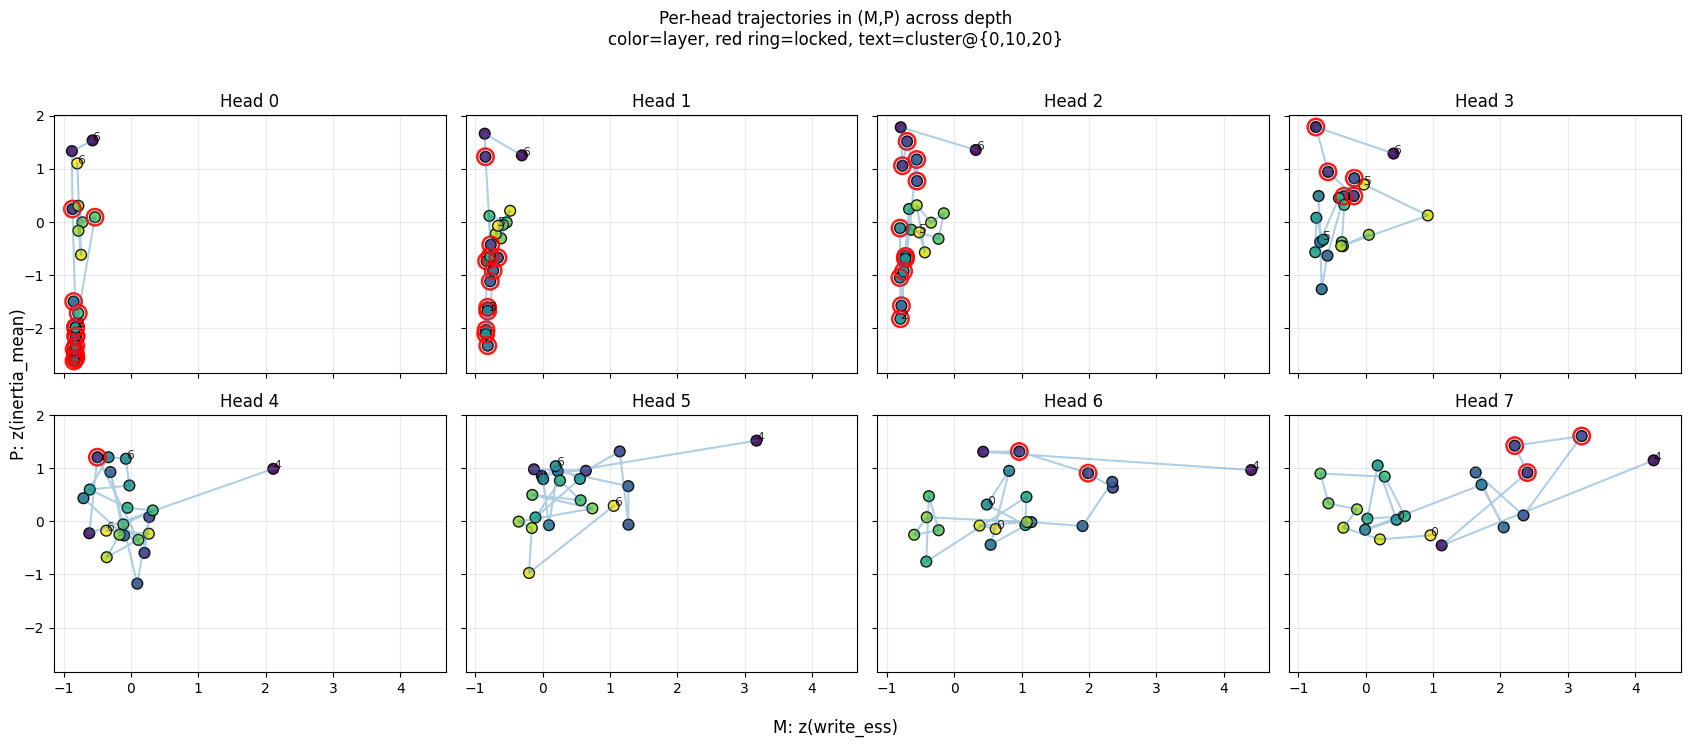

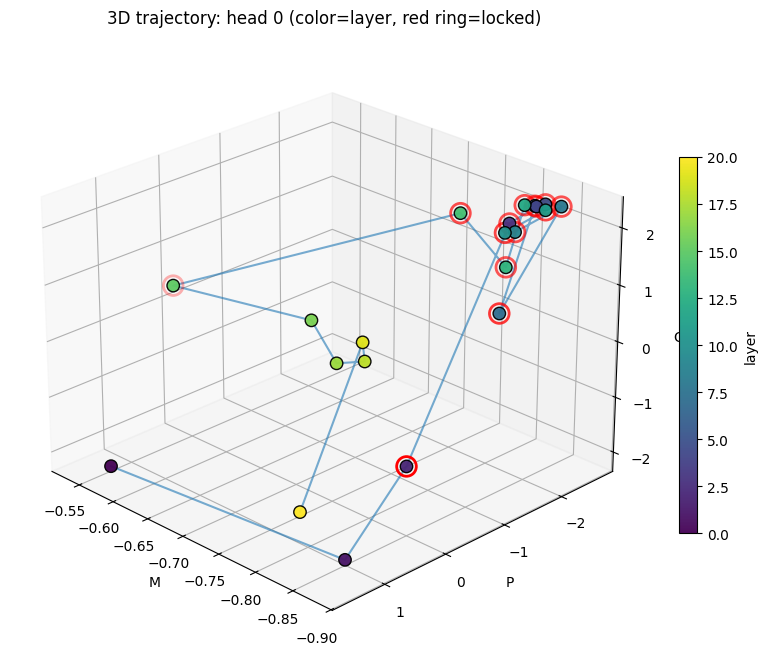

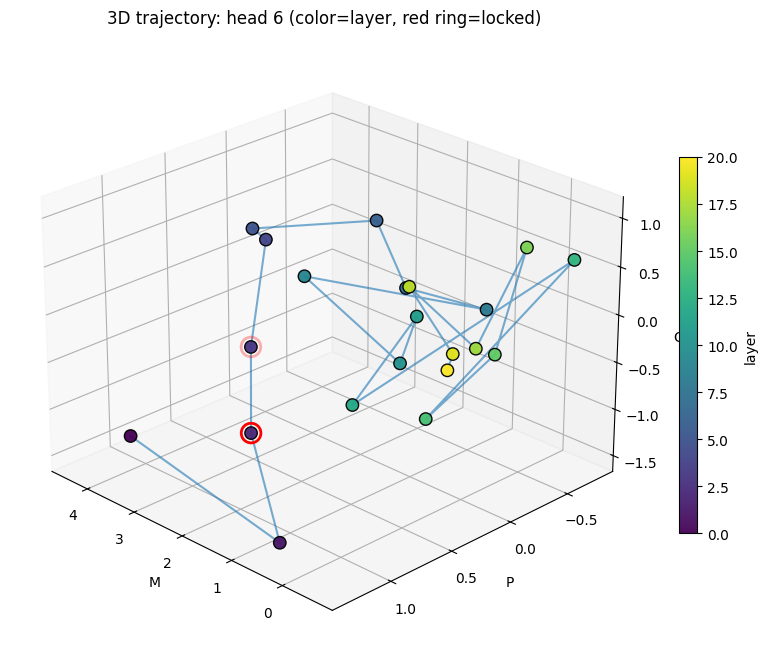

In [117]:

#@title Substrate visualization suite — PER-HEAD story (true head×layer points + trajectories)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# 0) CONFIG
# ============================================================

LOCK_THRESHOLD = 8.0  # inertia_half_lag ≥ this → locked (per-head, per-layer)

DEPTH_BINS = {
    "early": list(range(0, 7)),    # L0–L6
    "mid":   list(range(7, 15)),   # L7–L14
    "late":  list(range(15, 21)),  # L15–L20
}

def z(x):
    x = np.asarray(x, dtype=np.float64)
    return (x - x.mean()) / (x.std() + 1e-8)

# ============================================================
# 1) BUILD PER-HEAD×LAYER TABLE from feat_by_layer
# ============================================================

if ("feat_by_layer" not in globals()) or ("feature_names" not in globals()):
    raise RuntimeError("Need feat_by_layer + feature_names (your head feature bank) to build per-head×layer points.")

# Feature columns we need to define M/P/C/L
need = {
    "mean_write_ess": "M",
    "mean_inertia_mean": "P",
    "mean_top4_mass": "C",
    "mean_inertia_half_lag": "L",  # for lock flag
}
for k in need:
    if k not in [f"mean_{nm}" for nm in feature_names] and k not in feature_names:
        # Your feature_names already look like ['inertia_lag1','inertia_mean',...,'write_ess'] (without mean_ prefix)
        pass

# Map your feature bank names -> indices
# (Your feature_names list is like: inertia_lag1, inertia_mean, inertia_slope, inertia_half_lag, tok_ent, eff_slots, top4_mass, write_tail_half_life, write_ess)
name_to_j = {nm: j for j, nm in enumerate(feature_names)}

req = ["write_ess", "inertia_mean", "top4_mass", "inertia_half_lag"]
missing = [r for r in req if r not in name_to_j]
if missing:
    raise RuntimeError(f"Missing required features in feature_names: {missing}\nfeature_names={feature_names}")

rows = []
for layer, X in enumerate(feat_by_layer):
    if X is None:
        continue
    X = np.asarray(X)  # shape [H, D]
    H = X.shape[0]
    for h in range(H):
        rows.append({
            "layer": int(layer),
            "head": int(h),
            "write_ess": float(X[h, name_to_j["write_ess"]]),
            "inertia_mean": float(X[h, name_to_j["inertia_mean"]]),
            "top4_mass": float(X[h, name_to_j["top4_mass"]]),
            "inertia_half_lag": float(X[h, name_to_j["inertia_half_lag"]]),
        })

df_hp = pd.DataFrame(rows)
if len(df_hp) == 0:
    raise RuntimeError("Built empty df_hp; feat_by_layer had no usable entries.")

# Global z-scoring over ALL head×layer points (so geometry is comparable across depth)
df_hp["M"] = z(df_hp["write_ess"])
df_hp["P"] = z(df_hp["inertia_mean"])
df_hp["C"] = z(df_hp["top4_mass"])
df_hp["locked"] = (df_hp["inertia_half_lag"] >= LOCK_THRESHOLD).astype(np.int32)

# Join in per-head aggregate switches (optional sizing)
if "df_slot" in globals():
    if "slot" in df_slot.columns:
        # You were calling heads "slot" in df_slot
        df_switch = df_slot[["slot", "switches"]].rename(columns={"slot": "head"})
        df_hp = df_hp.merge(df_switch, on="head", how="left")
    elif "head" in df_slot.columns:
        df_switch = df_slot[["head", "switches"]]
        df_hp = df_hp.merge(df_switch, on="head", how="left")

df_hp["switches"] = df_hp["switches"].fillna(0.0)
df_hp["size"] = df_hp["switches"].astype(np.float32)

# Join in cluster id per layer per head (optional role label)
if ("results" in globals()) and ("aligned" in results) and ("cluster_by_layer" in results["aligned"]):
    cluster_by_layer = results["aligned"]["cluster_by_layer"]  # dict layer -> list/array len H
    cid = []
    for _, r in df_hp.iterrows():
        l = int(r["layer"]); h = int(r["head"])
        if l in cluster_by_layer:
            cid.append(int(cluster_by_layer[l][h]))
        else:
            cid.append(-1)
    df_hp["cluster"] = cid
else:
    df_hp["cluster"] = -1

print("df_hp (per-head×layer) sample:")
display(df_hp.head(10))

# ============================================================
# 2) 3D SCATTER (true head×layer points)
#    Color: layer (depth) OR cluster; Size: switches; Marker: lock
# ============================================================

def plot_3d_points(df, title, color_by="layer"):
    fig = plt.figure(figsize=(9.5, 7.5))
    ax = fig.add_subplot(111, projection="3d")

    cval = df[color_by].to_numpy()
    s = 18 + 8.0 * df["size"].to_numpy()

    # two scatters so locked vs adaptive are visually separable
    d0 = df[df["locked"] == 0]
    d1 = df[df["locked"] == 1]

    sc0 = ax.scatter(d0["M"], d0["P"], d0["C"], c=d0[color_by], cmap="viridis",
                     s=(18 + 8.0*d0["size"]), alpha=0.78, marker="o", label="adaptive")
    sc1 = ax.scatter(d1["M"], d1["P"], d1["C"], c=d1[color_by], cmap="viridis",
                     s=(18 + 8.0*d1["size"]), alpha=0.90, marker="^", label="locked")

    ax.set_xlabel("M: z(write_ess)")
    ax.set_ylabel("P: z(inertia_mean)")
    ax.set_zlabel("C: z(top4_mass)")
    ax.set_title(title)
    ax.legend(loc="best", frameon=True)

    cbar = fig.colorbar(sc0, ax=ax, shrink=0.6)
    cbar.set_label(color_by)

    ax.view_init(elev=25, azim=135)
    plt.tight_layout()
    plt.show()

plot_3d_points(df_hp, "Head×Layer substrate space (M,P,C)\nmarker=lock, size=switches, color=layer", color_by="layer")

# Optional: color by cluster instead (role space)
if (df_hp["cluster"] >= 0).any():
    plot_3d_points(df_hp, "Head×Layer substrate space (M,P,C)\nmarker=lock, size=switches, color=cluster", color_by="cluster")

# ============================================================
# 3) TRUE DEPTH SLICES (early/mid/late)
# ============================================================

fig = plt.figure(figsize=(15, 5))
for i, (name, layer_list) in enumerate(DEPTH_BINS.items(), start=1):
    sub = df_hp[df_hp["layer"].isin(layer_list)]
    ax = fig.add_subplot(1, 3, i, projection="3d")

    d0 = sub[sub["locked"] == 0]
    d1 = sub[sub["locked"] == 1]

    ax.scatter(d0["M"], d0["P"], d0["C"], c=d0["layer"], cmap="viridis",
               s=(14 + 6.0*d0["size"]), alpha=0.70, marker="o")
    ax.scatter(d1["M"], d1["P"], d1["C"], c=d1["layer"], cmap="viridis",
               s=(14 + 6.0*d1["size"]), alpha=0.90, marker="^")

    ax.set_title(f"{name.upper()} layers {layer_list[0]}–{layer_list[-1]}")
    ax.set_xlabel("M"); ax.set_ylabel("P"); ax.set_zlabel("C")
    ax.view_init(elev=25, azim=135)

plt.suptitle("Substrate geometry by depth regime (TRUE head×layer points)", y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# 4) PER-HEAD TRAJECTORIES across depth (M vs P)
#    - one panel per head; color by layer
#    - optionally annotate cluster id and lock state
# ============================================================

H = int(df_hp["head"].max() + 1)
ncols = 4
nrows = int(np.ceil(H / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4.3*ncols, 3.6*nrows), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)

for h in range(H):
    ax = axes[h]
    dh = df_hp[df_hp["head"] == h].sort_values("layer")
    ax.scatter(dh["M"], dh["P"], c=dh["layer"], cmap="viridis", s=60, edgecolor="k", alpha=0.9)
    ax.plot(dh["M"], dh["P"], "-", alpha=0.35)
    # mark locked points
    dhl = dh[dh["locked"] == 1]
    if len(dhl) > 0:
        ax.scatter(dhl["M"], dhl["P"], facecolors="none", edgecolors="red", s=140, linewidths=1.8, alpha=0.9)

    # annotate cluster transitions if available (light)
    if (dh["cluster"] >= 0).any():
        for _, r in dh.iterrows():
            if int(r["layer"]) in (0, 10, 20):  # keep sparse so it's readable
                ax.text(r["M"], r["P"], str(int(r["cluster"])), fontsize=9, alpha=0.8)

    ax.set_title(f"Head {h}")
    ax.grid(True, alpha=0.25)

for k in range(H, len(axes)):
    axes[k].axis("off")

fig.suptitle("Per-head trajectories in (M,P) across depth\ncolor=layer, red ring=locked, text=cluster@{0,10,20}", y=1.02)
fig.supxlabel("M: z(write_ess)")
fig.supylabel("P: z(inertia_mean)")
plt.tight_layout()
plt.show()

# ============================================================
# 5) PER-HEAD 3D TRAJECTORIES (optional: one head at a time)
# ============================================================

def plot_head_3d_trajectory(head_id: int):
    dh = df_hp[df_hp["head"] == head_id].sort_values("layer")
    fig = plt.figure(figsize=(8.5, 6.8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(dh["M"], dh["P"], dh["C"], "-", alpha=0.6)
    sc = ax.scatter(dh["M"], dh["P"], dh["C"], c=dh["layer"], cmap="viridis", s=80, edgecolor="k", alpha=0.95)
    # lock marker overlay
    dhl = dh[dh["locked"] == 1]
    if len(dhl) > 0:
        ax.scatter(dhl["M"], dhl["P"], dhl["C"], facecolors="none", edgecolors="red", s=200, linewidths=2.0)

    ax.set_xlabel("M"); ax.set_ylabel("P"); ax.set_zlabel("C")
    ax.set_title(f"3D trajectory: head {head_id} (color=layer, red ring=locked)")
    fig.colorbar(sc, ax=ax, shrink=0.6).set_label("layer")
    ax.view_init(elev=25, azim=135)
    plt.tight_layout()
    plt.show()

# Example: plot a couple of heads (edit these indices)
for hid in [0, 6]:
    plot_head_3d_trajectory(hid)

df_hl head×layer table: (168, 12)


layer  head   write_ess  inertia_mean  top4_mass  inertia_half_lag  \
0      0     0   32.015125      0.939521   0.339881               2.0   
1      0     1   56.329578      0.886330   0.388293               2.0   
2      0     2  114.419609      0.905614   0.413743               2.0   
3      0     3  122.885826      0.892659   0.392406               2.0   
4      0     4  280.014374      0.836838   0.408900               2.0   

   switches         M         P         C  locked       size  
0       9.0 -0.569573  1.533573 -2.044772       0  30.000000  
1      12.0 -0.306648  1.251601 -1.727157       0  37.714286  
2       9.0  0.321509  1.353830 -1.560185       0  30.000000  
3       9.0  0.413059  1.285148 -1.700174       0  30.000000  
4      14.0  2.112170  0.989234 -1.591960       0  42.857143


Environment table: (21, 7) | delta used: True


layer  slotspace_gate  content_read_gamma  slotspace_delta_norm  \
0      0        0.061273            0.037825             15.112902   
1      1        0.048781            0.070871             37.538544   
2      2        0.051638            0.103201             38.041954   
3      3        0.057509            0.098956             33.611786   
4      4        0.061468            0.117580             34.078236   

   E_slot_raw    E_slot   E_gamma  
0    0.926016 -1.830738 -1.428946  
1    1.831171 -0.424334 -1.087961  
2    1.964408 -0.217314 -0.754365  
3    1.932993 -0.266125 -0.798169  
4    2.094705 -0.014861 -0.606002

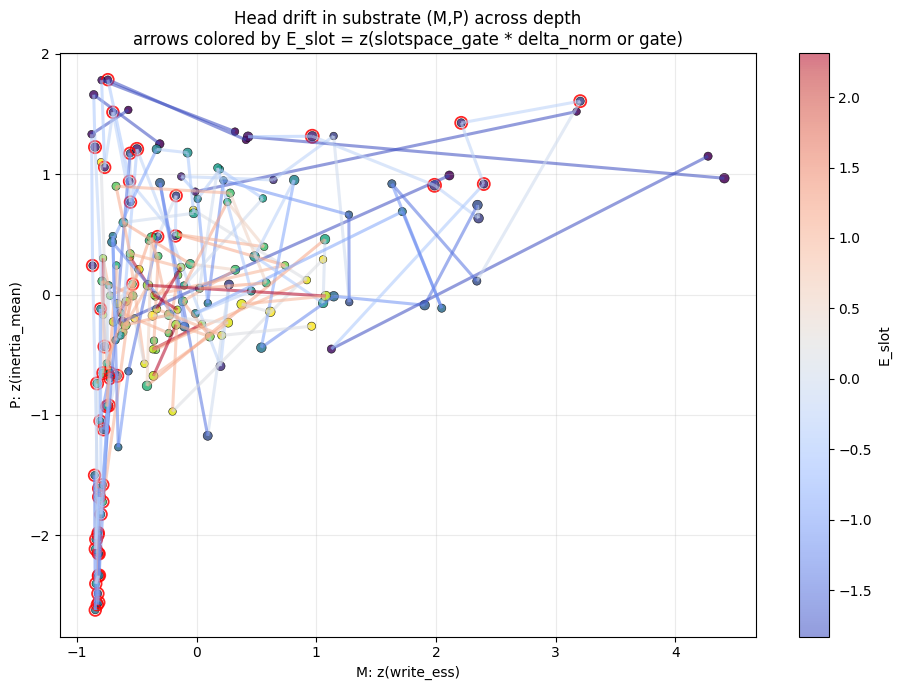

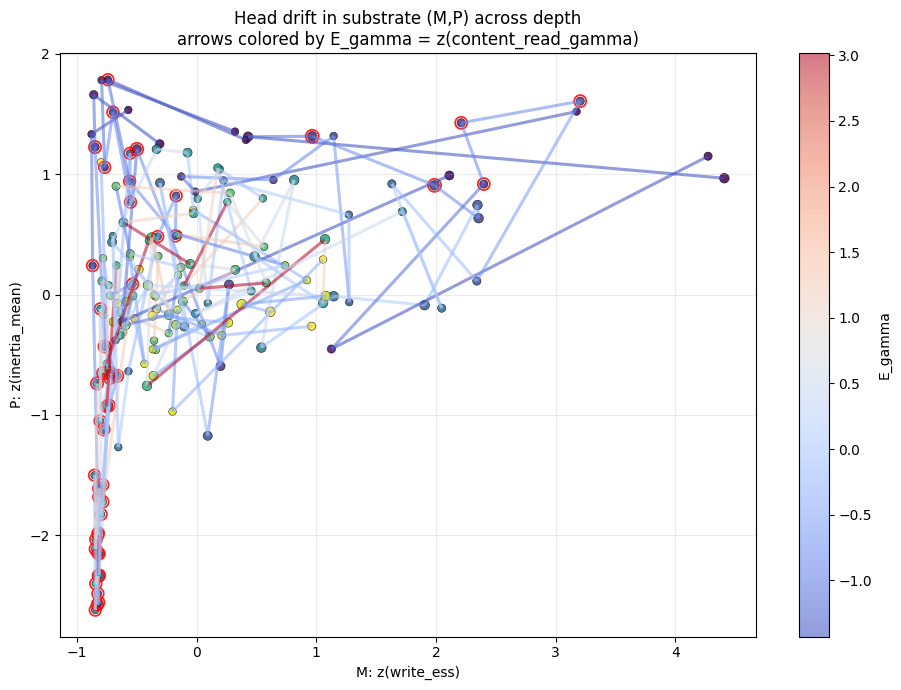


Diagnostics (layer-conditioned):
corr(drift_norm, E_slot) = -0.2628066324782787
corr(drift_norm, E_gamma) = -0.14686611875355698


layer  drift_mean    E_slot   E_gamma      gate     gamma
0       0    2.304696 -1.830738 -1.428946  0.061273  0.037825
1       1    1.268070 -0.424334 -1.087961  0.048781  0.070871
2       2    1.627949 -0.217314 -0.754365  0.051638  0.103201
3       3    0.911011 -0.266125 -0.798169  0.057509  0.098956
4       4    0.931083 -0.014861 -0.606002  0.061468  0.117580
5       5    1.402261 -1.449524 -0.128954  0.066144  0.163813
6       6    1.294287 -1.148918  0.155012  0.065367  0.191333
7       7    1.222858 -1.232147 -0.052685  0.064881  0.171205
8       8    1.082312 -0.916109  0.458166  0.061735  0.220713
9       9    0.746274 -0.289725  0.552985  0.079000  0.229903
10     10    0.918794 -0.435396  0.044136  0.063496  0.180588
11     11    0.895246 -0.013491  1.125456  0.074082  0.285384
12     12    1.200398  1.157808  3.017017  0.065395  0.468704
13     13    0.885871  0.548654  0.729325  0.078059  0.246993
14     14    1.373308  1.033467  1.228037  0.074935  0.295325
15     15    0.965676  1.101264 -0.928635  0.098685  0.086312
16     16    0.948457  0.999542  0.082719  0.062645  0.184327
17     17    0.642356  2.312797  0.502403  0.071811  0.225001
18     18    0.975387  0.992041 -0.499476  0.086964  0.127904
19     19    1.305070  0.185888 -0.274137  0.072756  0.149743

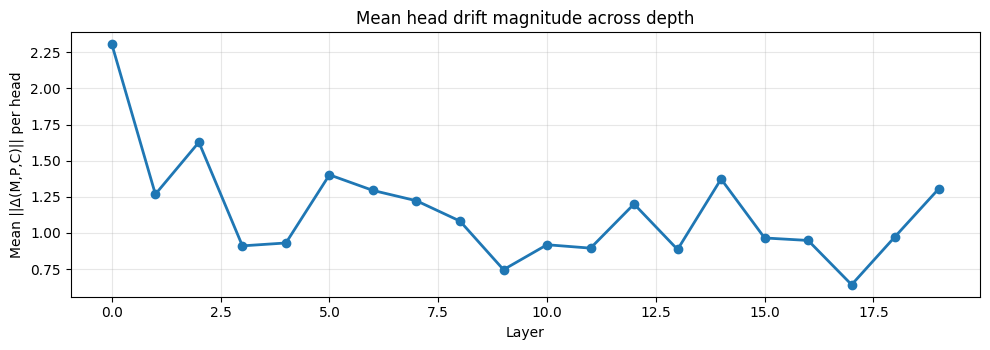

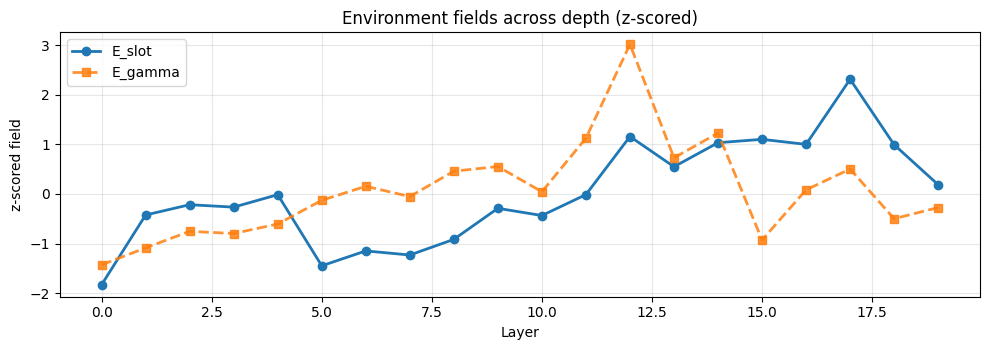

In [118]:

#@title Substrate field + drift cell (FINAL, field intensity + head drift)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# 0) CONFIG
# ============================================================

LOCK_THRESHOLD = 8.0  # inertia_half_lag >= this -> locked

LAYER_RANGE = None  # e.g. (0, 20) or None for all
ARROW_STRIDE = 1    # plot every k layers per head (2D drift)
HEAD_SUBSAMPLE = None  # e.g. [0,3,6] or None for all heads

ARROW_SCALE_2D = 1.0  # multiplies dM,dP
ARROW_ALPHA = 0.55
POINT_ALPHA = 0.85

# 3D arrows can get cluttered; keep sparse by default:
DO_3D_QUIVER = False
QUIVER_STRIDE_LAYER = 3
QUIVER_STRIDE_HEAD = 1
QUIVER_SCALE_3D = 0.8

# ============================================================
# 1) helpers
# ============================================================

def z(x):
    x = np.asarray(x, dtype=np.float64)
    return (x - x.mean()) / (x.std() + 1e-8)

def _require(name):
    if name not in globals():
        raise RuntimeError(f"Missing required variable: {name}")

# ============================================================
# 2) BUILD head×layer substrate table (true per-head, per-layer)
#    Uses feat_by_layer + feature_names, and df_slot for per-head switches.
# ============================================================

_require("feat_by_layer")
_require("feature_names")
_require("df_so")

# switches per head (slot) from df_slot if present
switch_map = None
if "df_slot" in globals() and df_slot is not None and "slot" in df_slot.columns and "switches" in df_slot.columns:
    switch_map = df_slot.set_index("slot")["switches"].to_dict()

# Determine layers that exist in feat_by_layer
layers = [i for i, X in enumerate(feat_by_layer) if X is not None]
if len(layers) == 0:
    raise RuntimeError("feat_by_layer has no valid layers (all None).")

if LAYER_RANGE is not None:
    lo, hi = LAYER_RANGE
    layers = [l for l in layers if lo <= l <= hi]

# Identify required per-head features
need = ["write_ess", "inertia_mean", "top4_mass", "inertia_half_lag"]
missing = [nm for nm in need if nm not in feature_names]
if missing:
    raise RuntimeError(f"feature_names missing required fields: {missing}\nHave: {feature_names}")

idx = {nm: feature_names.index(nm) for nm in feature_names}

rows = []
for l in layers:
    X = np.asarray(feat_by_layer[l])  # [H, F]
    H = X.shape[0]
    for h in range(H):
        rec = {
            "layer": int(l),
            "head": int(h),
            "write_ess": float(X[h, idx["write_ess"]]),
            "inertia_mean": float(X[h, idx["inertia_mean"]]),
            "top4_mass": float(X[h, idx["top4_mass"]]),
            "inertia_half_lag": float(X[h, idx["inertia_half_lag"]]),
        }
        if switch_map is not None:
            rec["switches"] = float(switch_map.get(h, np.nan))
        else:
            rec["switches"] = np.nan
        rows.append(rec)

df_hl = pd.DataFrame(rows)

# optional head subsample
if HEAD_SUBSAMPLE is not None:
    df_hl = df_hl[df_hl["head"].isin(list(HEAD_SUBSAMPLE))].copy()

# substrate coordinates (z across all head×layer points)
df_hl["M"] = z(df_hl["write_ess"])
df_hl["P"] = z(df_hl["inertia_mean"])
df_hl["C"] = z(df_hl["top4_mass"])

df_hl["locked"] = (df_hl["inertia_half_lag"] >= LOCK_THRESHOLD).astype(int)

# size proxy
if df_hl["switches"].notna().any():
    df_hl["size"] = 30 + 18 * (df_hl["switches"] - df_hl["switches"].min()) / (df_hl["switches"].max() - df_hl["switches"].min() + 1e-8)
else:
    df_hl["size"] = 60.0

print("df_hl head×layer table:", df_hl.shape)
display(df_hl.head())

# ============================================================
# 3) BUILD environment field table per layer
#    E_slot = z(slotspace_gate * slotspace_delta_norm) if delta exists else z(slotspace_gate)
#    E_gamma = z(content_read_gamma)
# ============================================================

df_env = df_so[["layer", "slotspace_gate", "content_read_gamma"]].copy()

# slotspace_delta_norm can appear as:
# - delta_df["slotspace_delta_norm"] from your Second-Order cell
# - df_merge["slotspace_delta_norm"] from merged analysis
delta_col = None
if "df_merge" in globals() and df_merge is not None and "slotspace_delta_norm" in df_merge.columns:
    df_env = df_env.merge(df_merge[["layer", "slotspace_delta_norm"]], on="layer", how="left")
    delta_col = "slotspace_delta_norm"
elif "delta_df" in globals() and delta_df is not None and "slotspace_delta_norm" in delta_df.columns:
    df_env = df_env.merge(delta_df[["layer", "slotspace_delta_norm"]], on="layer", how="left")
    delta_col = "slotspace_delta_norm"

if delta_col is not None and df_env[delta_col].notna().any():
    df_env["E_slot_raw"] = df_env["slotspace_gate"] * df_env[delta_col]
else:
    df_env["E_slot_raw"] = df_env["slotspace_gate"]

df_env["E_slot"] = z(df_env["E_slot_raw"].fillna(df_env["E_slot_raw"].mean()))
df_env["E_gamma"] = z(df_env["content_read_gamma"].fillna(df_env["content_read_gamma"].mean()))

# attach environment to head×layer table
df_hl = df_hl.merge(df_env[["layer", "E_slot", "E_gamma", "slotspace_gate", "content_read_gamma"]], on="layer", how="left")

print("\nEnvironment table:", df_env.shape, "| delta used:", (delta_col is not None))
display(df_env.head())

# ============================================================
# 4) COMPUTE drift per head across depth (Δ to next layer)
# ============================================================

df_hl = df_hl.sort_values(["head", "layer"]).reset_index(drop=True)

# compute forward differences within each head trajectory
df_hl["M_next"] = df_hl.groupby("head")["M"].shift(-1)
df_hl["P_next"] = df_hl.groupby("head")["P"].shift(-1)
df_hl["C_next"] = df_hl.groupby("head")["C"].shift(-1)
df_hl["layer_next"] = df_hl.groupby("head")["layer"].shift(-1)

# only keep diffs when next layer is exactly +1 (contiguous depth)
contig = (df_hl["layer_next"] == (df_hl["layer"] + 1))
df_hl["dM"] = np.where(contig, df_hl["M_next"] - df_hl["M"], np.nan)
df_hl["dP"] = np.where(contig, df_hl["P_next"] - df_hl["P"], np.nan)
df_hl["dC"] = np.where(contig, df_hl["C_next"] - df_hl["C"], np.nan)
df_hl["drift_norm"] = np.sqrt(df_hl["dM"]**2 + df_hl["dP"]**2 + df_hl["dC"]**2)

# ============================================================
# 5) PLOT A: 2D drift in (M,P), colored by E_slot (field intensity)
# ============================================================

def plot_drift_2d(df, field_col, title):
    d = df.copy()
    # stride by layer within each head
    if ARROW_STRIDE > 1:
        d = d[d["layer"] % ARROW_STRIDE == 0].copy()
    d = d.dropna(subset=["dM", "dP", field_col])

    # segments for LineCollection (each: (x,y)->(x+dx,y+dy))
    x0 = d["M"].to_numpy()
    y0 = d["P"].to_numpy()
    x1 = x0 + ARROW_SCALE_2D * d["dM"].to_numpy()
    y1 = y0 + ARROW_SCALE_2D * d["dP"].to_numpy()
    segs = np.stack([np.stack([x0, y0], axis=1), np.stack([x1, y1], axis=1)], axis=1)

    fig, ax = plt.subplots(figsize=(9.5, 7.0))

    # background points
    ax.scatter(
        df["M"], df["P"],
        c=df["layer"], cmap="viridis",
        s=df["size"], alpha=POINT_ALPHA,
        edgecolor="k", linewidths=0.4
    )

    # locked ring overlay
    locked = df[df["locked"] == 1]
    if len(locked) > 0:
        ax.scatter(
            locked["M"], locked["P"],
            s=locked["size"] + 40,
            facecolors="none", edgecolors="red",
            linewidths=1.3, alpha=0.85
        )

    lc = LineCollection(segs, array=d[field_col].to_numpy(), cmap="coolwarm", linewidths=2.2, alpha=ARROW_ALPHA)
    ax.add_collection(lc)
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label(field_col)

    ax.set_xlabel("M: z(write_ess)")
    ax.set_ylabel("P: z(inertia_mean)")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_drift_2d(
    df_hl,
    field_col="E_slot",
    title="Head drift in substrate (M,P) across depth\narrows colored by E_slot = z(slotspace_gate * delta_norm or gate)"
)

# ============================================================
# 6) PLOT B: same 2D drift, colored by E_gamma
# ============================================================

plot_drift_2d(
    df_hl,
    field_col="E_gamma",
    title="Head drift in substrate (M,P) across depth\narrows colored by E_gamma = z(content_read_gamma)"
)

# ============================================================
# 7) Optional: 3D scatter + sparse 3D quiver colored by E_slot
# ============================================================

if DO_3D_QUIVER:
    d3 = df_hl.dropna(subset=["dM", "dP", "dC", "E_slot"]).copy()
    # sparse selection
    d3 = d3[(d3["layer"] % QUIVER_STRIDE_LAYER == 0) & (d3["head"] % QUIVER_STRIDE_HEAD == 0)].copy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # points
    sc = ax.scatter(
        df_hl["M"], df_hl["P"], df_hl["C"],
        c=df_hl["layer"], cmap="viridis",
        s=df_hl["size"], alpha=0.85
    )

    # locked marker overlay (triangles)
    locked = df_hl[df_hl["locked"] == 1]
    ax.scatter(
        locked["M"], locked["P"], locked["C"],
        marker="^", s=locked["size"] + 30,
        c=locked["layer"], cmap="viridis",
        alpha=0.9, edgecolor="k", linewidths=0.3
    )

    # quiver colored by E_slot: draw in bins (matplotlib 3D quiver doesn't support per-arrow colormap well)
    # We'll approximate by 5 quantile bins.
    bins = np.quantile(d3["E_slot"], [0, .2, .4, .6, .8, 1.0])
    for b0, b1 in zip(bins[:-1], bins[1:]):
        sub = d3[(d3["E_slot"] >= b0) & (d3["E_slot"] <= b1)]
        if len(sub) == 0:
            continue
        ax.quiver(
            sub["M"], sub["P"], sub["C"],
            QUIVER_SCALE_3D * sub["dM"], QUIVER_SCALE_3D * sub["dP"], QUIVER_SCALE_3D * sub["dC"],
            length=1.0, normalize=False, alpha=0.35
        )

    ax.set_xlabel("M")
    ax.set_ylabel("P")
    ax.set_zlabel("C")
    ax.set_title("3D head×layer substrate with sparse drift quivers\n(points colored by layer; quivers ~ E_slot binned)")
    fig.colorbar(sc, ax=ax, shrink=0.6, label="layer")
    ax.view_init(elev=25, azim=135)
    plt.tight_layout()
    plt.show()

# ============================================================
# 8) Quick diagnostics: does drift increase when field is high?
# ============================================================

dcheck = df_hl.dropna(subset=["drift_norm", "E_slot", "E_gamma"]).copy()
print("\nDiagnostics (layer-conditioned):")
print("corr(drift_norm, E_slot) =", float(np.corrcoef(dcheck["drift_norm"], dcheck["E_slot"])[0,1]))
print("corr(drift_norm, E_gamma) =", float(np.corrcoef(dcheck["drift_norm"], dcheck["E_gamma"])[0,1]))

# optional: per-layer drift mean vs fields
df_layer_drift = dcheck.groupby("layer").agg(
    drift_mean=("drift_norm", "mean"),
    E_slot=("E_slot", "mean"),
    E_gamma=("E_gamma", "mean"),
    gate=("slotspace_gate", "mean"),
    gamma=("content_read_gamma", "mean"),
).reset_index()

display(df_layer_drift)

plt.figure(figsize=(10, 3.6))
plt.plot(df_layer_drift["layer"], df_layer_drift["drift_mean"], "o-", lw=2)
plt.xlabel("Layer")
plt.ylabel("Mean ||Δ(M,P,C)|| per head")
plt.title("Mean head drift magnitude across depth")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3.6))
plt.plot(df_layer_drift["layer"], df_layer_drift["E_slot"], "o-", lw=2, label="E_slot")
plt.plot(df_layer_drift["layer"], df_layer_drift["E_gamma"], "s--", lw=2, label="E_gamma", alpha=0.85)
plt.xlabel("Layer")
plt.ylabel("z-scored field")
plt.title("Environment fields across depth (z-scored)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [119]:

#@title Substrate taxonomy + field regimes (FINAL, name-clash safe + auto-resolve)

import numpy as np
import pandas as pd

# ============================================================
# 0) Resolve inputs without clobbering existing names
# ============================================================

def _pick_first_existing(names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return n, globals()[n]
    return None, None

# Head×layer table
hl_name, df_hl = _pick_first_existing(["df_hl", "df_hp"])
if df_hl is None:
    raise RuntimeError("Need df_hl (or df_hp) head×layer table. Run your Substrate field + drift cell first.")
df_hl_in = df_hl.copy()

# Environment per layer
env_name, dfE = _pick_first_existing(["df_env", "env_df"])
if dfE is None:
    # fall back: build from df_so/df_merge if available
    if "df_so" not in globals() or df_so is None:
        raise RuntimeError("Need df_env OR df_so to build environment table.")
    dfE = df_so[["layer", "slotspace_gate", "content_read_gamma"]].copy()
    # try to add delta
    if "df_merge" in globals() and df_merge is not None and "slotspace_delta_norm" in df_merge.columns:
        dfE = dfE.merge(df_merge[["layer", "slotspace_delta_norm"]], on="layer", how="left")
    elif "delta_df" in globals() and delta_df is not None and "slotspace_delta_norm" in delta_df.columns:
        dfE = dfE.merge(delta_df[["layer", "slotspace_delta_norm"]], on="layer", how="left")

    def _z(x):
        x = np.asarray(x, dtype=np.float64)
        return (x - x.mean()) / (x.std() + 1e-8)

    if "slotspace_delta_norm" in dfE.columns and dfE["slotspace_delta_norm"].notna().any():
        dfE["E_slot_raw"] = dfE["slotspace_gate"] * dfE["slotspace_delta_norm"]
    else:
        dfE["E_slot_raw"] = dfE["slotspace_gate"]
    dfE["E_slot"] = _z(dfE["E_slot_raw"].fillna(dfE["E_slot_raw"].mean()))
    dfE["E_gamma"] = _z(dfE["content_read_gamma"].fillna(dfE["content_read_gamma"].mean()))

df_env_in = dfE.copy()

# Drift per layer
drift_name, dfD = _pick_first_existing(["df_layer_drift", "drift_df"])
if dfD is None:
    # compute from head×layer if drift_norm exists, else fail
    if "drift_norm" not in df_hl_in.columns:
        raise RuntimeError("Need df_layer_drift (or drift_df), or df_hl must contain drift_norm.")
    dfD = (
        df_hl_in.dropna(subset=["drift_norm"])
               .groupby("layer")
               .agg(drift_mean=("drift_norm", "mean"))
               .reset_index()
    )

df_drift_in = dfD.copy()

print("Resolved inputs:")
print("  head×layer:", "df_hl" if hl_name is None else hl_name, df_hl_in.shape)
print("  env(layer):", "df_env" if env_name is None else env_name, df_env_in.shape)
print("  drift(layer):", "df_layer_drift" if drift_name is None else drift_name, df_drift_in.shape)

# ============================================================
# 1) Canonical config + helper bins
# ============================================================

taxonomy_cfg = {
    "LOCK_THRESHOLD": 8.0,
    "AXIS_Q_LO": 0.30,
    "AXIS_Q_HI": 0.70,
    "FIELD_POS": +0.5,
    "FIELD_NEG": -0.5,
    "DRIFT_Q_LO": 0.30,
    "DRIFT_Q_HI": 0.70,
}

LOCK_THRESHOLD = taxonomy_cfg["LOCK_THRESHOLD"]

# Ensure locked exists and is defined the same way everywhere
if "locked" not in df_hl_in.columns:
    if "inertia_half_lag" not in df_hl_in.columns:
        raise RuntimeError("df_hl missing 'locked' and missing 'inertia_half_lag' to compute it.")
    df_hl_in["locked"] = (df_hl_in["inertia_half_lag"] >= LOCK_THRESHOLD).astype(int)

# Axes must exist
for col in ["M", "P", "C"]:
    if col not in df_hl_in.columns:
        raise RuntimeError(f"df_hl missing required substrate axis '{col}' (expected z-scored).")

# ============================================================
# 2) Axis thresholds (global across all head×layer points)
# ============================================================

Q_LO = taxonomy_cfg["AXIS_Q_LO"]
Q_HI = taxonomy_cfg["AXIS_Q_HI"]

axis_thresholds = {}
for ax in ["M", "P", "C"]:
    axis_thresholds[ax] = {
        "lo": float(df_hl_in[ax].quantile(Q_LO)),
        "hi": float(df_hl_in[ax].quantile(Q_HI)),
    }

def bin_axis(x, lo, hi):
    if x <= lo:
        return "LOW"
    elif x >= hi:
        return "HIGH"
    else:
        return "MID"

for ax in ["M", "P", "C"]:
    lo = axis_thresholds[ax]["lo"]
    hi = axis_thresholds[ax]["hi"]
    df_hl_in[f"{ax}_bin"] = df_hl_in[ax].apply(lambda v: bin_axis(v, lo, hi))

# ============================================================
# 3) Field regimes (layer-level)
# ============================================================

FIELD_POS = taxonomy_cfg["FIELD_POS"]
FIELD_NEG = taxonomy_cfg["FIELD_NEG"]

def field_state(x):
    if x >= FIELD_POS:
        return "HIGH"
    elif x <= FIELD_NEG:
        return "LOW"
    else:
        return "MID"

df_layer = df_env_in.copy()

# Standardize column names for env
if "E_slot" not in df_layer.columns or "E_gamma" not in df_layer.columns:
    raise RuntimeError("Environment table must contain E_slot and E_gamma.")

df_layer["slot_state"] = df_layer["E_slot"].apply(field_state)
df_layer["gamma_state"] = df_layer["E_gamma"].apply(field_state)

def field_regime(row):
    ss, gs = row["slot_state"], row["gamma_state"]
    if ss == "LOW" and gs == "LOW":
        return "LOW_FIELD"
    if gs == "HIGH" and ss != "HIGH":
        return "GAMMA_DOM"
    if gs == "HIGH" and ss == "HIGH":
        return "HANDOFF"
    if ss == "HIGH" and gs != "HIGH":
        return "SLOT_DOM"
    return "MIXED_MID"

df_layer["field_regime"] = df_layer.apply(field_regime, axis=1)

# ============================================================
# 4) Drift regimes + phases (layer-level)
# ============================================================

if "drift_mean" not in df_drift_in.columns:
    raise RuntimeError("Drift table must contain drift_mean.")

D_LO = float(df_drift_in["drift_mean"].quantile(taxonomy_cfg["DRIFT_Q_LO"]))
D_HI = float(df_drift_in["drift_mean"].quantile(taxonomy_cfg["DRIFT_Q_HI"]))

def drift_regime(x):
    if x >= D_HI:
        return "HIGH"
    elif x <= D_LO:
        return "LOW"
    else:
        return "MID"

df_drift_in = df_drift_in[["layer", "drift_mean"]].copy()
df_drift_in["drift_regime"] = df_drift_in["drift_mean"].apply(drift_regime)

df_layer_regimes = (
    df_layer.merge(df_drift_in, on="layer", how="left")
            .sort_values("layer")
            .reset_index(drop=True)
)

def depth_phase(row):
    fr = row["field_regime"]
    dr = row["drift_regime"]

    # These are the paper-style phases we discussed:
    if fr == "LOW_FIELD" and dr == "HIGH":
        return "PHASE_FORMATION"
    if fr == "GAMMA_DOM" and dr != "LOW":
        return "PHASE_REMODELING"
    if fr == "HANDOFF":
        return "PHASE_HANDOFF"
    if fr == "SLOT_DOM" and dr == "LOW":
        return "PHASE_CONSOLIDATION"
    if fr == "SLOT_DOM":
        return "PHASE_TERMINAL_TUNING"
    return "PHASE_MIXED"

df_layer_regimes["phase"] = df_layer_regimes.apply(depth_phase, axis=1)

# ============================================================
# 5) Substrate classes (head×layer) as region + field regime
# ============================================================

df_taxonomy = df_hl_in.merge(
    df_layer_regimes[["layer", "field_regime", "phase"]],
    on="layer",
    how="left"
)

def substrate_class(row):
    M, P, C = row["M_bin"], row["P_bin"], row["C_bin"]
    locked = int(row["locked"])
    fr = row["field_regime"]

    # Priority order: most specific archetypes first.
    if locked and M == "HIGH" and P == "HIGH":
        return "FROZEN_HIGH_CAPACITY_ANCHOR"

    if locked and P == "HIGH" and C == "HIGH":
        return "POLICY_ANCHOR"

    if locked and C == "HIGH" and M == "LOW":
        return "BRITTLE_LOCKER"

    if fr == "HANDOFF":
        return "TRANSITIONER"

    if (not locked) and M == "HIGH":
        return "HIGH_CAPACITY_INTEGRATOR"

    if (not locked) and C == "HIGH" and P != "HIGH":
        return "SEMANTIC_SPECIALIST"

    if (not locked) and P == "LOW" and C == "LOW":
        return "EXPLORATORY_ROUTER"

    return "OTHER"

df_taxonomy["substrate_class"] = df_taxonomy.apply(substrate_class, axis=1)

# ============================================================
# 6) Outputs + compact summaries
# ============================================================

print("\n=== taxonomy_cfg ===")
print(taxonomy_cfg)
print("\n=== axis_thresholds (global quantiles) ===")
print(axis_thresholds)
print("\n=== drift thresholds ===")
print({"D_LO": D_LO, "D_HI": D_HI})

print("\n=== Layer-level regimes (df_layer_regimes) ===")
display(df_layer_regimes[["layer", "E_slot", "E_gamma", "field_regime", "drift_mean", "drift_regime", "phase"]])

print("\n=== Substrate class counts (head×layer points) ===")
display(df_taxonomy["substrate_class"].value_counts().to_frame("count"))

print("\n=== Substrate classes by phase ===")
display(pd.crosstab(df_taxonomy["phase"], df_taxonomy["substrate_class"]))

print("\n=== Locked vs adaptive by class ===")
display(pd.crosstab(df_taxonomy["substrate_class"], df_taxonomy["locked"]))

# Keep these names stable going forward:
# df_layer_regimes: layer -> field_regime, drift_regime, phase
# df_taxonomy: head×layer points -> M/P/C bins + regime + class

Resolved inputs:
  head×layer: df_hl (168, 24)
  env(layer): df_env (21, 7)
  drift(layer): df_layer_drift (20, 6)

=== taxonomy_cfg ===
{'LOCK_THRESHOLD': 8.0, 'AXIS_Q_LO': 0.3, 'AXIS_Q_HI': 0.7, 'FIELD_POS': 0.5, 'FIELD_NEG': -0.5, 'DRIFT_Q_LO': 0.3, 'DRIFT_Q_HI': 0.7}

=== axis_thresholds (global quantiles) ===
{'M': {'lo': -0.6683492615697139, 'hi': 0.170267768258631}, 'P': {'lo': -0.2655665177502008, 'hi': 0.5886749137031242}, 'C': {'lo': -0.5091522457198588, 'hi': 0.47453570016133073}}

=== drift thresholds ===
{'D_LO': 0.9273961336285985, 'D_HI': 1.275935214118136}

=== Layer-level regimes (df_layer_regimes) ===


layer    E_slot   E_gamma field_regime  drift_mean drift_regime  \
0       0 -1.830738 -1.428946    LOW_FIELD    2.304696         HIGH   
1       1 -0.424334 -1.087961    MIXED_MID    1.268070          MID   
2       2 -0.217314 -0.754365    MIXED_MID    1.627949         HIGH   
3       3 -0.266125 -0.798169    MIXED_MID    0.911011          LOW   
4       4 -0.014861 -0.606002    MIXED_MID    0.931083          MID   
5       5 -1.449524 -0.128954    MIXED_MID    1.402261         HIGH   
6       6 -1.148918  0.155012    MIXED_MID    1.294287         HIGH   
7       7 -1.232147 -0.052685    MIXED_MID    1.222858          MID   
8       8 -0.916109  0.458166    MIXED_MID    1.082312          MID   
9       9 -0.289725  0.552985    GAMMA_DOM    0.746274          LOW   
10     10 -0.435396  0.044136    MIXED_MID    0.918794          LOW   
11     11 -0.013491  1.125456    GAMMA_DOM    0.895246          LOW   
12     12  1.157808  3.017017      HANDOFF    1.200398          MID   
13     13  0.548654  0.729325      HANDOFF    0.885871          LOW   
14     14  1.033467  1.228037      HANDOFF    1.373308         HIGH   
15     15  1.101264 -0.928635     SLOT_DOM    0.965676          MID   
16     16  0.999542  0.082719     SLOT_DOM    0.948457          MID   
17     17  2.312797  0.502403      HANDOFF    0.642356          LOW   
18     18  0.992041 -0.499476     SLOT_DOM    0.975387          MID   
19     19  0.185888 -0.274137    MIXED_MID    1.305070         HIGH   
20     20 -0.092780 -1.335928    MIXED_MID         NaN          NaN   

                    phase  
0         PHASE_FORMATION  
1             PHASE_MIXED  
2             PHASE_MIXED  
3             PHASE_MIXED  
4             PHASE_MIXED  
5             PHASE_MIXED  
6             PHASE_MIXED  
7             PHASE_MIXED  
8             PHASE_MIXED  
9             PHASE_MIXED  
10            PHASE_MIXED  
11            PHASE_MIXED  
12          PHASE_HANDOFF  
13          PHASE_HANDOFF  
14          PHASE_HANDOFF  
15  PHASE_TERMINAL_TUNING  
16  PHASE_TERMINAL_TUNING  
17          PHASE_HANDOFF  
18  PHASE_TERMINAL_TUNING  
19            PHASE_MIXED  
20            PHASE_MIXED


=== Substrate class counts (head×layer points) ===


count
substrate_class                   
OTHER                           60
HIGH_CAPACITY_INTEGRATOR        40
TRANSITIONER                    27
BRITTLE_LOCKER                  25
SEMANTIC_SPECIALIST             11
FROZEN_HIGH_CAPACITY_ANCHOR      5


=== Substrate classes by phase ===


substrate_class        BRITTLE_LOCKER  FROZEN_HIGH_CAPACITY_ANCHOR  \
phase                                                                
PHASE_FORMATION                     0                            0   
PHASE_HANDOFF                       5                            0   
PHASE_MIXED                        20                            5   
PHASE_TERMINAL_TUNING               0                            0   

substrate_class        HIGH_CAPACITY_INTEGRATOR  OTHER  SEMANTIC_SPECIALIST  \
phase                                                                         
PHASE_FORMATION                               6      2                    0   
PHASE_HANDOFF                                 0      0                    0   
PHASE_MIXED                                  32     43                    4   
PHASE_TERMINAL_TUNING                         2     15                    7   

substrate_class        TRANSITIONER  
phase                                
PHASE_FORMATION                   0  
PHASE_HANDOFF                    27  
PHASE_MIXED                       0  
PHASE_TERMINAL_TUNING             0


=== Locked vs adaptive by class ===


locked                        0   1
substrate_class                    
BRITTLE_LOCKER                0  25
FROZEN_HIGH_CAPACITY_ANCHOR   0   5
HIGH_CAPACITY_INTEGRATOR     40   0
OTHER                        43  17
SEMANTIC_SPECIALIST          11   0
TRANSITIONER                 26   1

In [120]:

#@title Canonicalize env + drift → df_layer (fix E_slot/E_gamma name clashes)

import numpy as np
import pandas as pd

def z(x):
    x = np.asarray(x, dtype=np.float64)
    return (x - x.mean()) / (x.std() + 1e-8)

def _require_var(name):
    if name not in globals():
        raise RuntimeError(f"Missing required variable: {name}")

# ------------------------------------------------------------
# 1) Ensure df_hl exists (head×layer). If not, you must run the field+drift cell.
# ------------------------------------------------------------
_require_var("df_hl")
df_hl = df_hl.copy()
if "layer" not in df_hl.columns:
    raise RuntimeError("df_hl must include a 'layer' column.")

# ------------------------------------------------------------
# 2) Build/resolve df_env (layer fields) with E_slot/E_gamma
# ------------------------------------------------------------
df_env_local = None
if "df_env" in globals() and df_env is not None and len(df_env) > 0:
    df_env_local = df_env.copy()
else:
    # reconstruct from df_so (+ delta if available) like your field+drift cell
    _require_var("df_so")
    df_env_local = df_so[["layer", "slotspace_gate", "content_read_gamma"]].copy()

    if "df_merge" in globals() and df_merge is not None and "slotspace_delta_norm" in df_merge.columns:
        df_env_local = df_env_local.merge(df_merge[["layer", "slotspace_delta_norm"]], on="layer", how="left")
    elif "delta_df" in globals() and delta_df is not None and "slotspace_delta_norm" in delta_df.columns:
        df_env_local = df_env_local.merge(delta_df[["layer", "slotspace_delta_norm"]], on="layer", how="left")

    if "slotspace_delta_norm" in df_env_local.columns and df_env_local["slotspace_delta_norm"].notna().any():
        df_env_local["E_slot_raw"] = df_env_local["slotspace_gate"] * df_env_local["slotspace_delta_norm"]
    else:
        df_env_local["E_slot_raw"] = df_env_local["slotspace_gate"]

    df_env_local["E_slot"] = z(df_env_local["E_slot_raw"].fillna(df_env_local["E_slot_raw"].mean()))
    df_env_local["E_gamma"] = z(df_env_local["content_read_gamma"].fillna(df_env_local["content_read_gamma"].mean()))

# Coerce/canonicalize naming even if df_env was overwritten elsewhere
if "E_slot" not in df_env_local.columns:
    if "E_slot_raw" in df_env_local.columns:
        df_env_local["E_slot"] = z(df_env_local["E_slot_raw"].fillna(df_env_local["E_slot_raw"].mean()))
    elif "slotspace_gate" in df_env_local.columns:
        df_env_local["E_slot"] = z(df_env_local["slotspace_gate"].fillna(df_env_local["slotspace_gate"].mean()))
    else:
        raise RuntimeError(f"df_env has no E_slot/E_slot_raw/slotspace_gate columns: {list(df_env_local.columns)}")

if "E_gamma" not in df_env_local.columns:
    if "content_read_gamma" in df_env_local.columns:
        df_env_local["E_gamma"] = z(df_env_local["content_read_gamma"].fillna(df_env_local["content_read_gamma"].mean()))
    else:
        raise RuntimeError(f"df_env has no E_gamma/content_read_gamma columns: {list(df_env_local.columns)}")

# Keep canonical columns (+ gate/gamma if present)
keep_cols = ["layer", "E_slot", "E_gamma"]
for extra in ["slotspace_gate", "content_read_gamma", "slotspace_delta_norm", "E_slot_raw"]:
    if extra in df_env_local.columns:
        keep_cols.append(extra)
df_env = df_env_local[keep_cols].copy()

# ------------------------------------------------------------
# 3) Build/resolve df_layer_drift (layer drift)
# ------------------------------------------------------------
df_layer_drift_local = None
if "df_layer_drift" in globals() and df_layer_drift is not None and len(df_layer_drift) > 0:
    # accept if it has drift_mean already; otherwise rebuild
    if "drift_mean" in df_layer_drift.columns:
        df_layer_drift_local = df_layer_drift.copy()
    else:
        df_layer_drift_local = None

if df_layer_drift_local is None:
    # compute from df_hl (requires drift_norm)
    if "drift_norm" not in df_hl.columns:
        raise RuntimeError("df_hl is missing drift_norm; run the field+drift cell (step 4) first.")
    dcheck = df_hl.dropna(subset=["drift_norm"]).copy()
    df_layer_drift_local = dcheck.groupby("layer", as_index=False).agg(
        drift_mean=("drift_norm", "mean")
    )

df_layer_drift = df_layer_drift_local[["layer", "drift_mean"]].copy()

# ------------------------------------------------------------
# 4) Canonical df_layer for phase classification
# ------------------------------------------------------------
df_layer = (
    df_env.merge(df_layer_drift, on="layer", how="left")
          .sort_values("layer")
          .reset_index(drop=True)
)

print("Resolved inputs:")
print("  head×layer: df_hl", df_hl.shape)
print("  env(layer): df_env", df_env.shape, "cols=", list(df_env.columns))
print("  drift(layer): df_layer_drift", df_layer_drift.shape, "cols=", list(df_layer_drift.columns))
print("  canonical df_layer:", df_layer.shape, "cols=", list(df_layer.columns))

display(df_layer.head())

Resolved inputs:
  head×layer: df_hl (168, 24)
  env(layer): df_env (21, 7) cols= ['layer', 'E_slot', 'E_gamma', 'slotspace_gate', 'content_read_gamma', 'slotspace_delta_norm', 'E_slot_raw']
  drift(layer): df_layer_drift (20, 2) cols= ['layer', 'drift_mean']
  canonical df_layer: (21, 8) cols= ['layer', 'E_slot', 'E_gamma', 'slotspace_gate', 'content_read_gamma', 'slotspace_delta_norm', 'E_slot_raw', 'drift_mean']


layer    E_slot   E_gamma  slotspace_gate  content_read_gamma  \
0      0 -1.830738 -1.428946        0.061273            0.037825   
1      1 -0.424334 -1.087961        0.048781            0.070871   
2      2 -0.217314 -0.754365        0.051638            0.103201   
3      3 -0.266125 -0.798169        0.057509            0.098956   
4      4 -0.014861 -0.606002        0.061468            0.117580   

   slotspace_delta_norm  E_slot_raw  drift_mean  
0             15.112902    0.926016    2.304696  
1             37.538544    1.831171    1.268070  
2             38.041954    1.964408    1.627949  
3             33.611786    1.932993    0.911011  
4             34.078236    2.094705    0.931083

Resolved inputs:  head×layer: df_hl (168, 15)   env(layer): (21, 3)   drift(layer): (20, 2)


layer    E_slot   E_gamma  drift_mean
0      0 -1.830738 -1.428946    2.304696
1      1 -0.424334 -1.087961    1.268070
2      2 -0.217314 -0.754365    1.627949
3      3 -0.266125 -0.798169    0.911011
4      4 -0.014861 -0.606002    0.931083


=== taxonomy sweep (top 12) ===


FIELD_POS  AXIS_Q_LO  AXIS_Q_HI  DRIFT_Q_LO  DRIFT_Q_HI      D_LO  \
0        0.25       0.25       0.75        0.25        0.75  0.911011   
1        0.25       0.25       0.75        0.30        0.70  0.918794   
2        0.35       0.25       0.75        0.25        0.75  0.911011   
3        0.35       0.25       0.75        0.30        0.70  0.918794   
4        0.50       0.25       0.75        0.25        0.75  0.911011   
5        0.50       0.25       0.75        0.30        0.70  0.918794   
6        0.25       0.30       0.70        0.25        0.75  0.911011   
7        0.25       0.30       0.70        0.30        0.70  0.918794   
8        0.35       0.30       0.70        0.25        0.75  0.911011   
9        0.35       0.30       0.70        0.30        0.70  0.918794   
10       0.50       0.30       0.70        0.25        0.75  0.911011   
11       0.50       0.30       0.70        0.30        0.70  0.918794   

        D_HI  OTHER_pct  PHASE_FORMATION  PHASE_REMODELING  PHASE_HANDOFF  \
0   1.294287  16.071429                1                 1              4   
1   1.268070  16.071429                2                 1              4   
2   1.294287  16.071429                1                 1              4   
3   1.268070  16.071429                2                 1              4   
4   1.294287  16.071429                1                 0              4   
5   1.268070  16.071429                1                 0              4   
6   1.294287  22.023810                1                 1              4   
7   1.268070  22.023810                2                 1              4   
8   1.294287  22.023810                1                 1              4   
9   1.268070  22.023810                2                 1              4   
10  1.294287  22.023810                1                 0              4   
11  1.268070  22.023810                1                 0              4   

    PHASE_CONSOLIDATION  PHASE_TERMINAL_TUNING  PHASE_MIXED      score  
0                     0                      3           12  16.071429  
1                     0                      3           11  16.071429  
2                     0                      3           12  16.071429  
3                     0                      3           11  16.071429  
4                     0                      3           13  16.071429  
5                     0                      3           13  16.071429  
6                     0                      3           12  22.023810  
7                     0                      3           11  22.023810  
8                     0                      3           12  22.023810  
9                     0                      3           11  22.023810  
10                    0                      3           13  22.023810  
11                    0                      3           13  22.023810


=== recommended taxonomy_cfg ===


LOCK_THRESHOLD  AXIS_Q_LO  AXIS_Q_HI  FIELD_POS  FIELD_NEG  DRIFT_Q_LO  \
0             8.0       0.25       0.75       0.25      -0.25        0.25   

   DRIFT_Q_HI  
0        0.75


=== BEFORE (taxonomy_cfg) ===
Substrate class counts:


count
substrate_class                   
OTHER                           37
HIGH_CAPACITY_INTEGRATOR        36
BRITTLE_LOCKER                  27
BALANCED_GENERALIST             18
LOCKED_MISC                     17
ROUTING_SPECIALIST              15
SEMANTIC_SPECIALIST             14
FROZEN_HIGH_CAPACITY_ANCHOR      4

Substrate classes by phase (counts):


substrate_class        BALANCED_GENERALIST  BRITTLE_LOCKER  \
phase                                                        
PHASE_FORMATION                          0               0   
PHASE_HANDOFF                            8               5   
PHASE_MIXED                              5              22   
PHASE_TERMINAL_TUNING                    5               0   

substrate_class        FROZEN_HIGH_CAPACITY_ANCHOR  HIGH_CAPACITY_INTEGRATOR  \
phase                                                                          
PHASE_FORMATION                                  0                         6   
PHASE_HANDOFF                                    0                         6   
PHASE_MIXED                                      4                        22   
PHASE_TERMINAL_TUNING                            0                         2   

substrate_class        LOCKED_MISC  OTHER  ROUTING_SPECIALIST  \
phase                                                           
PHASE_FORMATION                  0      0                   2   
PHASE_HANDOFF                    1      9                   1   
PHASE_MIXED                     15     18                  12   
PHASE_TERMINAL_TUNING            1     10                   0   

substrate_class        SEMANTIC_SPECIALIST  
phase                                       
PHASE_FORMATION                          0  
PHASE_HANDOFF                            2  
PHASE_MIXED                              6  
PHASE_TERMINAL_TUNING                    6

Locked vs adaptive by class:


locked                        0   1
substrate_class                    
BALANCED_GENERALIST          18   0
BRITTLE_LOCKER                0  27
FROZEN_HIGH_CAPACITY_ANCHOR   0   4
HIGH_CAPACITY_INTEGRATOR     36   0
LOCKED_MISC                   0  17
OTHER                        37   0
ROUTING_SPECIALIST           15   0
SEMANTIC_SPECIALIST          14   0

Layer regimes:


layer    E_slot   E_gamma field_regime  drift_mean drift_regime  \
0       0 -1.830738 -1.428946    LOW_FIELD    2.304696         HIGH   
1       1 -0.424334 -1.087961    MIXED_MID    1.268070         HIGH   
2       2 -0.217314 -0.754365    MIXED_MID    1.627949         HIGH   
3       3 -0.266125 -0.798169    MIXED_MID    0.911011          LOW   
4       4 -0.014861 -0.606002    MIXED_MID    0.931083          MID   
5       5 -1.449524 -0.128954    MIXED_MID    1.402261         HIGH   
6       6 -1.148918  0.155012    MIXED_MID    1.294287         HIGH   
7       7 -1.232147 -0.052685    MIXED_MID    1.222858          MID   
8       8 -0.916109  0.458166    MIXED_MID    1.082312          MID   
9       9 -0.289725  0.552985    GAMMA_DOM    0.746274          LOW   
10     10 -0.435396  0.044136    MIXED_MID    0.918794          LOW   
11     11 -0.013491  1.125456    GAMMA_DOM    0.895246          LOW   
12     12  1.157808  3.017017      HANDOFF    1.200398          MID   
13     13  0.548654  0.729325      HANDOFF    0.885871          LOW   
14     14  1.033467  1.228037      HANDOFF    1.373308         HIGH   
15     15  1.101264 -0.928635     SLOT_DOM    0.965676          MID   
16     16  0.999542  0.082719     SLOT_DOM    0.948457          MID   
17     17  2.312797  0.502403      HANDOFF    0.642356          LOW   
18     18  0.992041 -0.499476     SLOT_DOM    0.975387          MID   
19     19  0.185888 -0.274137    MIXED_MID    1.305070         HIGH   
20     20 -0.092780 -1.335928    MIXED_MID    0.000000          LOW   

                    phase  
0         PHASE_FORMATION  
1             PHASE_MIXED  
2             PHASE_MIXED  
3             PHASE_MIXED  
4             PHASE_MIXED  
5             PHASE_MIXED  
6             PHASE_MIXED  
7             PHASE_MIXED  
8             PHASE_MIXED  
9             PHASE_MIXED  
10            PHASE_MIXED  
11            PHASE_MIXED  
12          PHASE_HANDOFF  
13          PHASE_HANDOFF  
14          PHASE_HANDOFF  
15  PHASE_TERMINAL_TUNING  
16  PHASE_TERMINAL_TUNING  
17          PHASE_HANDOFF  
18  PHASE_TERMINAL_TUNING  
19            PHASE_MIXED  
20            PHASE_MIXED


=== AFTER (recommended cfg) ===
Substrate class counts:


count
substrate_class                   
BALANCED_GENERALIST             33
HIGH_CAPACITY_INTEGRATOR        29
OTHER                           27
LOCKED_MISC                     22
BRITTLE_LOCKER                  22
ROUTING_SPECIALIST              16
SEMANTIC_SPECIALIST             15
FROZEN_HIGH_CAPACITY_ANCHOR      4

Substrate classes by phase (counts):


substrate_class        BALANCED_GENERALIST  BRITTLE_LOCKER  \
phase                                                        
PHASE_FORMATION                          0               0   
PHASE_HANDOFF                           11               4   
PHASE_MIXED                             10              15   
PHASE_REMODELING                         3               3   
PHASE_TERMINAL_TUNING                    9               0   

substrate_class        FROZEN_HIGH_CAPACITY_ANCHOR  HIGH_CAPACITY_INTEGRATOR  \
phase                                                                          
PHASE_FORMATION                                  0                         6   
PHASE_HANDOFF                                    0                         4   
PHASE_MIXED                                      4                        16   
PHASE_REMODELING                                 0                         1   
PHASE_TERMINAL_TUNING                            0                         2   

substrate_class        LOCKED_MISC  OTHER  ROUTING_SPECIALIST  \
phase                                                           
PHASE_FORMATION                  0      0                   2   
PHASE_HANDOFF                    2      9                   1   
PHASE_MIXED                     19     12                  13   
PHASE_REMODELING                 0      1                   0   
PHASE_TERMINAL_TUNING            1      5                   0   

substrate_class        SEMANTIC_SPECIALIST  
phase                                       
PHASE_FORMATION                          0  
PHASE_HANDOFF                            1  
PHASE_MIXED                              7  
PHASE_REMODELING                         0  
PHASE_TERMINAL_TUNING                    7

Locked vs adaptive by class:


locked                        0   1
substrate_class                    
BALANCED_GENERALIST          33   0
BRITTLE_LOCKER                0  22
FROZEN_HIGH_CAPACITY_ANCHOR   0   4
HIGH_CAPACITY_INTEGRATOR     29   0
LOCKED_MISC                   0  22
OTHER                        27   0
ROUTING_SPECIALIST           16   0
SEMANTIC_SPECIALIST          15   0

Layer regimes:


layer    E_slot   E_gamma field_regime  drift_mean drift_regime  \
0       0 -1.830738 -1.428946    LOW_FIELD    2.304696         HIGH   
1       1 -0.424334 -1.087961    LOW_FIELD    1.268070          MID   
2       2 -0.217314 -0.754365    MIXED_MID    1.627949         HIGH   
3       3 -0.266125 -0.798169    LOW_FIELD    0.911011          LOW   
4       4 -0.014861 -0.606002    MIXED_MID    0.931083          MID   
5       5 -1.449524 -0.128954    MIXED_MID    1.402261         HIGH   
6       6 -1.148918  0.155012    MIXED_MID    1.294287         HIGH   
7       7 -1.232147 -0.052685    MIXED_MID    1.222858          MID   
8       8 -0.916109  0.458166    GAMMA_DOM    1.082312          MID   
9       9 -0.289725  0.552985    GAMMA_DOM    0.746274          LOW   
10     10 -0.435396  0.044136    MIXED_MID    0.918794          MID   
11     11 -0.013491  1.125456    GAMMA_DOM    0.895246          LOW   
12     12  1.157808  3.017017      HANDOFF    1.200398          MID   
13     13  0.548654  0.729325      HANDOFF    0.885871          LOW   
14     14  1.033467  1.228037      HANDOFF    1.373308         HIGH   
15     15  1.101264 -0.928635     SLOT_DOM    0.965676          MID   
16     16  0.999542  0.082719     SLOT_DOM    0.948457          MID   
17     17  2.312797  0.502403      HANDOFF    0.642356          LOW   
18     18  0.992041 -0.499476     SLOT_DOM    0.975387          MID   
19     19  0.185888 -0.274137    MIXED_MID    1.305070         HIGH   
20     20 -0.092780 -1.335928    MIXED_MID    0.000000          LOW   

                    phase  
0         PHASE_FORMATION  
1             PHASE_MIXED  
2             PHASE_MIXED  
3             PHASE_MIXED  
4             PHASE_MIXED  
5             PHASE_MIXED  
6             PHASE_MIXED  
7             PHASE_MIXED  
8        PHASE_REMODELING  
9             PHASE_MIXED  
10            PHASE_MIXED  
11            PHASE_MIXED  
12          PHASE_HANDOFF  
13          PHASE_HANDOFF  
14          PHASE_HANDOFF  
15  PHASE_TERMINAL_TUNING  
16  PHASE_TERMINAL_TUNING  
17          PHASE_HANDOFF  
18  PHASE_TERMINAL_TUNING  
19            PHASE_MIXED  
20            PHASE_MIXED

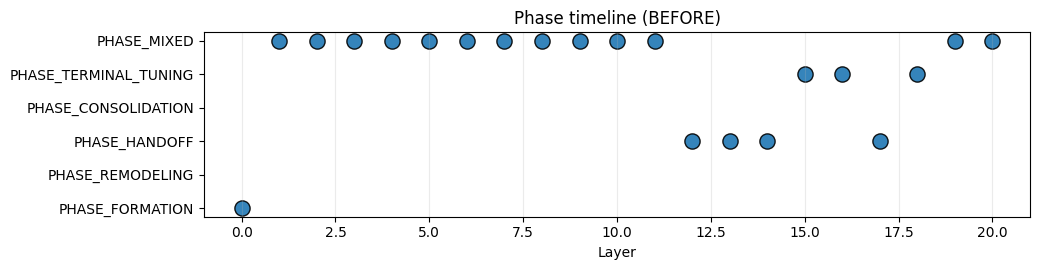

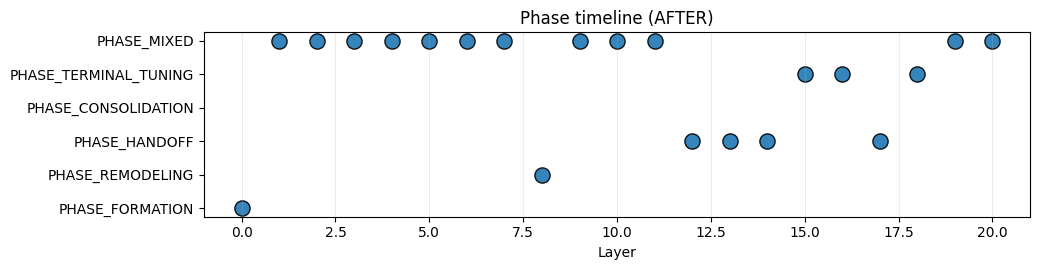


Exports:
  df_tax: head×layer points + bins + substrate_class + phase
  df_layer_regimes: layer table with field_regime/drift_regime/phase
  axis_thresholds, drift_thresholds


In [125]:

#@title Taxonomy sweep (FIXED env resolution) — rebuild canonical df_layer with E_slot/E_gamma

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display  # <-- FIX: display may not be defined outside notebook

# ----------------------------
# CONFIG
# ----------------------------
taxonomy_cfg = dict(
    LOCK_THRESHOLD=8.0,
    AXIS_Q_LO=0.30,
    AXIS_Q_HI=0.70,
    FIELD_POS=0.50,
    FIELD_NEG=-0.50,
    DRIFT_Q_LO=0.30,
    DRIFT_Q_HI=0.70,
)

DO_SWEEP = True
FIELD_T_LIST = [0.25, 0.35, 0.50]
AXIS_Q_LIST  = [(0.25,0.75), (0.30,0.70)]
DRIFT_Q_LIST = [(0.25,0.75), (0.30,0.70)]

# ----------------------------
# Helpers
# ----------------------------
def _require(df, cols, name):
    if df is None or not isinstance(df, pd.DataFrame) or len(df) == 0:
        raise RuntimeError(f"{name} is missing or empty.")
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise RuntimeError(f"{name} missing columns: {missing}\nHave: {list(df.columns)}")

def z(x):
    x = np.asarray(x, dtype=np.float64)
    return (x - x.mean()) / (x.std() + 1e-8)

def _bin3(x, lo, hi):
    return np.where(x <= lo, "LO", np.where(x >= hi, "HI", "MID"))

def _field_state(x, t):
    return np.where(x >= t, "HIGH", np.where(x <= -t, "LOW", "MID"))

def _axis_thresholds(df_points, q_lo=0.3, q_hi=0.7):
    out = {}
    for ax in ["M","P","C"]:
        out[ax] = {
            "lo": float(np.quantile(df_points[ax].to_numpy(), q_lo)),
            "hi": float(np.quantile(df_points[ax].to_numpy(), q_hi)),
        }
    return out

def _drift_thresholds(df_layer, q_lo=0.3, q_hi=0.7):
    v = df_layer["drift_mean"].to_numpy()
    v = v[np.isfinite(v)]
    # FIX: avoid quantile() on empty
    if v.size == 0:
        return 0.0, 0.0
    if np.all(v == v[0]):
        return float(v[0]), float(v[0])
    return float(np.quantile(v, q_lo)), float(np.quantile(v, q_hi))

def _coalesce(df, candidates, new_name):
    for c in candidates:
        if c in df.columns:
            df[new_name] = df[c]
            return True
    return False

def _first_df_from_globals(names):
    """Return first non-empty DataFrame from globals by name."""
    for n in names:
        if n in globals():
            obj = globals()[n]
            if isinstance(obj, pd.DataFrame) and len(obj) > 0:
                return obj.copy()
    return None

# ----------------------------
# 1) Resolve df_hl (head×layer)
# ----------------------------
def build_df_hl_from_feat(feat_by_layer, feature_names, lock_threshold=8.0):
    need = ["write_ess", "inertia_mean", "top4_mass", "inertia_half_lag"]
    missing = [nm for nm in need if nm not in feature_names]
    if missing:
        raise RuntimeError(f"feature_names missing required fields: {missing}\nHave: {feature_names}")

    name_to_j = {nm: j for j, nm in enumerate(feature_names)}

    rows = []
    for layer, X in enumerate(feat_by_layer):
        if X is None:
            continue
        X = np.asarray(X)  # [H, F]
        if X.ndim != 2 or X.shape[1] < len(feature_names):
            raise RuntimeError(f"feat_by_layer[{layer}] has unexpected shape {X.shape}; expected [H, F].")
        H = X.shape[0]
        for h in range(H):
            rows.append({
                "layer": int(layer),
                "head": int(h),
                "write_ess": float(X[h, name_to_j["write_ess"]]),
                "inertia_mean": float(X[h, name_to_j["inertia_mean"]]),
                "top4_mass": float(X[h, name_to_j["top4_mass"]]),
                "inertia_half_lag": float(X[h, name_to_j["inertia_half_lag"]]),
            })
    df = pd.DataFrame(rows)
    if len(df) == 0:
        raise RuntimeError("Rebuilt df_hl is empty; feat_by_layer contained no usable layers.")

    df["M"] = z(df["write_ess"])
    df["P"] = z(df["inertia_mean"])
    df["C"] = z(df["top4_mass"])
    df["locked"] = (df["inertia_half_lag"] >= float(lock_threshold)).astype(int)

    # optional size from df_slot switches if available
    if "df_slot" in globals() and isinstance(globals()["df_slot"], pd.DataFrame) and len(globals()["df_slot"]) > 0:
        _df_slot = globals()["df_slot"]
        if "slot" in _df_slot.columns and "switches" in _df_slot.columns:
            smap = _df_slot.set_index("slot")["switches"].to_dict()
            df["switches"] = df["head"].map(lambda h: float(smap.get(int(h), np.nan)))
        elif "head" in _df_slot.columns and "switches" in _df_slot.columns:
            smap = _df_slot.set_index("head")["switches"].to_dict()
            df["switches"] = df["head"].map(lambda h: float(smap.get(int(h), np.nan)))
        else:
            df["switches"] = np.nan
    else:
        df["switches"] = np.nan

    if df["switches"].notna().any():
        mn = float(df["switches"].min())
        mx = float(df["switches"].max())
        df["size"] = 30 + 18 * (df["switches"] - mn) / (mx - mn + 1e-8)
    else:
        df["size"] = 60.0

    return df

# Prefer existing globals if present AND has required cols
df_hl = _first_df_from_globals(["df_hl", "df_hp", "df_points", "df_head_layer"])

if df_hl is None or not set(["layer","head","M","P","C","locked"]).issubset(df_hl.columns):
    if ("feat_by_layer" in globals()) and ("feature_names" in globals()):
        df_hl = build_df_hl_from_feat(
            feat_by_layer=feat_by_layer,
            feature_names=feature_names,
            lock_threshold=taxonomy_cfg["LOCK_THRESHOLD"],
        )
        print("Rebuilt df_hl from feat_by_layer:", df_hl.shape)
    else:
        raise RuntimeError("Missing head×layer table and cannot rebuild: need feat_by_layer + feature_names.")

_require(df_hl, ["layer","head","M","P","C","locked"], "df_hl")

# ----------------------------
# 2) Resolve df_env (layer fields) and canonicalize to E_slot/E_gamma
# ----------------------------
df_env = _first_df_from_globals(["df_env", "df_environment", "df_fields", "df_layer_env"])

if df_env is None:
    # last resort: compute layer env from df_hl if it already has E_slot/E_gamma
    if set(["E_slot","E_gamma"]).issubset(df_hl.columns):
        df_env = df_hl.groupby("layer", as_index=False).agg(E_slot=("E_slot","mean"), E_gamma=("E_gamma","mean"))
    else:
        raise RuntimeError(
            "Could not find a non-empty df_env-like table in globals "
            "and df_hl does not already include E_slot/E_gamma."
        )

df_env = df_env.copy()
if "layer" not in df_env.columns:
    raise RuntimeError(f"df_env missing 'layer'. Have columns: {list(df_env.columns)}")

# Canonicalize E_slot
if "E_slot" not in df_env.columns:
    if "E_slot_raw" in df_env.columns:
        df_env["E_slot"] = z(df_env["E_slot_raw"].to_numpy())
    elif set(["slotspace_gate","slotspace_delta_norm"]).issubset(df_env.columns):
        df_env["E_slot"] = z((df_env["slotspace_gate"] * df_env["slotspace_delta_norm"]).to_numpy())
    elif "slotspace_gate" in df_env.columns:
        df_env["E_slot"] = z(df_env["slotspace_gate"].to_numpy())
    else:
        raise RuntimeError(f"Can't construct E_slot from df_env columns: {list(df_env.columns)}")

# Canonicalize E_gamma
if "E_gamma" not in df_env.columns:
    if "content_read_gamma" in df_env.columns:
        df_env["E_gamma"] = z(df_env["content_read_gamma"].to_numpy())
    elif "content_read_gamma_mean" in df_env.columns:
        df_env["E_gamma"] = z(df_env["content_read_gamma_mean"].to_numpy())
    else:
        raise RuntimeError(f"Can't construct E_gamma from df_env columns: {list(df_env.columns)}")

df_env = df_env[["layer","E_slot","E_gamma"]].copy()
_require(df_env, ["layer","E_slot","E_gamma"], "df_env (canonical)")

# Attach fields to df_hl (in case missing)
if not set(["E_slot","E_gamma"]).issubset(df_hl.columns):
    df_hl = df_hl.merge(df_env, on="layer", how="left")

_require(df_hl, ["E_slot","E_gamma"], "df_hl (+fields)")

# ----------------------------
# 3) Resolve drift per layer (df_layer_drift) or compute
# ----------------------------
df_layer_drift = _first_df_from_globals(["df_layer_drift", "df_drift_layer", "df_layer_transitions"])

use_existing = (
    isinstance(df_layer_drift, pd.DataFrame)
    and len(df_layer_drift) > 0
    and ("layer" in df_layer_drift.columns)
    and ("drift_mean" in df_layer_drift.columns)
)

if not use_existing:
    # compute drift_mean from df_hl by head contiguous diffs
    dtmp = df_hl.sort_values(["head","layer"]).copy()
    dtmp["M_next"] = dtmp.groupby("head")["M"].shift(-1)
    dtmp["P_next"] = dtmp.groupby("head")["P"].shift(-1)
    dtmp["C_next"] = dtmp.groupby("head")["C"].shift(-1)
    dtmp["layer_next"] = dtmp.groupby("head")["layer"].shift(-1)
    contig = (dtmp["layer_next"] == (dtmp["layer"] + 1))
    dtmp["drift_norm"] = np.where(
        contig,
        np.sqrt((dtmp["M_next"]-dtmp["M"])**2 + (dtmp["P_next"]-dtmp["P"])**2 + (dtmp["C_next"]-dtmp["C"])**2),
        np.nan
    )
    df_layer_drift = (dtmp.dropna(subset=["drift_norm"])
                      .groupby("layer", as_index=False)
                      .agg(drift_mean=("drift_norm","mean")))
else:
    df_layer_drift = df_layer_drift[["layer","drift_mean"]].copy()

# ----------------------------
# 4) Build canonical df_layer
# ----------------------------
df_layer = (df_env.merge(df_layer_drift, on="layer", how="left")
            .sort_values("layer").reset_index(drop=True))
df_layer["drift_mean"] = df_layer["drift_mean"].fillna(0.0)
print("Resolved inputs:  head×layer: df_hl", df_hl.shape, "  env(layer):", df_env.shape, "  drift(layer):", df_layer_drift.shape)
display(df_layer.head())

# ----------------------------
# 5) Phase model + substrate classes
# ----------------------------
def classify_phases(df_layer, t_field=0.5, drift_q_lo=0.3, drift_q_hi=0.7):
    df = df_layer.copy()

    # FIX: thresholds robust to NaN drift_mean
    if "drift_mean" not in df.columns:
        df["drift_mean"] = np.nan
    D_LO, D_HI = _drift_thresholds(df, drift_q_lo, drift_q_hi)

    df["slot_state"]  = _field_state(df["E_slot"].to_numpy(),  t_field)
    df["gamma_state"] = _field_state(df["E_gamma"].to_numpy(), t_field)

    dm = df["drift_mean"].to_numpy()
    df["drift_regime"] = np.where(dm >= D_HI, "HIGH", np.where(dm <= D_LO, "LOW", "MID"))

    def _field_regime(row):
        ss, gs = row["slot_state"], row["gamma_state"]
        if ss == "HIGH" and gs == "HIGH":
            return "HANDOFF"
        if ss == "HIGH" and gs != "HIGH":
            return "SLOT_DOM"
        if gs == "HIGH" and ss != "HIGH":
            return "GAMMA_DOM"
        if ss == "LOW" and gs == "LOW":
            return "LOW_FIELD"
        return "MIXED_MID"

    df["field_regime"] = df.apply(_field_regime, axis=1)

    phase = []
    for _, r in df.iterrows():
        fr = r["field_regime"]
        dr = r["drift_regime"]
        if fr == "LOW_FIELD" and dr == "HIGH":
            phase.append("PHASE_FORMATION")
        elif fr == "HANDOFF":
            phase.append("PHASE_HANDOFF")
        elif fr == "GAMMA_DOM" and dr != "LOW":
            phase.append("PHASE_REMODELING")
        elif fr == "SLOT_DOM" and dr == "LOW":
            phase.append("PHASE_CONSOLIDATION")
        elif fr == "SLOT_DOM" and dr != "LOW":
            phase.append("PHASE_TERMINAL_TUNING")
        else:
            phase.append("PHASE_MIXED")

    df["phase"] = phase
    return df, {"D_LO": float(D_LO), "D_HI": float(D_HI)}

def classify_substrate_points(df_points, axis_thr):
    df = df_points.copy()
    df["M_bin"] = _bin3(df["M"].to_numpy(), axis_thr["M"]["lo"], axis_thr["M"]["hi"])
    df["P_bin"] = _bin3(df["P"].to_numpy(), axis_thr["P"]["lo"], axis_thr["P"]["hi"])
    df["C_bin"] = _bin3(df["C"].to_numpy(), axis_thr["C"]["lo"], axis_thr["C"]["hi"])
    locked = df["locked"].to_numpy().astype(int)

    cls = np.array(["OTHER"] * len(df), dtype=object)

    # Locked archetypes
    cls[(locked==1) & (df["M_bin"]=="HI") & (df["P_bin"]=="HI")] = "FROZEN_HIGH_CAPACITY_ANCHOR"
    cls[(locked==1) & (df["C_bin"]=="HI")]                       = "BRITTLE_LOCKER"
    cls[(locked==1) & (cls=="OTHER")]                            = "LOCKED_MISC"

    # Adaptive archetypes
    cls[(locked==0) & (df["M_bin"]=="HI") & (df["P_bin"]!="LO") & (df["C_bin"]!="HI")] = "HIGH_CAPACITY_INTEGRATOR"
    cls[(locked==0) & (df["C_bin"]=="HI") & (df["P_bin"]!="LO")]                       = "SEMANTIC_SPECIALIST"
    cls[(locked==0) & (df["P_bin"]=="LO") & (df["C_bin"]=="LO")]                       = "EXPLORATORY_ROUTER"
    cls[(locked==0) & (df["M_bin"]=="MID") & (df["P_bin"]=="MID") & (df["C_bin"]=="MID")] = "BALANCED_GENERALIST"
    cls[(locked==0) & (df["P_bin"]=="HI") & (df["M_bin"]!="HI") & (df["C_bin"]!="HI")]    = "ROUTING_SPECIALIST"

    df["substrate_class"] = cls
    return df

def build_outputs(cfg):
    t_field = float(cfg["FIELD_POS"])
    qlo = float(cfg["AXIS_Q_LO"]); qhi = float(cfg["AXIS_Q_HI"])
    dqlo = float(cfg["DRIFT_Q_LO"]); dqhi = float(cfg["DRIFT_Q_HI"])

    axis_thr = _axis_thresholds(df_hl, q_lo=qlo, q_hi=qhi)
    df_pts = classify_substrate_points(df_hl, axis_thr=axis_thr)

    df_layer_reg, dthr = classify_phases(df_layer, t_field=t_field, drift_q_lo=dqlo, drift_q_hi=dqhi)
    phase_map = df_layer_reg.set_index("layer")["phase"].to_dict()
    df_pts["phase"] = df_pts["layer"].map(phase_map)

    return df_pts, df_layer_reg, axis_thr, dthr

# ----------------------------
# 6) Sweep + BEFORE/AFTER
# ----------------------------
def _score_row(r):
    phase_cols = ["PHASE_FORMATION","PHASE_REMODELING","PHASE_HANDOFF","PHASE_CONSOLIDATION","PHASE_TERMINAL_TUNING","PHASE_MIXED"]
    nonzero = sum(int(r[c] > 0) for c in phase_cols)
    penalty = 0.0 if nonzero >= 4 else (4 - nonzero) * 5.0
    return float(r["OTHER_pct"] + penalty)

best_cfg = None

if DO_SWEEP:
    sweep_rows = []
    for t_field in FIELD_T_LIST:
        for (qlo,qhi) in AXIS_Q_LIST:
            axis_thr = _axis_thresholds(df_hl, q_lo=qlo, q_hi=qhi)
            pts = classify_substrate_points(df_hl, axis_thr=axis_thr)
            other_pct = 100.0 * float((pts["substrate_class"] == "OTHER").mean())

            for (dqlo,dqhi) in DRIFT_Q_LIST:
                layer_reg, dthr = classify_phases(df_layer, t_field=t_field, drift_q_lo=dqlo, drift_q_hi=dqhi)
                phase_counts = layer_reg["phase"].value_counts().to_dict()

                sweep_rows.append({
                    "FIELD_POS": t_field,
                    "AXIS_Q_LO": qlo,
                    "AXIS_Q_HI": qhi,
                    "DRIFT_Q_LO": dqlo,
                    "DRIFT_Q_HI": dqhi,
                    "D_LO": dthr["D_LO"],
                    "D_HI": dthr["D_HI"],
                    "OTHER_pct": other_pct,
                    "PHASE_FORMATION": int(phase_counts.get("PHASE_FORMATION", 0)),
                    "PHASE_REMODELING": int(phase_counts.get("PHASE_REMODELING", 0)),
                    "PHASE_HANDOFF": int(phase_counts.get("PHASE_HANDOFF", 0)),
                    "PHASE_CONSOLIDATION": int(phase_counts.get("PHASE_CONSOLIDATION", 0)),
                    "PHASE_TERMINAL_TUNING": int(phase_counts.get("PHASE_TERMINAL_TUNING", 0)),
                    "PHASE_MIXED": int(phase_counts.get("PHASE_MIXED", 0)),
                })

    df_sweep = pd.DataFrame(sweep_rows)
    df_sweep["score"] = df_sweep.apply(_score_row, axis=1)
    df_sweep = df_sweep.sort_values(["score","OTHER_pct"]).reset_index(drop=True)

    print("\n=== taxonomy sweep (top 12) ===")
    display(df_sweep.head(12))

    best = df_sweep.iloc[0].to_dict()
    best_cfg = dict(
        LOCK_THRESHOLD=taxonomy_cfg["LOCK_THRESHOLD"],
        AXIS_Q_LO=float(best["AXIS_Q_LO"]),
        AXIS_Q_HI=float(best["AXIS_Q_HI"]),
        FIELD_POS=float(best["FIELD_POS"]),
        FIELD_NEG=-float(best["FIELD_POS"]),
        DRIFT_Q_LO=float(best["DRIFT_Q_LO"]),
        DRIFT_Q_HI=float(best["DRIFT_Q_HI"]),
    )
    print("\n=== recommended taxonomy_cfg ===")
    display(pd.DataFrame([best_cfg]))

df_pts_before, df_layer_regimes_before, axis_thresholds_before, drift_thresholds_before = build_outputs(taxonomy_cfg)
df_pts_after = df_layer_regimes_after = axis_thresholds_after = drift_thresholds_after = None

if best_cfg is not None:
    df_pts_after, df_layer_regimes_after, axis_thresholds_after, drift_thresholds_after = build_outputs(best_cfg)

def summarize_points(df_pts, df_layer_reg, title):
    print(f"\n=== {title} ===")
    print("Substrate class counts:")
    display(df_pts["substrate_class"].value_counts().to_frame("count"))

    print("Substrate classes by phase (counts):")
    display(pd.crosstab(df_pts["phase"], df_pts["substrate_class"]))

    print("Locked vs adaptive by class:")
    display(pd.crosstab(df_pts["substrate_class"], df_pts["locked"]))

    print("Layer regimes:")
    display(df_layer_reg[["layer","E_slot","E_gamma","field_regime","drift_mean","drift_regime","phase"]])

summarize_points(df_pts_before, df_layer_regimes_before, "BEFORE (taxonomy_cfg)")
if df_pts_after is not None:
    summarize_points(df_pts_after, df_layer_regimes_after, "AFTER (recommended cfg)")

def plot_phase_timeline(df_layer_reg, title):
    phase_order = [
        "PHASE_FORMATION","PHASE_REMODELING","PHASE_HANDOFF",
        "PHASE_CONSOLIDATION","PHASE_TERMINAL_TUNING","PHASE_MIXED"
    ]
    phase_to_y = {p:i for i,p in enumerate(phase_order)}
    y = df_layer_reg["phase"].map(phase_to_y).to_numpy()

    plt.figure(figsize=(10.5, 2.8))
    plt.scatter(df_layer_reg["layer"], y, s=120, edgecolor="k", alpha=0.9)
    plt.yticks(list(phase_to_y.values()), list(phase_to_y.keys()))
    plt.xlabel("Layer")
    plt.title(title)
    plt.grid(True, axis="x", alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_phase_timeline(df_layer_regimes_before, "Phase timeline (BEFORE)")
if df_layer_regimes_after is not None:
    plot_phase_timeline(df_layer_regimes_after, "Phase timeline (AFTER)")

# Exports (canonical)
df_layer_regimes = df_layer_regimes_after if df_layer_regimes_after is not None else df_layer_regimes_before
df_tax = df_pts_after if df_pts_after is not None else df_pts_before
axis_thresholds = axis_thresholds_after if axis_thresholds_after is not None else axis_thresholds_before
drift_thresholds = drift_thresholds_after if drift_thresholds_after is not None else drift_thresholds_before

print("\nExports:")
print("  df_tax: head×layer points + bins + substrate_class + phase")
print("  df_layer_regimes: layer table with field_regime/drift_regime/phase")
print("  axis_thresholds, drift_thresholds")

# Evolving Story


1. Core framing
We model attention heads as participating in a depth-evolving substrate composed of three orthogonal capacities: memory capacity (M), routing smoothness (P), and routing commitment (C), modulated by a layer-wise second-order control field. Across depth, the model undergoes a phase transition in which memory-bearing substrates emerge, specialize, and consolidate, while routing anchors stabilize policy continuity.
Everything below refines this statement.
2. Canonical axes (reduced, final)
These are the only axes we treat as fundamental.
Axis M — Memory Capacity
Definition
How much temporal state a head can maintain across tokens.
Operationalization
Primary: write_ess
Secondary (supporting): write_tail_half_life
Interpretation
High M ⇒ diffuse, long-horizon write distributions
Low M ⇒ short-lived or sharply localized memory
Empirical facts
Strongly increases with depth
Strongest predictor of role switching
Drives cluster lifecycle changes
Status
Primary adaptive axis
Everything else modulates how M is used.
Axis P — Routing Smoothness
Definition
How smoothly a head’s routing policy evolves over time.
Operationalization
inertia_mean
inertia_slope
Interpretation
High P ⇒ routing changes gradually (low curvature in policy space)
Low P ⇒ abrupt routing changes
Empirical facts
Positively correlated with regime switching
Peaks in the same depth window as second-order strength
Distinct from routing lock
Status
Adaptive modulation axis
Controls how heads reconfigure, not whether they do.
Axis C — Routing Commitment
Definition
How decisively a head selects a small subset of slots at each step.
Operationalization
top4_mass (preferred)
tok_ent, eff_slots (redundant)
Interpretation
High C ⇒ sharp, decisive routing
Low C ⇒ exploratory or diffuse routing
Empirical facts
Weak–moderate correlation with switching
Largely orthogonal to M
Modulates expression, not capacity
Status
Behavioral style axis
Shapes local dynamics without defining substrate role.
3. Flags (not axes)
These are categorical regime indicators, not continuous dimensions.
Flag L — Routing Lock
Definition
Whether a head’s routing policy is effectively frozen.
Operationalization
inertia_half_lag ≥ threshold (e.g. ≥ 8)
Interpretation
Locked heads preserve policy identity
Unlocked heads can reconfigure
Empirical facts
Negatively correlated with switching
Distinguishes anchors from adaptive carriers
Saturates (nonlinear, thresholded)
Status
Role flag, not a coordinate
Never treat as a continuous axis.
4. Second-order control field (environment, not a head feature)
These are layer-level control signals that shape the substrate.
Slotspace Gate
Definition
Strength of second-order slot–slot interaction.
Interpretation
High values enable nonlocal coordination across heads
Opens the “substrate formation window”
Empirical facts
Peaks sharply at L14–L16
Coincides with memory expansion and role diversification
Content Read Gamma
Definition
Strength of content-based attention relative to slotspace routing.
Interpretation
Bias toward content-driven reads
Typically peaks earlier than slotspace gate
Slotspace Delta Norm
Definition
Magnitude of second-order correction applied during routing.
Interpretation
Direct measure of non-first-order dynamics
Tracks active substrate reshaping
Status of second-order metrics
Control field / phase driver
These do not define head identity; they define what kinds of identities can exist at a given depth.
5. Taxonomy of head roles (final)
This is now stable and evidence-backed.
1. Adaptive Memory Carriers
Signature
High M
Moderate–high P
Low L (unlocked)
High switching
Function
Carry and reshape long-range state
Absorb depth-dependent responsibilities
Where
Emerge in mid-depth
Persist into late depth in reduced number
2. Routing Anchors
Signature
Low–moderate M
High L (locked)
High C
Low switching
Function
Preserve routing semantics
Stabilize computation across depth
Where
Present throughout
Become dominant late
3. Peripheral / Local Processors
Signature
Low M
Low P
Low–moderate C
Variable switching
Function
Token-local or shallow features
Opportunistic participation
Where
Early and mid layers
Mostly disappear or get absorbed
6. Depth-wise mechanistic narrative (locked)
This is the story across layers, grounded in your plots.
Phase I — Local Processing (L0–L3)
Low M, weak second-order control
Heads largely interchangeable
Routing shallow, memory short
Function
Feature extraction, local patterning
Phase II — Substrate Formation (L8–L15)
Second-order gate and gamma peak
Rapid expansion of M
Head roles diverge sharply
High switching and cluster churn
Function
State construction and abstraction
This is where substrates form.
Phase III — Consolidation (L16–L20)
Memory concentrates into fewer heads
Routing locks engage
Switching declines
Cluster lifecycles stabilize
Function
State refinement and decision stabilization
7. What is orthogonal vs coupled (final word)
Strongly coupled
write_ess ↔ write_tail_half_life
inertia_mean ↔ inertia_slope
Weakly coupled
M ↔ P (only during second-order-active layers)
Orthogonal
M ⟂ C
M ⟂ L
C ⟂ L
Antagonistic
L ↔ switching
inertia_half_lag ↔ adaptivity
8. What you should never conflate again
Routing smoothness ≠ routing lock
Memory capacity ≠ routing decisiveness
Second-order strength ≠ head feature
Anchor alignment ≠ early-layer stability
These distinctions are now empirically justified.
9. Compact glossary (for future reference)
Substrate: A stable, functionally coherent head population defined in (M,P,C) space.
Adaptive: High-M, unlocked heads that change role across depth.
Locked: Heads with saturated routing inertia.
Second-order window: Depth region where slotspace gate is high and substrates can reorganize.
Anchor basis: Slot index system aligned via Hungarian matching to a reference layer.


1) Formal class names

Class A — Adaptive Memory Carriers (AMC)
Mechanism: write-memory capacity + unlocked routing + smooth policy evolution
Role: carry/reshape long-range state; most depth-plastic
Class R — Locked Routing Anchors (LRA)
Mechanism: routing lock + high commitment (sharp routing)
Role: preserve routing semantics across depth; stabilizers
Class P — Diffuse Local Processors (DLP)
Mechanism: low memory + diffuse routing (low commitment)
Role: token-local or “exploratory” routing; auxiliary computation
Optional 4th (if you want to distinguish a real subtype that may appear in your data):
Class M — Committed Memory Specialists (CMS)
Mechanism: high memory + high commitment but unlocked
Role: memory heads that route sharply (often emerges late)
You can start with A/R/P, and only introduce CMS if it’s clearly present as a separable population.
2) Standardize the variables (so thresholds mean something)
You already z-score M/P/C in the visualization cell. Keep that as the formal basis:
�
M = z(\text{write_ess})
�  (or an agreed blend of mean+slope)
P = z(\text{inertia_mean})
�
C = z(\text{top4_mass})
� where � is your lock threshold (e.g. 8)
L = \mathbb{1}[\text{inertia_half_lag} \ge \tau_L]
All conditions below assume M/P/C are z-scored over heads (anchor-basis population).
3) Conditions (necessary vs sufficient)
There are different ways to do this. The cleanest is:
Necessary conditions: must be true, otherwise the class assignment is invalid.
Sufficient conditions: if true, you can safely assign the class without needing anything else.
Anything in-between = “candidate” or “borderline”.
I’ll give both.
A) Adaptive Memory Carriers (AMC)
Necessary conditions (AMC)
Unlocked: �
High memory: �
Recommended starting threshold:
� (upper ~30% of heads)
Sufficient conditions (AMC)
�
�
�
Recommended:
�
�
Interpretation: strongly memory-capable and policy-smooth without being locked.
Optional strengthening (if you want a more “functional” definition):
Add a behavioral criterion: switches >= s_low (e.g. ≥ median).
But if you want purely mechanistic criteria, keep it in M/P/L only.
R) Locked Routing Anchors (LRA)
Necessary conditions (LRA)
Locked: �
That’s the defining property, because half-lag behaves categorical.
Sufficient conditions (LRA)
�
�
Recommended:
� (above-average commitment)
Optional exclusion (to prevent “locked memory anchors” from being misfiled):
� with �
So a stricter sufficient set is:
� and � and �
Interpretation: routing is frozen and routing is sharp ⇒ stable anchor.
P) Diffuse Local Processors (DLP)
Necessary conditions (DLP)
Low memory: �
Diffuse routing: �
Recommended:
�
�
Sufficient conditions (DLP)
�
�
� (usually)
Recommended:
�
�
Interpretation: low memory + low commitment ⇒ local, non-specialized processing.
(Optional) M) Committed Memory Specialists (CMS)
This is useful if you see a “high M, high C, unlocked” pocket.
Necessary conditions (CMS)
�
�
�
Recommended:
�
�
Sufficient conditions (CMS)
Same as necessary, plus optionally:
� (not especially smooth) or � free
Interpretation: “big memory, decisive routing”.
4) Tie-break rules (so classification is deterministic)
Because real points will sit on boundaries, define a priority order.
I recommend:
If � → assign LRA unless it meets CMS-like memory criteria you explicitly care about.
Else if � is high → AMC (or CMS if commitment is also high).
Else if � low and � low → DLP.
Else → Unclassified / Mixed (this is allowed and honest).
Mixed points are actually informative; they often mark the transition window.
5) How to pick thresholds without arbitrariness
To avoid “we eyeballed 0.5”, choose thresholds by quantiles:
� = 70th or 75th percentile of M
�  = 60th percentile
� = 60th percentile of C
�  = 40th percentile
�  = 50th percentile of P
And lock threshold:
� chosen by inspecting bimodality of inertia_half_lag (you already saw saturation). A good formal rule is: � = smallest value where the tail mass drops sharply (knee).
That makes the taxonomy data-driven but still interpretable.
6) Compact formal definition sheet (copy/paste)
AMC: � and � and �
LRA: � and � (and optionally �)
DLP: � and � and �
CMS (optional): � and � and �

Canonical “one sequence” ASA story diagram (Stage → tensors → metrics → interpretation)
Input
x[B,T,C]
Token stream entering layer.
1) Projections
k_write = Wk_write(x) → [B,H,T,d]
v_write = Wv_write(x) → [B,H,T,d]
q_read  = Wq_read(x)  → [B,H,T,d]
(optional) k_write = RoPE(k_write) and/or normalize_k(k_write)
Enables: geometry probes (norms, cosine structure, head anisotropy)
Meaning: “what the token offers to memory” (k/v) and “what it asks” (q)
2) Addressing for writes
slot_keys[H,K,d] (learned)
write_logits_raw[b,h,k,t] = <slot_keys[h,k], k_write[b,h,t]> / sqrt(d)
write_logits = write_logits_raw / write_temperature
(optional) write_logits += ALiBi(h,t) (+ mask)
Enables: write distribution p_write(t|h,k) → M metrics (ESS, tail half-life)
Meaning: how much each past token is “eligible” to live in each slot
3) Online addressed-state scan (slot memory formation) State per head-slot:
m_state[B,H,K], denom_state[B,H,K], numer_state[B,H,K,d] Outputs:
slot_state_t[B,H,t,K,d] (implicit/explicit)
slot_state_norm[B,H,K,t] (if logged)
Enables: slot-state stability/drift, per-slot energy, write-time influence traces
Meaning: “what each slot contains” at each time
4) Read logits: policy formation
read_logits_key[b,h,t,k] = <q_read[b,h,t], slot_keys[h,k]> / sqrt(d)
(optional) read_logits_content[b,h,t,k] = <q_read[b,h,t], slot_state_t[b,h,t,k]> / sqrt(d)
read_logits = read_logits_key + gamma * read_logits_content
gamma = softplus(_content_read_gamma_raw) (clamped)
Enables: policy decomposition key-vs-content dominance, gating diagnostics
Meaning: “where should I look?” and optionally “what matches the current slot contents?”
5) Routing policy (read weights)
read_weights[b,h,t,k] = softmax(read_logits / read_temperature)
Enables:
C commitment: topk_mass, entropy, eff_slots
P/L persistence: inertia curve vs lag → inertia_mean/slope/half_lag (+ lock flag)
Meaning: the actual policy over slots per token
6) First-order readout
out1[b,h,t,d] = Σ_k read_weights[b,h,t,k] * slot_state_t[b,h,t,k,d]
out = out_proj( concat_heads(out1) )
Enables: contribution analysis, head-wise functional outputs, residual comparisons
Meaning: addressed memory read (baseline ASA behavior)
7) Second-order slotspace refine (control-field injection) Inputs:
read_weights lifted into slotspace:
u = slot_in(read_weights) → [B,H,T,M]
q_s,k_s,v_s = slot_q/k/v(u) → [B,H,T,M]
(optional) RoPE_slotspace(q_s,k_s)
qf = phi(q_s), kf = phi(k_s) Online scan:
S_state[B,H,M,M], Z_state[B,H,M]
u2[B,H,T,M] (slotspace aggregated representation) Project back to slots:
slot_w = slot_out(u2) → [B,H,T,K]
slot_w_eff = tanh(slot_w) (signed) or softmax(slot_w) (unsigned) Correction:
delta[b,h,t,d] = Σ_k slot_w_eff[b,h,t,k] * slot_state_t[b,h,t,k,d]
gate = softplus(_slotspace_gate_raw)
out_h = out1 + gate * delta Logged:
slotspace_delta_norm (mean ‖delta‖)
Enables: “second-order strength” vs behavior correlations; where substrate emerges
Meaning: policy-conditioned cross-slot mixing added on top of first-order read
Part 2 — Exhaustive tensor/intermediate inventory + the metrics they enable
Below is a forward-pass tensor ledger in three tiers:
Tier A: core primitives (already heavily studied)
Tier B: under-used but high-value tensors you’re already logging or can log cheaply
Tier C: “missed” tensors that are not always logged but unlock new mechanistic metrics
I’ll include: shape, where it lives, metrics enabled (existing + suggested), and why it matters.
Tier A — Core ASA primitives (you already use)
Parameters
slot_keys[H,K,d]
Metrics
slot-key geometry: pairwise cosine, isotropy, clustering, drift across depth
key “specialization”: nearest-neighbor stability across layers (anchor basis)
Interpretation: slot identity basis / addressing vocabulary.
Wk_write, Wv_write, Wq_read (linear maps)
Metrics
projection norm / singular spectrum per layer (capacity + conditioning)
head-wise q/k/v scale (calibration)
Interpretation: defines what information routes/writes.
Activations
k_write[B,H,T,d] (after RoPE/normalize_k)
Existing metrics: (mostly implicit)
New metrics
key norm distribution vs depth (saturation / collapse)
token-to-token key autocorrelation (temporal smoothness before routing)
alignment with slot keys: max cosine per token → “addressability”
Interpretation: token’s address features.
write_logits[B,H,K,T] (+ write_logits_raw)
Existing metrics
write_tail_half_life (tail mass HL)
write_ess
New metrics
write entropy over time (per slot/head)
write “recency bias index”: corr(logit, t) or avg(ALiBi effect / logit std)
per-head slot competition: Gini over slots of total write mass
Interpretation: which past tokens accumulate into which slots.
slot_state_t[B,H,T,K,d] (implicit, but you compute it)
Existing metrics
slot_state_norm
New metrics
slot-state drift: ‖s(t)-s(t-1)‖ (per slot/head)
slot-state staleness: similarity of s(t) to s(t-τ)
slot “write responsiveness”: corr(‖Δs‖, peak write mass)
Interpretation: actual memory contents and their dynamics.
read_logits_key[B,H,T,K], read_logits_content[B,H,T,K], read_logits[B,H,T,K]
Existing metrics: not explicitly separated in your substrate axes
New metrics
key/content dominance: Var(key) vs Var(gamma*content)
policy sensitivity: ∂read_logits/∂gamma approximations via finite differences
“content-use fraction”: mean |gammacontent| / (|key|+|gammacontent|)
Interpretation: whether policy is address-driven vs memory-content-driven.
read_weights[B,H,T,K]
Existing metrics
tok_ent, eff_slots, top4_mass
routing inertia curve → inertia_lag1/mean/slope/half_lag
New metrics
policy volatility: mean TV distance between p(t) and p(t-1)
slot “stickiness”: P(argmax(t)==argmax(t-1))
exploration bursts: frequency of entropy spikes
Interpretation: the routing policy itself (C/P/L live here).
out1[B,H,T,d] (first-order output)
Existing metrics: not yet central in substrate axes
New metrics
per-head output energy; contribution to final residual stream
stability of out1 across depth in anchor head basis
Interpretation: what memory read contributes pre-refine.
Tier B — Already present gates/strengths (low-hanging mechanistic anchors)
content_read_gamma (scalar per layer)
Existing: plotted in your second-order cell
New metrics
cross-layer coupling: gamma vs (P, C, M) slopes
“content reliance index”: gamma * mean(|read_logits_content|)
Interpretation: how much memory content influences routing.
alibi_strength (scalar per layer if learnable)
New metrics
effective recency: alibi_strength * slope statistics of write logits vs t
explain HL/ESS changes via alibi strength
Interpretation: explicit imposed recency bias on memory.
slotspace_gate (scalar per layer)
Existing: your “second-order strength”
New metrics
gate * delta_norm (“applied second-order energy”)
gate vs cluster instability / switching rates
Interpretation: how strongly slotspace correction is injected.
slotspace_delta_norm (scalar per layer if logged)
Existing: optional logging
New metrics
second-order dominance: delta_norm / out1_norm
per-head delta_norm if you log per-head (recommended)
Interpretation: how large the refine correction actually is.
Tier C — “Missed” tensors that unlock the next round of metrics
These are the ones I’d prioritize to log (even temporarily) because they bridge mechanism → substrate.
Write-side decomposition
alibi_bias_applied[1,H,1,T]
Metrics
per-head bias magnitude relative to write_logits std
HL/ESS predicted from bias alone (control)
Why: separates learned addressing from imposed time bias.
p_write[b,h,k,t] explicitly (from log_softmax(write_logits, dim=-1))
Metrics
full temporal entropy, KL between slots, temporal concentration profiles
Why: HL/ESS are summaries; the whole distribution reveals regimes (bi/tri-modal time focus).
Policy decomposition
read_logits_key vs gamma*read_logits_content (already available)
Metrics
per-head “policy source”: % decisions explained by key term alone
disagreement rate: argmax(key) ≠ argmax(total)
Why: tells you whether “policy inertia” is geometric (keys) or semantic (content).
Slotspace internals (refine mechanism)
slot_w[B,H,T,K] (pre-tanh)
Metrics
signed vs unsigned behavior; saturation of tanh
slotspace-induced mixing entropy (over K) distinct from read policy entropy
“control authority”: variance of slot_w over time
Why: read_weights is policy; slot_w is control.
u, q_s, k_s, v_s (slotspace lifted signals)
Metrics
slotspace feature anisotropy, RoPE effects, stability across depth
Why: explains when/why second-order kicks in.
u2[B,H,T,M] (slotspace aggregated)
Metrics
effective memory length in slotspace (HL/ESS analog but in M-dim)
second-order inertia (compare u2(t) similarity across lag)
Why: might be the “substrate manifold” carrier more than M/P/C alone.
Output comparison
out_h before vs after refine (or delta per head/time)
Metrics
refinement angle: cosine(out1, delta)
orth/par decomposition (you already have in Intervene variant)
per-layer fraction of heads where delta is mostly orthogonal
Why: this directly links to “control vs content” and regime switching.
Metrics ledger (existing vs “left to get”) aligned to your M/P/C/L vocabulary
M — Memory capacity / temporal support (write-side)
Existing
write_ess (primary)
write_tail_half_life (secondary)
Left to get (recommended)
write entropy over time (per head/slot)
write bimodality / multimodality score (peaks in p_write(t))
per-slot “age profile” (expected age E[T - t] per slot)
P — Policy smoothness (routing dynamics)
Existing
inertia_mean, inertia_slope, inertia_half_lag (good)
Left to get
policy volatility: mean TV(p(t), p(t-1))
policy stickiness: P(argmax stable)
inertia conditional on high-confidence tokens (filter by top1 prob)
C — Commitment / decisiveness (policy concentration)
Existing
top4_mass, tok_ent, eff_slots
Left to get
margin: top1 - top2
“hardness” index: E[max_k p(k)]
entropy conditioned on depth phase (early/mid/late tokens)
L — Lock flag (categorical regime marker)
Existing
locked = inertia_half_lag ≥ threshold
Left to get
two-threshold hysteresis lock (avoid boundary jitter):
lock if ≥ τ_hi, unlock if ≤ τ_lo
lock explained by source:
“key-locked” if key-only inertia high
“content-locked” if content-driven inertia high
What I would log next (minimal set, maximal leverage)
If you want the smallest set of new tensors to log to close the mechanistic loop:
read_logits_key and read_logits_content (you already store them in full mode)
slot_w (pre-tanh) and/or slot_w_eff (post-tanh)
delta (or at least per-head delta_norm, and cosine(out1, delta))
alibi_bias_applied (to separate time prior from learned addressing)
That gives you direct tests of:
whether locking is key-driven vs content-driven,
whether second-order acts as “control authority,”
and whether memory capacity is caused by (learned) slot assignment vs (imposed) ALiBi.


ASA Forward-Pass Ledger
(Tensor → Mechanism → Metrics → Substrate role)
Legend:
Tier A = foundational / already central
Tier B = logged or cheap to log, high explanatory power
Tier C = not always logged, but unlocks missing mechanisms
0. Input & Projections
Tensor
Shape
Tier
Meaning
Enables Metrics
x
[B,T,C]
A
Incoming token stream
token-conditioned routing, depth trends
k_write
[B,H,T,d]
A
What token offers to memory
key norm, temporal smoothness
v_write
[B,H,T,d]
A
What token stores
value energy, slot contribution
q_read
[B,H,T,d]
A
What token asks for
query sharpness, policy sensitivity
Notes
All memory and routing behavior ultimately conditions on the geometry here.
Any collapse or anisotropy here propagates downstream.
1. Write Addressing (Memory Formation)
Tensor
Shape
Tier
Meaning
Enables Metrics
slot_keys
[H,K,d]
A
Slot identity basis
slot specialization, clustering
write_logits_raw
[B,H,K,T]
A
Raw eligibility of tokens per slot
temporal preference
write_logits
[B,H,K,T]
A
Temperature + bias-adjusted writes
write entropy
alibi_bias_applied
[1,H,1,T]
C
Explicit recency prior
explain HL / ESS
p_write (derived)
[B,H,K,T]
C
Write distribution over time
multimodality, age profile
Primary M-metrics
write_ess
write_tail_half_life
Secondary (recommended)
write entropy vs time
bimodality / peak count in p_write(t)
expected slot age E[T−t]
2. Slot State (Online Memory Scan)
Tensor
Shape
Tier
Meaning
Enables Metrics
slot_state_t
[B,H,T,K,d]
A
Slot contents over time
memory drift
slot_state_norm
[B,H,K,T]
A
Slot energy
stability, saturation
Δslot_state (derived)
same
C
Update magnitude
write responsiveness
Interpretation
This is memory. Everything else is policy or control.
Slow drift + long write HL ⇒ persistent memory substrate.
3. Read Logits (Policy Formation)
Tensor
Shape
Tier
Meaning
Enables Metrics
read_logits_key
[B,H,T,K]
A
Address-based routing
key dominance
read_logits_content
[B,H,T,K]
A
Content-based routing
semantic pull
content_read_gamma
scalar
B
Content gating strength
content reliance
read_logits
[B,H,T,K]
A
Final routing scores
policy margin
Key missing but crucial metrics
key vs content variance ratio
argmax disagreement: argmax(key) ≠ argmax(total)
effective policy source (% content-driven)
4. Read Weights (Routing Policy)
Tensor
Shape
Tier
Meaning
Enables Metrics
read_weights
[B,H,T,K]
A
Policy distribution over slots
C / P / L
entropy(p)
[B,H,T]
A
Policy uncertainty
commitment
topk_mass
[B,H,T]
A
Concentration
decisiveness
Δp(t) (derived)
[B,H,T]
B
Policy change
volatility
Primary metrics
C: tok_ent, eff_slots, top4_mass
P: inertia curve, inertia_half_lag
L: locked flag (derived from P)
Recommended additions
TV distance: ½‖p(t)−p(t−1)‖₁
argmax stability probability
entropy spikes (exploration bursts)
5. First-Order Readout (Baseline ASA)
Tensor
Shape
Tier
Meaning
Enables Metrics
out1
[B,H,T,d]
B
Memory read before refine
contribution analysis
out
[B,T,C]
A
Layer output
residual influence
Interpretation
This is pure addressed memory with no higher-order control.
Serves as the reference vector for refine geometry.
6. Slotspace Refine (Second-Order Control)
Lift + Aggregate
Tensor
Shape
Tier
Meaning
u = slot_in(read_weights)
[B,H,T,M]
B
Policy lifted into slotspace
q_s,k_s,v_s
[B,H,T,M]
C
Slotspace features
u2
[B,H,T,M]
C
Aggregated control state
Project Back
Tensor
Shape
Tier
Meaning
Enables Metrics
slot_w
[B,H,T,K]
B
Slot mixing weights
control entropy
slot_w_eff
[B,H,T,K]
B
Signed / normalized mixing
cross-slot coupling
delta
[B,H,T,d]
B
Correction vector
control strength
slotspace_gate
scalar
B
Control gain
second-order energy
Key metrics
slotspace_delta_norm
delta_norm / out1_norm
cosine(out1, delta)
per-head delta dominance
7. Final Composition
Quantity
Meaning
out_h = out1 + gate * delta
Memory + control synthesis
out_proj(out_h)
Returns to model space
Interpretation
If delta ⟂ out1 → true control
If delta ∥ out1 → amplification / sharpening
Gate ≈ 0 ⇒ pure ASA
Gate large + stable policy ⇒ substrate formation
Mapping to Your Substrate Axes
Axis
Primary Tensors
Secondary Tensors
M (memory span)
write_logits, p_write, slot_state
alibi_bias
P (policy persistence)
read_weights
read_logits_key/content
C (commitment)
read_weights
slot_w
L (lock)
inertia metrics
key/content dominance
2nd-order strength
delta, slotspace_gate
u2, slot_w
Minimal “next logging set” (high ROI)
If you add only four things, make it these:
read_logits_key vs read_logits_content
slot_w (pre-tanh)
delta (or per-head delta_norm + cosine(out1,delta))
alibi_bias_applied


0) Canonical inputs (head×layer table + environment table)
Per head×layer rows (df_hl, shape ~ [L*H, …]):
layer (int)
head (int)
M, P, C  (already z-scored in your table)
inertia_half_lag (raw)
locked (optional; otherwise computed)
switches (optional; for size only)
Per layer rows (env table, shape ~ [L, …]):
layer (int)
E_slot (z-scored)  # derived from gate * delta_norm (or gate if delta missing)
E_gamma (z-scored) # derived from content_read_gamma
1) Thresholds (final, explicit)
1.1 Lock threshold (head-local, raw metric)
LOCK_THRESHOLD = 8.0
locked = (inertia_half_lag >= LOCK_THRESHOLD)
Rationale: you already use 8.0 and it cleanly separates adaptive vs locked heads in your plots.
1.2 Substrate region thresholds (using z-scored M/P/C)
Use fixed quantiles computed globally over all head×layer points in df_hl (not per-layer):
q_lo = 0.30
q_hi = 0.70
For each axis X in {M,P,C}:
X_lo = quantile(df_hl[X], q_lo)
X_hi = quantile(df_hl[X], q_hi)
Then define:
X is LOW  if X <= X_lo
X is HIGH if X >= X_hi
X is MID  otherwise
Notes:
This avoids arbitrary “±1” z-score cutoffs and adapts to whatever the actual spread is.
Using 30/70 gives stable, non-fragile bins with enough points.
(If you want slightly sharper categories, use 0.25/0.75. But 0.30/0.70 is usually better for small models.)
1.3 Field regime thresholds (layer fields, already z-scored)
Use fixed z-score bands (simple and interpretable):
FIELD_POS = +0.5
FIELD_NEG = -0.5
For each layer l:
gamma_state:
gamma_high if E_gamma >= +0.5
gamma_low  if E_gamma <= -0.5
gamma_mid  otherwise
slot_state:
slot_high if E_slot >= +0.5
slot_low  if E_slot <= -0.5
slot_mid  otherwise
Then define a single “field regime” label per layer:
LOW_FIELD:    slot_low and gamma_low
GAMMA_DOM:    gamma_high and not slot_high   (slot_mid or slot_low)
HANDOFF:      gamma_high and slot_high
SLOT_DOM:     slot_high and not gamma_high   (gamma_mid or gamma_low)
MIXED_MID:    everything else (mostly mid bands)
Notes:
This is robust to noise and keeps “handoff” crisp.
If you want exactly one regime always, keep MIXED_MID; don’t drop it.
2) Depth phases (derived from field regimes + drift)
These are layer-level labels (apply to each head×layer point by join on layer).
You already compute drift_mean per layer; use that too.
2.1 Compute drift regime (layer-level)
Let drift_mean(l) = mean over heads of ||Δ(M,P,C)|| from layer l-1 to l (you already have this).
Define drift thresholds by quantiles across layers:
D_hi = quantile(drift_mean, 0.70)
D_lo = quantile(drift_mean, 0.30)
Then:
drift_high if drift_mean >= D_hi
drift_low  if drift_mean <= D_lo
drift_mid  otherwise
2.2 Phase labels (layer-level)
Assign per layer in priority order:
PHASE_FORMATION
Condition: field regime is LOW_FIELD AND drift_high
PHASE_REMODELING
Condition: field regime is GAMMA_DOM AND not drift_low
PHASE_HANDOFF
Condition: field regime is HANDOFF
PHASE_CONSOLIDATION
Condition: field regime is SLOT_DOM AND drift_low
PHASE_TERMINAL_TUNING
Condition: field regime is SLOT_DOM AND not drift_low (or simply: late layers after consolidation begins, if you want a depth override)
Fallback:
PHASE_MIXED for MIXED_MID or anything not matched above.
This matches your story: early drift high, gamma peaks mid, slot ramps late, drift suppressed during consolidation.
3) Substrate classes (head×layer labels)
Each class is defined as:
A region in M/P/C bins (LOW/MID/HIGH)
a field regime (layer-level)
optionally locked vs adaptive
Use these exact names so the taxonomy is stable.
Class A: EXPLORATORY_ROUTER
Conditions:
P is LOW
C is LOW
locked == 0
field regime in {LOW_FIELD, GAMMA_DOM, MIXED_MID}
Interpretation: adaptive, low inertia + low commitment
Class B: SEMANTIC_SPECIALIST
Conditions:
C is HIGH
P is not HIGH (P is LOW or MID)
locked == 0
field regime in {GAMMA_DOM, HANDOFF}
Interpretation: high commitment under content shaping
Class C: HIGH_CAPACITY_INTEGRATOR
Conditions:
M is HIGH
locked == 0
field regime in {LOW_FIELD, GAMMA_DOM, MIXED_MID}
Interpretation: broad memory capacity, still adaptive
Class D: POLICY_ANCHOR
Conditions:
P is HIGH
C is HIGH
locked == 1
field regime in {SLOT_DOM, HANDOFF}
Interpretation: stable policy carrier
Class E: FROZEN_HIGH_CAPACITY_ANCHOR
Conditions:
M is HIGH
P is HIGH
locked == 1
field regime in {SLOT_DOM, HANDOFF}
Interpretation: high capacity but stabilized/locked
Class F: BRITTLE_LOCKER
Conditions:
M is LOW
P is HIGH
C is HIGH
locked == 1
field regime in {SLOT_DOM, HANDOFF}
Interpretation: high commitment + high inertia but low capacity
Class G: TRANSITIONER
Conditions:
field regime == HANDOFF
and not already classified as D/E/F
Interpretation: heads undergoing handoff but not yet in anchor basins
Fallback:
CLASS_OTHER
Tie-break order (important)
Assign in this order so classes are mutually exclusive:
E (Frozen high-capacity anchor)
F (Brittle locker)
D (Policy anchor)
G (Transitioner)
C (High-capacity integrator)
B (Semantic specialist)
A (Exploratory router)
OTHER
Reason: locked classes should dominate; handoff is a regime, not a geometry, so it’s later; capacity integrator should beat specialist/router.
4) Minimal “regime table” you can print in logs
For each layer l, print:
layer
E_slot, E_gamma
field_regime
drift_mean, drift_regime
phase
For each head×layer point, print:
layer, head
M,P,C bins
locked
class